In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import random
import os
import re
%matplotlib inline

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [2]:
#!pip install scikeras
from sklearn import metrics,linear_model, svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, BayesianRidge, Lasso, RidgeCV, LassoCV, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score, mean_absolute_error, f1_score
import xgboost as xgb

In [3]:
df= pd.read_excel("Results_Mu/STEP6_X2_features_XGB_spin_predicted.xlsx")

In [4]:
df_mu = df.drop(['material','spin_state','formation_energy','Ef_per_cell','bandgap','mag_mom_table','sitewise_axiswise_tot_mu','sitewise_mu_mag',
                 'axiswise_tot_mu','total_mag','MBT','BT','MBT_BT_combined','chemical_composition','Mu_per_cell','XGB_7_BE'],axis=1)
df_mu

min_vdw_radius  avg_a1a2_vdw_radius  delta_a12x18_avg_vdw_radius  \
0               190                210.0                         20.0   
1               190                218.5                         28.5   
2               205                208.0                          2.0   
3               180                207.5                         27.5   
4               202                214.0                          8.0   
..              ...                  ...                          ...   
343             205                211.5                          5.5   
344             202                211.5                          5.5   
345             180                209.0                         19.0   
346             205                218.5                         12.5   
347             190                200.5                          5.5   

     delta_a12x914_avg_vdw_radius  delta_a12b14_avg_vdw_radius  \
0                             4.0                          3.0   
1                            12.5                         12.5   
2                             2.0                          2.0   
3                            17.5                          1.5   
4                             8.0                         12.0   
..                            ...                          ...   
343                           5.5                          5.5   
344                           5.5                          9.5   
345                          29.0                          3.0   
346                          12.5                         12.5   
347                          10.5                         16.5   

     delta_a12b58_avg_vdw_radius  delta_a1a2_vdw_radius  \
0                            7.0                   10.0   
1                            1.5                   27.0   
2                            9.0                    6.0   
3                            9.5                    5.0   
4                            8.0                   18.0   
..                           ...                    ...   
343                          5.5                   13.0   
344                          5.5                   13.0   
345                          2.0                    8.0   
346                         11.5                   27.0   
347                          5.5                    9.0   

     avg_a12b14_vdw_radius  avg_a12b58_vdw_radius  min_covalent_radius  ...  \
0               208.000000             214.666667                  116  ...   
1               210.166667             217.500000                  116  ...   
2               206.666667             214.000000                  119  ...   
3               206.500000             213.833333                  103  ...   
4               206.000000             208.666667                  119  ...   
..                     ...                    ...                  ...  ...   
343             207.833333             207.833333                  119  ...   
344             205.166667             207.833333                  119  ...   
345             207.000000             207.666667                  103  ...   
346             210.166667             210.833333                  119  ...   
347             211.500000             204.166667                  112  ...   

     avg_mendeleev_number  std_mendeleev_number  \
0               93.083333             19.648827   
1               92.958333             19.445392   
2               95.791667             10.999921   
3               94.541667             11.320995   
4               94.791667             14.367148   
..                    ...                   ...   
343             97.041667             10.171362   
344             94.958333             13.788519   
345             95.625000             11.679086   
346             94.458333             19.566083   
347             95.500000             10.958254   

     delta_b18x114_avg_mendeleev_number  delta_a12b14_avg_mendel

In [5]:
X_mu = df_mu[df['XGB_7_BE'] == 'FM']
y_mu = df['Mu_per_cell'][df['XGB_7_BE'] == 'FM']

In [38]:
import optuna
import random

X1_train_mu,X1_test_mu,y1_train_mu,y1_test_mu = train_test_split(X_mu,y_mu,test_size=0.20,random_state=42)

def objective_x1(trial):
    n_estimators = trial.suggest_int('n_estimators',10,150)
    max_depth = trial.suggest_int('max_depth',5,50)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    random_state = 42

    model_x1_xgb = xgb.XGBRegressor(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate,subsample=subsample,
                                     colsample_bytree=colsample_bytree,gamma=gamma,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                                     min_child_weight=min_child_weight,scale_pos_weight=scale_pos_weight,max_delta_step=max_delta_step,
                                     random_state=random_state)

    # Train model
    xgb_mu_optuna_x1 = model_x1_xgb.fit(X1_train_mu,y1_train_mu)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_xgb_mu_optuna_x1 = cross_val_score(xgb_mu_optuna_x1,X1_train_mu,y1_train_mu,cv=cv,scoring='r2',n_jobs=-1)
    avg_r2_cv_xgb_mu_optuna_x1 = cv_scores_xgb_mu_optuna_x1.mean()

    # Return best F1 scores
    r2_train_x1 = r2_score(y1_train_mu, model_x1_xgb.predict(X1_train_mu))
    r2_test_x1 = r2_score(y1_test_mu, model_x1_xgb.predict(X1_test_mu))
#    return avg_r2_cv_xgb_mu_optuna_x1
    return r2_train_x1,avg_r2_cv_xgb_mu_optuna_x1,r2_test_x1

# Run Optuna optimization
#study = optuna.create_study(direction='minimize') # for minimizing loss
study_x1_xgb = optuna.create_study(directions = ['maximize','maximize','maximize']) #(direction='maximize')
study_x1_xgb.optimize(objective_x1, n_trials=300)

[I 2025-03-12 14:52:21,436] A new study created in memory with name: no-name-88c9d86b-3827-4caa-89a7-d5d871634f7f
[I 2025-03-12 14:52:21,784] Trial 0 finished with values: [0.9205230317218015, 0.8110270313749192, 0.9463473835117955] and parameters: {'n_estimators': 140, 'max_depth': 23, 'learning_rate': 0.13489769895021925, 'subsample': 0.6244376180842354, 'colsample_bytree': 0.48038851569022456, 'gamma': 0.5199837508581073, 'reg_alpha': 0.0029929955637739702, 'reg_lambda': 6.6747527993232145, 'min_child_weight': 4, 'scale_pos_weight': 3, 'max_delta_step': 5.483103195520585}.
[I 2025-03-12 14:52:22,100] Trial 1 finished with values: [0.8268815539094131, 0.7527622073100916, 0.9061756749781251] and parameters: {'n_estimators': 117, 'max_depth': 25, 'learning_rate': 0.15315951472344883, 'subsample': 0.8791892524289763, 'colsample_bytree': 0.9580886710816223, 'gamma': 5.483922525438634, 'reg_alpha': 0.07340351837440007, 'reg_lambda': 2.930644477034581e-06, 'min_child_weight': 4, 'scale_pos

In [43]:
best_models_x1 = study_x1_xgb.best_trials

In [44]:
best_models_x1 = study_x1_xgb.best_trials
#PRINT('Trial number',
for i in range(len(best_models_x1)):
    print('Model No:',i,'\n=======', '\nTrial No:',best_models_x1[i].number, '\nTrain R2:',best_models_x1[i].values[0],'\nValid R2:',best_models_x1[i].values[1],
         '\nTest  R2:',best_models_x1[i].values[2],'\nParams  :',best_models_x1[i].params,'\n=======')

Model No: 0 
Trial No: 137 
Train R2: 0.8986953185017116 
Valid R2: 0.7922389663876753 
Test  R2: 0.9635492479804157 
Params  : {'n_estimators': 83, 'max_depth': 15, 'learning_rate': 0.28896595430600236, 'subsample': 0.6906259510523673, 'colsample_bytree': 0.48038851569022456, 'gamma': 1.5998450191549907, 'reg_alpha': 2.0805182339285408e-08, 'reg_lambda': 9.050857080192227e-06, 'min_child_weight': 3, 'scale_pos_weight': 2, 'max_delta_step': 4.2703018745309596} 
Model No: 1 
Trial No: 207 
Train R2: 0.9396583123240374 
Valid R2: 0.8184089578266984 
Test  R2: 0.9599413976388537 
Params  : {'n_estimators': 140, 'max_depth': 23, 'learning_rate': 0.0666330888791191, 'subsample': 0.7304611496387288, 'colsample_bytree': 0.48038851569022456, 'gamma': 0.5199837508581073, 'reg_alpha': 0.0007983375094810888, 'reg_lambda': 1.7229858155997995, 'min_child_weight': 2, 'scale_pos_weight': 7, 'max_delta_step': 0.5124984492634854} 
Model No: 2 
Trial No: 221 
Train R2: 0.9694218853135929 
Valid R2: 0.81

In [223]:
best_models_x1_pd = pd.DataFrame({'Trial number': [best_models_x1[i].number for i in range(len(best_models_x1))],
                                             'Train R2': [best_models_x1[i].values[0] for i in range(len(best_models_x1))],
                                             'Test R2': [best_models_x1[i].values[2] for i in range(len(best_models_x1))],
                                             'CV R2': [best_models_x1[i].values[1] for i in range(len(best_models_x1))],
                                             'n_estimators': [best_models_x1[i].params['n_estimators'] for i in range(len(best_models_x1))],
                                             'max_depth': [best_models_x1[i].params['max_depth'] for i in range(len(best_models_x1))],
                                             'learning_rate': [best_models_x1[i].params['learning_rate'] for i in range(len(best_models_x1))],
                                             'subsample': [best_models_x1[i].params['subsample'] for i in range(len(best_models_x1))],
                                             'colsample_bytree': [best_models_x1[i].params['colsample_bytree'] for i in range(len(best_models_x1))],
                                             'gamma': [best_models_x1[i].params['gamma'] for i in range(len(best_models_x1))],
                                             'reg_alpha': [best_models_x1[i].params['reg_alpha'] for i in range(len(best_models_x1))],
                                             'reg_lambda': [best_models_x1[i].params['reg_lambda'] for i in range(len(best_models_x1))],
                                             'min_child_weight': [best_models_x1[i].params['min_child_weight'] for i in range(len(best_models_x1))],
                                             'scale_pos_weight': [best_models_x1[i].params['scale_pos_weight'] for i in range(len(best_models_x1))],
                                             'max_delta_step': [best_models_x1[i].params['max_delta_step'] for i in range(len(best_models_x1))]
                                            })
best_models_x1_pd.to_excel('Results_Mu/XGBRegressor_X_42_HP_Optuna.xlsx')

In [101]:
import optuna
import random

#X1_train_mu,X1_test_mu,y1_train_mu,y1_test_mu = train_test_split(X_mu,y_mu,test_size=0.20,random_state=42)

def detailed_objective_x1(trial):
    n_estimators = trial.suggest_int('n_estimators',10,150)
    max_depth = trial.suggest_int('max_depth',5,50)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    random_state = 42

    model_x1_xgb = xgb.XGBRegressor(n_estimators=best_models_x1[7].params['n_estimators'],
                                    max_depth=best_models_x1[7].params['max_depth'],
                                    learning_rate=best_models_x1[7].params['learning_rate'],
                                    subsample=best_models_x1[7].params['subsample'],
                                    colsample_bytree=best_models_x1[7].params['colsample_bytree'],
                                    gamma=best_models_x1[7].params['gamma'],
                                    reg_alpha=best_models_x1[7].params['reg_alpha'],
                                    reg_lambda=best_models_x1[7].params['reg_lambda'],
                                    min_child_weight=best_models_x1[7].params['min_child_weight'],
                                    scale_pos_weight=best_models_x1[7].params['scale_pos_weight'],
                                    max_delta_step=best_models_x1[7].params['max_delta_step'],
                                    random_state=random_state)

    # Train model
    xgb_mu_optuna_x1 = model_x1_xgb.fit(X1_train_mu,y1_train_mu)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_xgb_mu_optuna_x1 = cross_val_score(xgb_mu_optuna_x1,X1_train_mu,y1_train_mu,cv=cv,scoring='r2',n_jobs=-1)
    avg_r2_cv_xgb_mu_optuna_x1 = cv_scores_xgb_mu_optuna_x1.mean()

    # Return best R2 scores and MAE
    r2_train_x1 = r2_score(y1_train_mu, model_x1_xgb.predict(X1_train_mu))
    r2_test_x1 = r2_score(y1_test_mu, model_x1_xgb.predict(X1_test_mu))

    mae_train_x1 = mean_absolute_error(y1_train_mu, model_x1_xgb.predict(X1_train_mu))
    mae_test_x1 = mean_absolute_error(y1_test_mu, model_x1_xgb.predict(X1_test_mu))
    
    print('R2 scores (train, CV, test) = ', r2_train_x1,avg_r2_cv_xgb_mu_optuna_x1,r2_test_x1)
    print('MAE values (train, test) = ', mae_train_x1,mae_test_x1)

    ## Exporting the results
    y1_pred_train_mu = model_x1_xgb.predict(X1_train_mu)
    y1_pred_test_mu = model_x1_xgb.predict(X1_test_mu)

    X1_train_mu.to_excel('Results_Mu/X_42_train_Optuna.xlsx',index=False)
    X1_test_mu.to_excel('Results_Mu/X_42_test_Optuna.xlsx',index=False)      
    
    y1_train_mu.to_excel('Results_Mu/y_42_train_Optuna.xlsx',index=False)
    y1_test_mu.to_excel('Results_Mu/y_42_test_Optuna.xlsx',index=False)      
    
    pd.DataFrame(y1_pred_train_mu).to_excel('Results_Mu/y_42_pred_train_Optuna_7.xlsx',index=False)
    pd.DataFrame(y1_pred_test_mu).to_excel('Results_Mu/y_42_pred_test_Optuna_7.xlsx',index=False)    

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    ax1.scatter(y1_train_mu, model_x1_xgb.predict(X1_train_mu).flatten(),label='Train($R^2$ = '+str(f'{r2_train_x1:.3f}')+')',marker='o',color='green')
#    ax1.scatter(y1_val, model_x1_xgb.predict(X1_val).flatten(),label='Val($R^2$ = '+str(f'{avg_r2_cv_xgb_mu_optuna_x1:.3f}')+')',marker='^',color='blue')
    ax1.scatter(y1_test_mu, model_x1_xgb.predict(X1_test_mu).flatten(),label='Test($R^2$ = '+str(f'{r2_test_x1:.3f}')+')',marker='s',color='red')
    ax1.set_xlabel('Calculated Mu')
    ax1.set_ylabel('Predicted Mu')
    ax1.plot([0,5], [0,5],linewidth=2.5, color='gray', linestyle='dashed')
    ax1.legend()
    
    ax2.scatter(y1_train_mu, model_x1_xgb.predict(X1_train_mu).flatten(),label='Train($R^2$ = '+str(f'{r2_train_x1:.3f}')+')',marker='o',color='green')
    ax2.scatter(y1_test_mu, model_x1_xgb.predict(X1_test_mu).flatten(),label='Test($R^2$ = '+str(f'{r2_test_x1:.3f}')+')',marker='s',color='red')
    ax2.set_xlabel('Calculated Mu')
    ax2.set_ylabel('Predicted Mu')
    ax2.plot([0,5], [0,5],linewidth=2.5, color='gray', linestyle='dashed')
    ax2.legend()
    
    plt.show()

R2 scores (train, CV, test) =  0.9138073750552382 0.8187069791922716 0.9460310642312542
MAE values (train, test) =  0.13414610080079611 0.14651688127939924


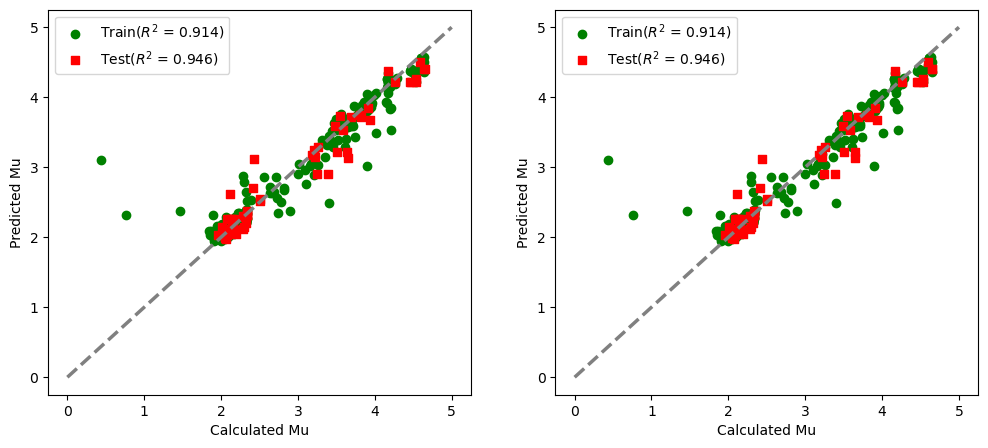

In [92]:
detailed_objective_x1(study_x1_xgb.best_trials[11])

R2 scores (train, CV, test) =  0.8931671025869301 0.8208829906499654 0.9547866100591074
MAE values (train, test) =  0.1657748727459869 0.15037033625271098


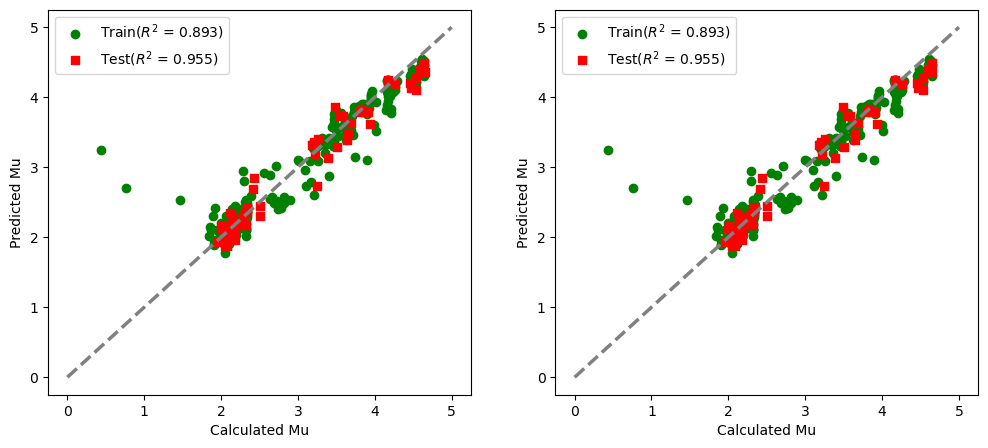

In [90]:
detailed_objective_x1(study_x1_xgb.best_trials[10])

R2 scores (train, CV, test) =  0.9709166354982629 0.7548730103451187 0.9582439441972581
MAE values (train, test) =  0.09448812267077891 0.11516911100928758


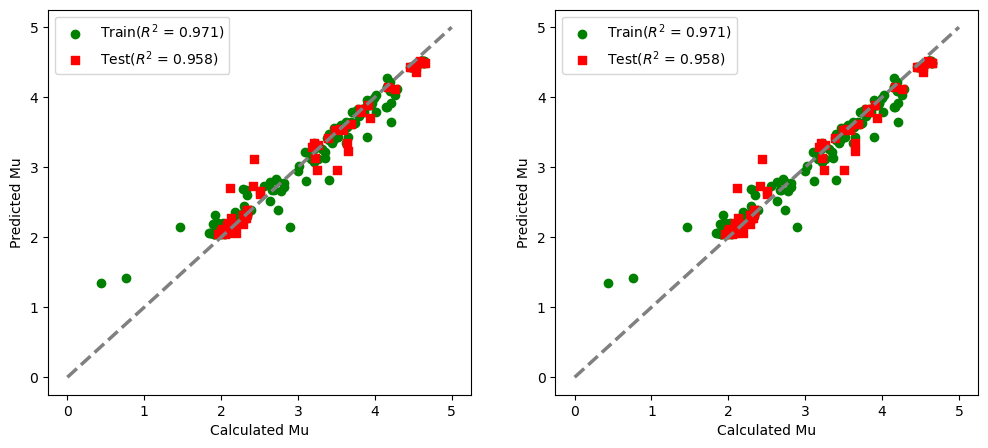

In [88]:
detailed_objective_x1(study_x1_xgb.best_trials[9])

R2 scores (train, CV, test) =  0.9359684291708146 0.8185394234857805 0.9524518124507136
MAE values (train, test) =  0.11197160014143114 0.13197324844894293


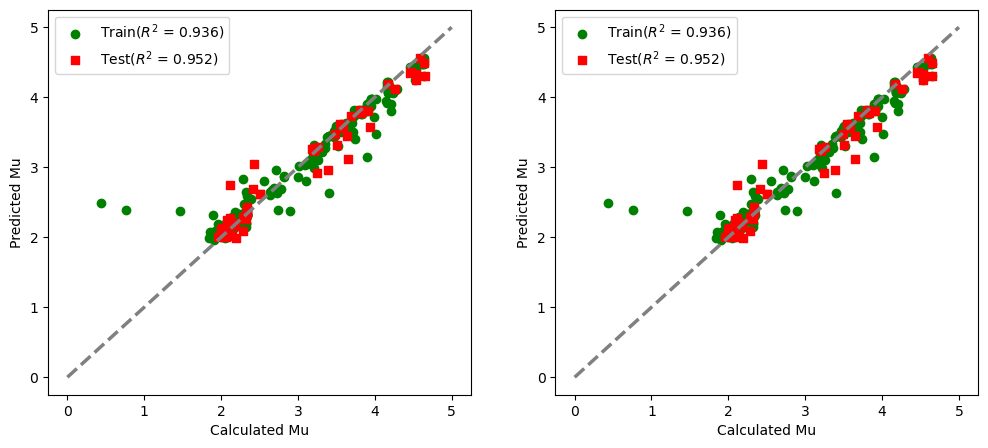

In [86]:
detailed_objective_x1(study_x1_xgb.best_trials[8])

R2 scores (train, CV, test) =  0.9193515611861865 0.8212486578626947 0.9377431432922545
MAE values (train, test) =  0.12111687251470449 0.14279548464884154


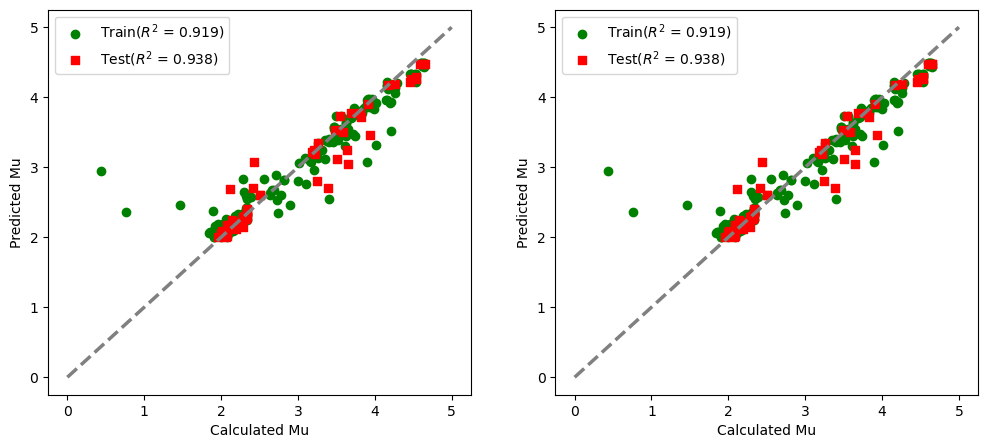

In [102]:
detailed_objective_x1(study_x1_xgb.best_trials[7])

R2 scores (train, CV, test) =  0.9781554695994492 0.7907862334597642 0.9425256532340489
MAE values (train, test) =  0.07781960163103872 0.12761565535147004


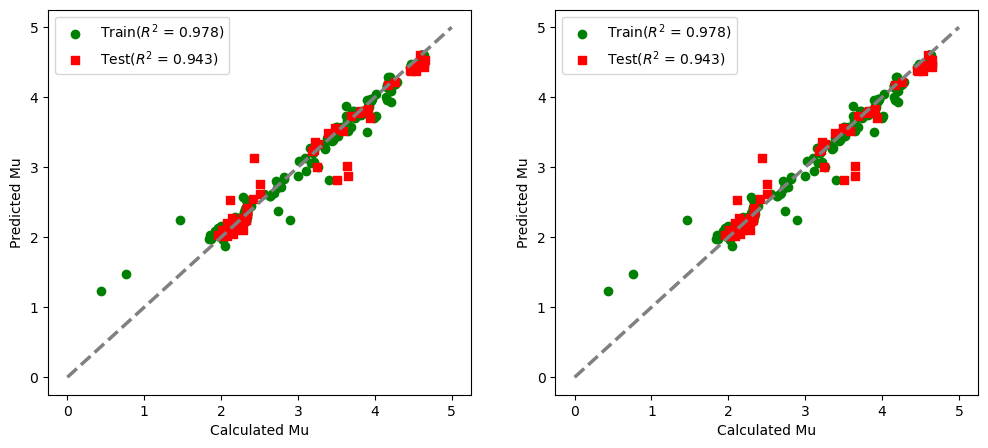

In [100]:
detailed_objective_x1(study_x1_xgb.best_trials[6])

R2 scores (train, CV, test) =  0.9099834106256741 0.8196434256601212 0.9546687671225083
MAE values (train, test) =  0.1532802979078635 0.13735844129354852


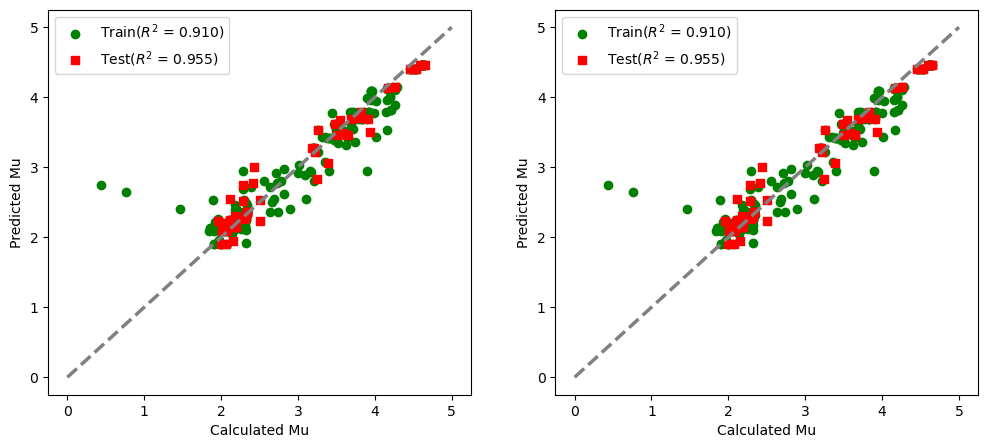

In [98]:
detailed_objective_x1(study_x1_xgb.best_trials[5])

R2 scores (train, CV, test) =  0.9667089384501779 0.8158892902561792 0.9587132307940858
MAE values (train, test) =  0.08578871915735854 0.11886180433889783


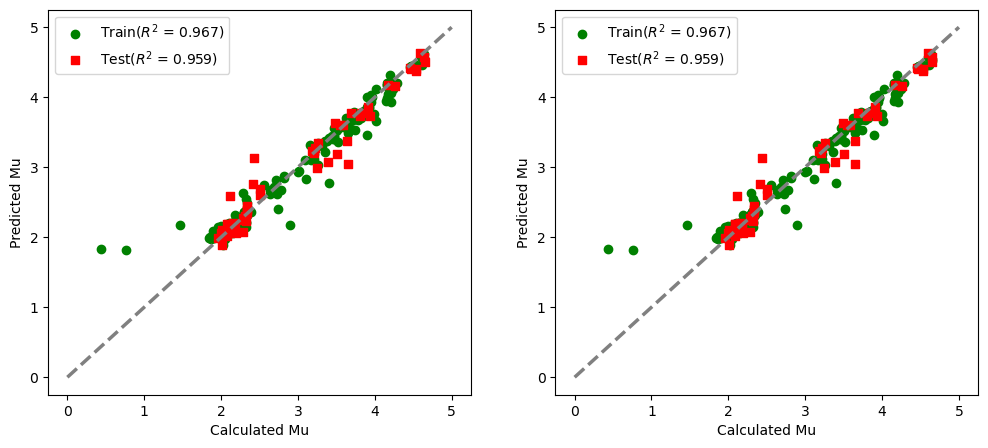

In [96]:
detailed_objective_x1(study_x1_xgb.best_trials[4])

R2 scores (train, CV, test) =  0.9038220266353023 0.7870740758829299 0.9640042331210235
MAE values (train, test) =  0.14684908269749394 0.12069349106982823


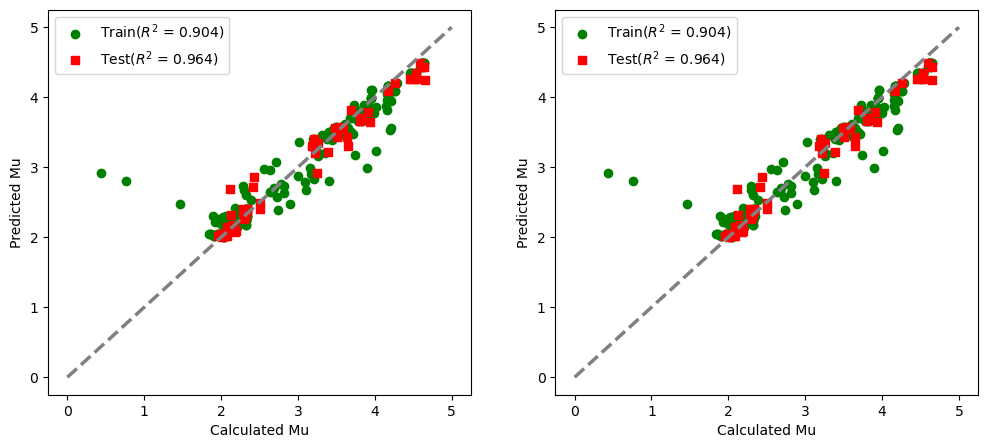

In [94]:
detailed_objective_x1(study_x1_xgb.best_trials[3])

R2 scores (train, CV, test) =  0.9694218853135929 0.8120520511123976 0.9615255853155822
MAE values (train, test) =  0.08393722838738071 0.11561168226858533


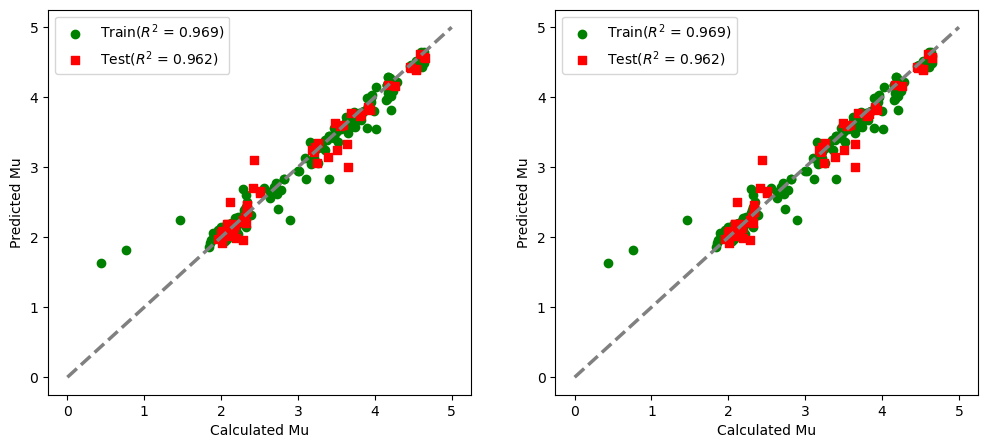

In [73]:
detailed_objective_x1(study_x1_xgb.best_trials[2])

R2 scores (train, CV, test) =  0.9396583123240374 0.8184089578266984 0.9599413976388537
MAE values (train, test) =  0.11340339193294235 0.12514709953418499


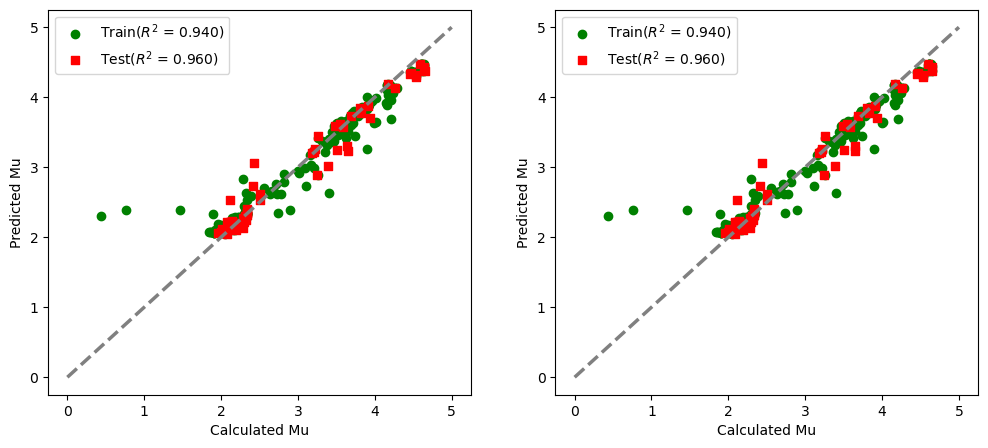

In [71]:
detailed_objective_x1(study_x1_xgb.best_trials[1])

R2 scores (train, CV, test) =  0.8986953185017116 0.7922389663876753 0.9635492479804157
MAE values (train, test) =  0.15785777408179083 0.12934335783598605


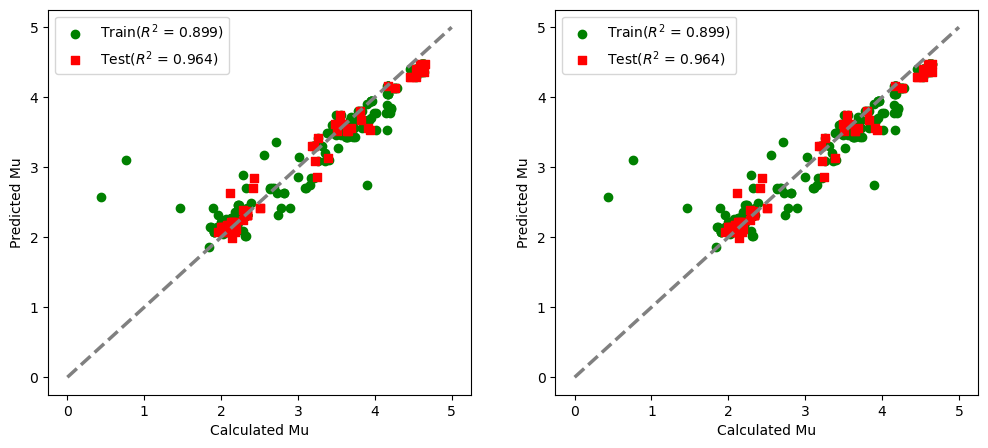

In [69]:
detailed_objective_x1(study_x1_xgb.best_trials[0])

In [103]:
# 47

In [104]:
import optuna
import random

X2_train_mu,X2_test_mu,y2_train_mu,y2_test_mu = train_test_split(X_mu,y_mu,test_size=0.20,random_state=47)

def objective_x2(trial):
    n_estimators = trial.suggest_int('n_estimators',10,150)
    max_depth = trial.suggest_int('max_depth',5,50)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    random_state = 47

    model_x2_xgb = xgb.XGBRegressor(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate,subsample=subsample,
                                     colsample_bytree=colsample_bytree,gamma=gamma,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                                     min_child_weight=min_child_weight,scale_pos_weight=scale_pos_weight,max_delta_step=max_delta_step,
                                     random_state=random_state)

    # Train model
    xgb_mu_optuna_x2 = model_x2_xgb.fit(X2_train_mu,y2_train_mu)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_xgb_mu_optuna_x2 = cross_val_score(xgb_mu_optuna_x2,X2_train_mu,y2_train_mu,cv=cv,scoring='r2',n_jobs=-1)
    avg_r2_cv_xgb_mu_optuna_x2 = cv_scores_xgb_mu_optuna_x2.mean()

    # Return best F1 scores
    r2_train_x2 = r2_score(y2_train_mu, model_x2_xgb.predict(X2_train_mu))
    r2_test_x2 = r2_score(y2_test_mu, model_x2_xgb.predict(X2_test_mu))
#    return avg_r2_cv_xgb_mu_optuna_x2
    return r2_train_x2,avg_r2_cv_xgb_mu_optuna_x2,r2_test_x2

# Run Optuna optimization
#study = optuna.create_study(direction='minimize') # for minimizing loss
study_x2_xgb = optuna.create_study(directions = ['maximize','maximize','maximize']) #(direction='maximize')
study_x2_xgb.optimize(objective_x2, n_trials=300)

[I 2025-03-12 15:56:43,070] A new study created in memory with name: no-name-a2d15bef-00a7-4112-8fa3-9cb06f936023
[I 2025-03-12 15:56:43,339] Trial 0 finished with values: [0.7333721256966228, 0.6858509848227525, 0.8391237329134819] and parameters: {'n_estimators': 28, 'max_depth': 28, 'learning_rate': 0.06778304810512613, 'subsample': 0.37468769240817956, 'colsample_bytree': 0.49852317546393254, 'gamma': 5.053014075413137, 'reg_alpha': 0.0016961495271424223, 'reg_lambda': 1.7343617644866353e-05, 'min_child_weight': 8, 'scale_pos_weight': 3, 'max_delta_step': 0.9102506951653389}.
[I 2025-03-12 15:56:43,607] Trial 1 finished with values: [0.8110910872652978, 0.7548172604995776, 0.9064736364449989] and parameters: {'n_estimators': 65, 'max_depth': 34, 'learning_rate': 0.10933220242595665, 'subsample': 0.13272021866335207, 'colsample_bytree': 0.11618686567193366, 'gamma': 1.6441117889709833, 'reg_alpha': 1.5443569836005287e-05, 'reg_lambda': 8.761472655258402e-06, 'min_child_weight': 5, '

In [105]:
best_models_x2 = study_x2_xgb.best_trials
#PRINT('Trial number',
for i in range(len(best_models_x2)):
    print('Model No:',i,'\n=======', '\nTrial No:',best_models_x2[i].number, '\nTrain R2:',best_models_x2[i].values[0],'\nValid R2:',best_models_x2[i].values[1],
         '\nTest  R2:',best_models_x2[i].values[2],'\nParams  :',best_models_x2[i].params,'\n=======')

Model No: 0 
Trial No: 58 
Train R2: 0.9771458439133093 
Valid R2: 0.817442558470918 
Test  R2: 0.9847993152787221 
Params  : {'n_estimators': 65, 'max_depth': 16, 'learning_rate': 0.12195359264340173, 'subsample': 0.8017998529396181, 'colsample_bytree': 0.13028241321240894, 'gamma': 0.003696675554829554, 'reg_alpha': 0.0011055061870422803, 'reg_lambda': 5.2819553056496964e-08, 'min_child_weight': 6, 'scale_pos_weight': 3, 'max_delta_step': 8.745865625011861} 
Model No: 1 
Trial No: 147 
Train R2: 0.9898294106777247 
Valid R2: 0.7943148020002162 
Test  R2: 0.9884725628774554 
Params  : {'n_estimators': 124, 'max_depth': 18, 'learning_rate': 0.12195359264340173, 'subsample': 0.8017998529396181, 'colsample_bytree': 0.7566840594248507, 'gamma': 0.003696675554829554, 'reg_alpha': 0.0011055061870422803, 'reg_lambda': 0.1306321396564416, 'min_child_weight': 6, 'scale_pos_weight': 5, 'max_delta_step': 8.745865625011861} 
Model No: 2 
Trial No: 150 
Train R2: 0.9686368630966958 
Valid R2: 0.81

In [224]:
best_models_x2_pd = pd.DataFrame({'Trial number': [best_models_x2[i].number for i in range(len(best_models_x2))],
                                             'Train R2': [best_models_x2[i].values[0] for i in range(len(best_models_x2))],
                                             'Test R2': [best_models_x2[i].values[2] for i in range(len(best_models_x2))],
                                             'CV R2': [best_models_x2[i].values[1] for i in range(len(best_models_x2))],
                                             'n_estimators': [best_models_x2[i].params['n_estimators'] for i in range(len(best_models_x2))],
                                             'max_depth': [best_models_x2[i].params['max_depth'] for i in range(len(best_models_x2))],
                                             'learning_rate': [best_models_x2[i].params['learning_rate'] for i in range(len(best_models_x2))],
                                             'subsample': [best_models_x2[i].params['subsample'] for i in range(len(best_models_x2))],
                                             'colsample_bytree': [best_models_x2[i].params['colsample_bytree'] for i in range(len(best_models_x2))],
                                             'gamma': [best_models_x2[i].params['gamma'] for i in range(len(best_models_x2))],
                                             'reg_alpha': [best_models_x2[i].params['reg_alpha'] for i in range(len(best_models_x2))],
                                             'reg_lambda': [best_models_x2[i].params['reg_lambda'] for i in range(len(best_models_x2))],
                                             'min_child_weight': [best_models_x2[i].params['min_child_weight'] for i in range(len(best_models_x2))],
                                             'scale_pos_weight': [best_models_x2[i].params['scale_pos_weight'] for i in range(len(best_models_x2))],
                                             'max_delta_step': [best_models_x2[i].params['max_delta_step'] for i in range(len(best_models_x2))]
                                            })
best_models_x2_pd.to_excel('Results_Mu/XGBRegressor_X_47_HP_Optuna.xlsx')

In [106]:
## Best models

In [174]:
import optuna
import random

#X2_train_mu,X2_test_mu,y2_train_mu,y2_test_mu = train_test_split(X_mu,y_mu,test_size=0.20,random_state=47)

def detailed_objective_x2(trial):
    n_estimators = trial.suggest_int('n_estimators',10,150)
    max_depth = trial.suggest_int('max_depth',5,50)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    random_state = 47

    model_x2_xgb = xgb.XGBRegressor(n_estimators=best_models_x2[0].params['n_estimators'],
                                    max_depth=best_models_x2[0].params['max_depth'],
                                    learning_rate=best_models_x2[0].params['learning_rate'],
                                    subsample=best_models_x2[0].params['subsample'],
                                    colsample_bytree=best_models_x2[0].params['colsample_bytree'],
                                    gamma=best_models_x2[0].params['gamma'],
                                    reg_alpha=best_models_x2[0].params['reg_alpha'],
                                    reg_lambda=best_models_x2[0].params['reg_lambda'],
                                    min_child_weight=best_models_x2[0].params['min_child_weight'],
                                    scale_pos_weight=best_models_x2[0].params['scale_pos_weight'],
                                    max_delta_step=best_models_x2[0].params['max_delta_step'],
                                    random_state=random_state)

    # Train model
    xgb_mu_optuna_x2 = model_x2_xgb.fit(X2_train_mu,y2_train_mu)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_xgb_mu_optuna_x2 = cross_val_score(xgb_mu_optuna_x2,X2_train_mu,y2_train_mu,cv=cv,scoring='r2',n_jobs=-1)
    avg_r2_cv_xgb_mu_optuna_x2 = cv_scores_xgb_mu_optuna_x2.mean()

    # Return best R2 scores and MAE
    r2_train_x2 = r2_score(y2_train_mu, model_x2_xgb.predict(X2_train_mu))
    r2_test_x2 = r2_score(y2_test_mu, model_x2_xgb.predict(X2_test_mu))

    mae_train_x2 = mean_absolute_error(y2_train_mu, model_x2_xgb.predict(X2_train_mu))
    mae_test_x2 = mean_absolute_error(y2_test_mu, model_x2_xgb.predict(X2_test_mu))
    
    print('R2 scores (train, CV, test) = ', r2_train_x2,avg_r2_cv_xgb_mu_optuna_x2,r2_test_x2)
    print('MAE values (train, test) = ', mae_train_x2,mae_test_x2)

    ## Exporting the results
    y2_pred_train_mu = model_x2_xgb.predict(X2_train_mu)
    y2_pred_test_mu = model_x2_xgb.predict(X2_test_mu)

    X2_train_mu.to_excel('Results_Mu/X_47_train_Optuna.xlsx',index=False)
    X2_test_mu.to_excel('Results_Mu/X_47_test_Optuna.xlsx',index=False)      
    
    y2_train_mu.to_excel('Results_Mu/y_47_train_Optuna.xlsx',index=False)
    y2_test_mu.to_excel('Results_Mu/y_47_test_Optuna.xlsx',index=False)      
    
    pd.DataFrame(y2_pred_train_mu).to_excel('Results_Mu/y_47_pred_train_Optuna_0.xlsx',index=False)
    pd.DataFrame(y2_pred_test_mu).to_excel('Results_Mu/y_47_pred_test_Optuna_0.xlsx',index=False)    

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    ax1.scatter(y2_train_mu, model_x2_xgb.predict(X2_train_mu).flatten(),label='Train($R^2$ = '+str(f'{r2_train_x2:.3f}')+')',marker='o',color='green')
#    ax1.scatter(y2_val, model_x2_xgb.predict(X2_val).flatten(),label='Val($R^2$ = '+str(f'{avg_r2_cv_xgb_mu_optuna_x2:.3f}')+')',marker='^',color='blue')
    ax1.scatter(y2_test_mu, model_x2_xgb.predict(X2_test_mu).flatten(),label='Test($R^2$ = '+str(f'{r2_test_x2:.3f}')+')',marker='s',color='red')
    ax1.set_xlabel('Calculated Mu')
    ax1.set_ylabel('Predicted Mu')
    ax1.plot([0,5], [0,5],linewidth=2.5, color='gray', linestyle='dashed')
    ax1.legend()
    
    ax2.scatter(y2_train_mu, model_x2_xgb.predict(X2_train_mu).flatten(),label='Train($R^2$ = '+str(f'{r2_train_x2:.3f}')+')',marker='o',color='green')
    ax2.scatter(y2_test_mu, model_x2_xgb.predict(X2_test_mu).flatten(),label='Test($R^2$ = '+str(f'{r2_test_x2:.3f}')+')',marker='s',color='red')
    ax2.set_xlabel('Calculated Mu')
    ax2.set_ylabel('Predicted Mu')
    ax2.plot([0,5], [0,5],linewidth=2.5, color='gray', linestyle='dashed')
    ax2.legend()
    
    plt.show()

R2 scores (train, CV, test) =  0.9771458439133093 0.817442558470918 0.9847993152787221
MAE values (train, test) =  0.04801045328252795 0.08155829886370276


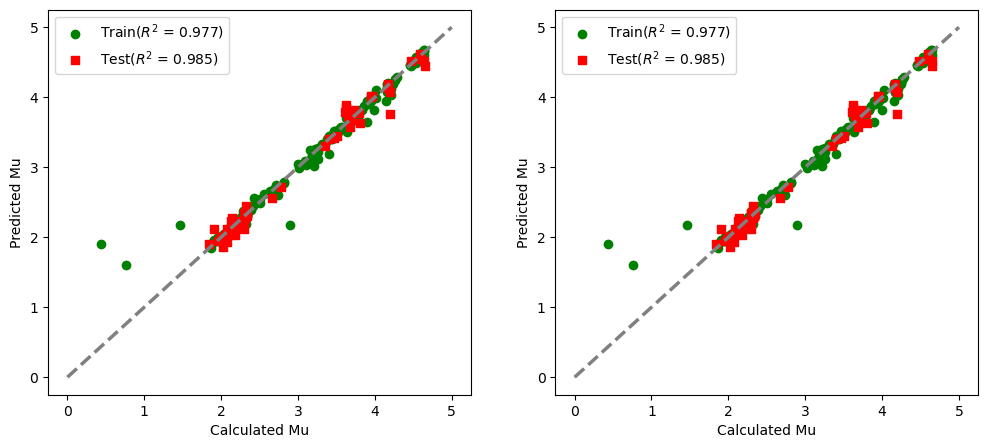

In [175]:
detailed_objective_x2(study_x2_xgb.best_trials[0])

R2 scores (train, CV, test) =  0.9898294106777247 0.7943148020002162 0.9884725628774554
MAE values (train, test) =  0.031162330971063357 0.07577033954115495


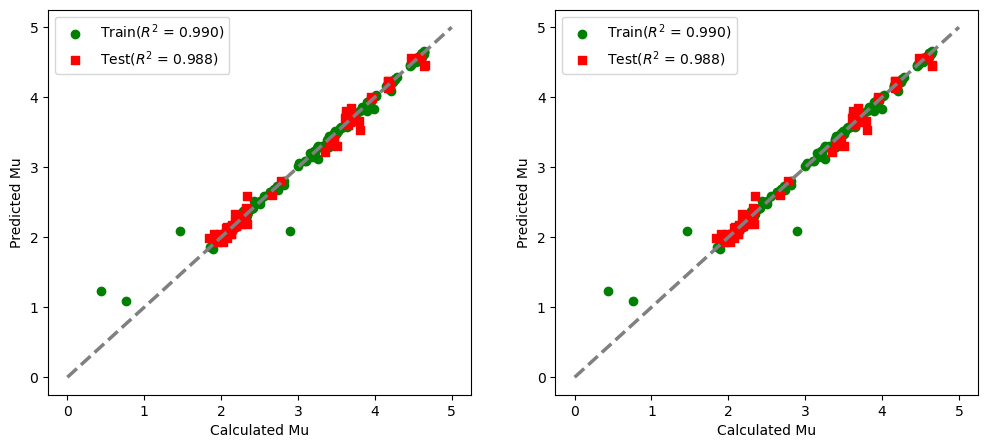

In [173]:
detailed_objective_x2(study_x2_xgb.best_trials[1])

R2 scores (train, CV, test) =  0.9686368630966958 0.8171372972870172 0.9947255627307043
MAE values (train, test) =  0.05048631790437131 0.0505334849092859


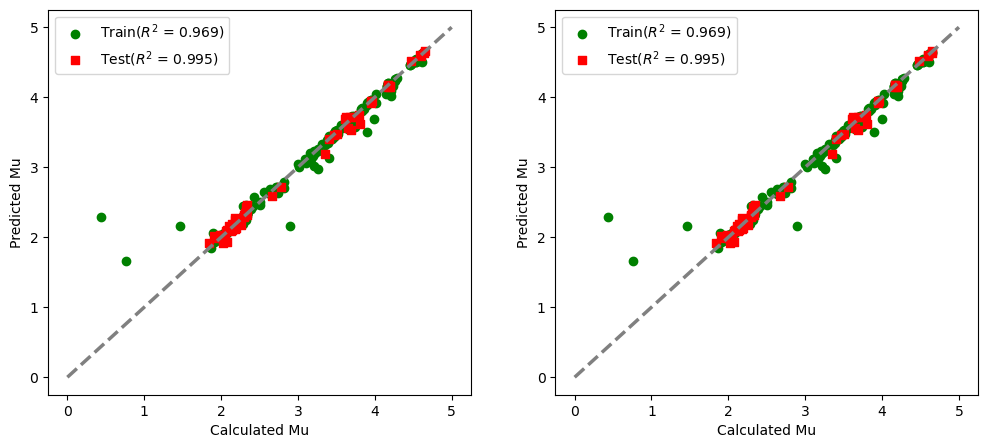

In [171]:
detailed_objective_x2(study_x2_xgb.best_trials[2])

R2 scores (train, CV, test) =  0.9624049811445934 0.8193023878580796 0.9942397363857177
MAE values (train, test) =  0.07136193382576295 0.05547821919544674


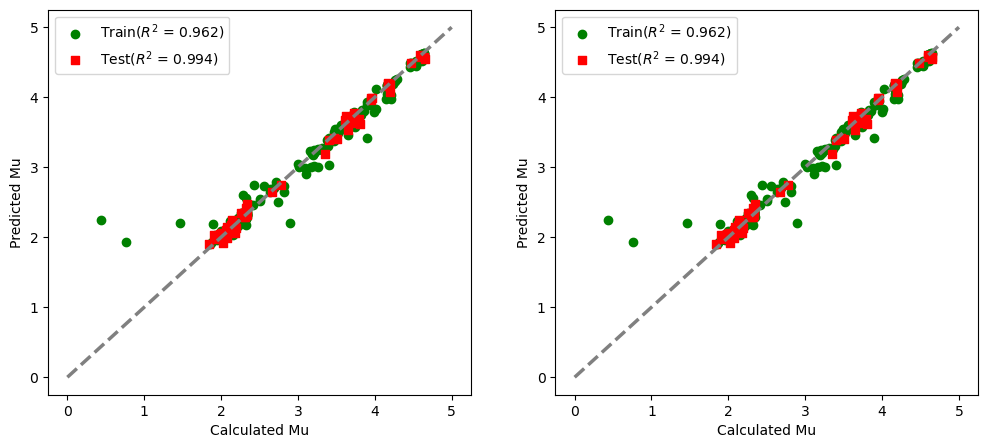

In [169]:
detailed_objective_x2(study_x2_xgb.best_trials[3])

R2 scores (train, CV, test) =  0.9898294106777247 0.7943148020002162 0.9884725628774554
MAE values (train, test) =  0.031162330971063357 0.07577033954115495


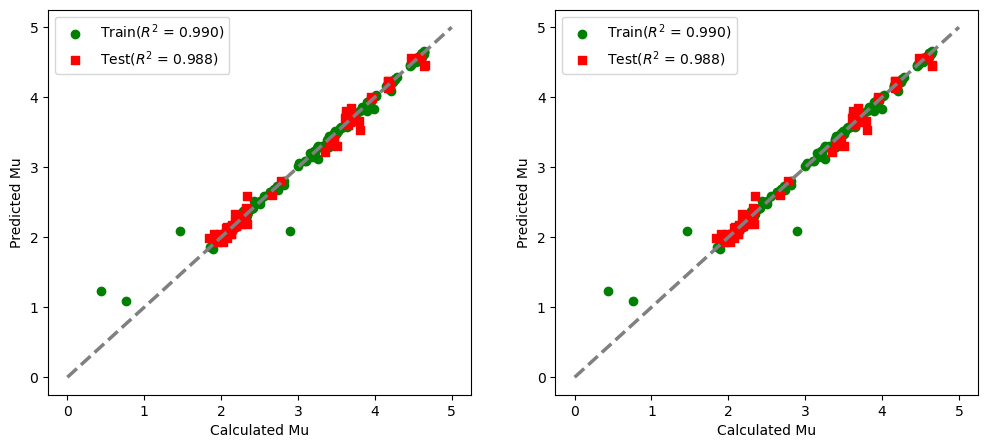

In [167]:
detailed_objective_x2(study_x2_xgb.best_trials[4])

R2 scores (train, CV, test) =  0.9916558988455146 0.7515841737611996 0.9957042575923984
MAE values (train, test) =  0.04129816376098669 0.04015519571722098


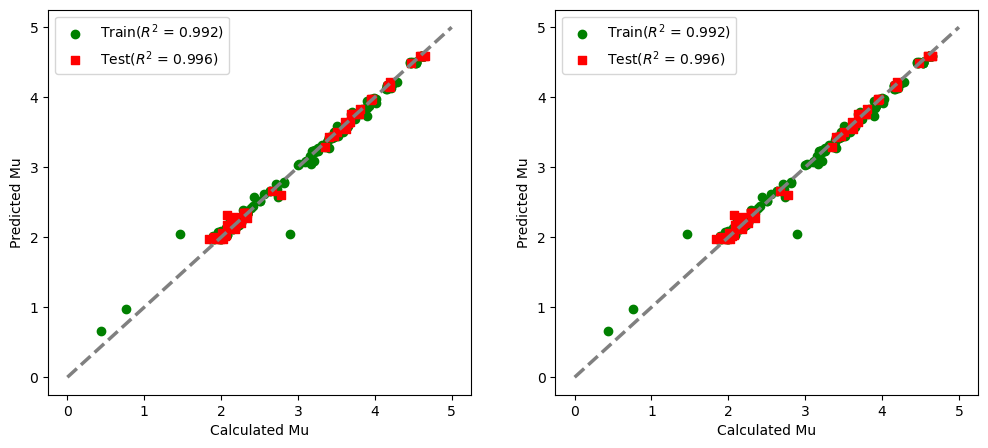

In [165]:
detailed_objective_x2(study_x2_xgb.best_trials[5])

R2 scores (train, CV, test) =  0.9515709310865508 0.8296596989507774 0.9782227813915674
MAE values (train, test) =  0.08915158666271979 0.09928587576067009


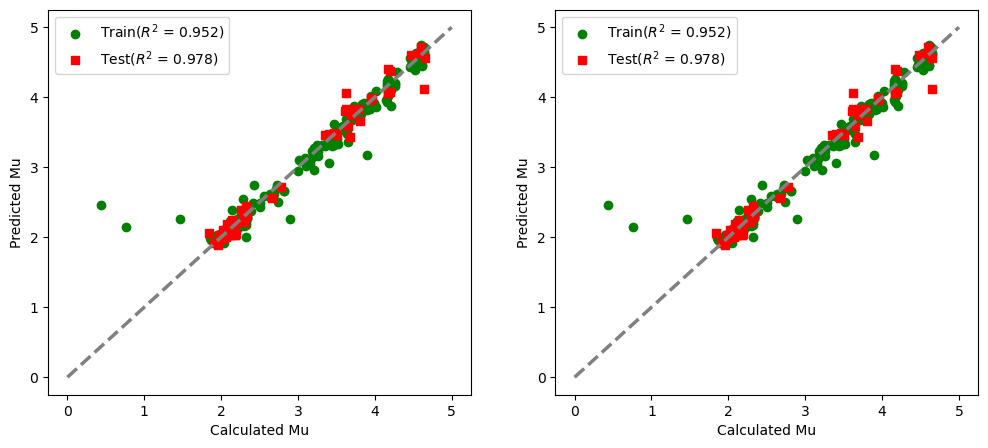

In [163]:
detailed_objective_x2(study_x2_xgb.best_trials[6])

R2 scores (train, CV, test) =  0.9824698568403809 0.8012622208294735 0.9889682599839646
MAE values (train, test) =  0.03654875311021241 0.0681191478014334


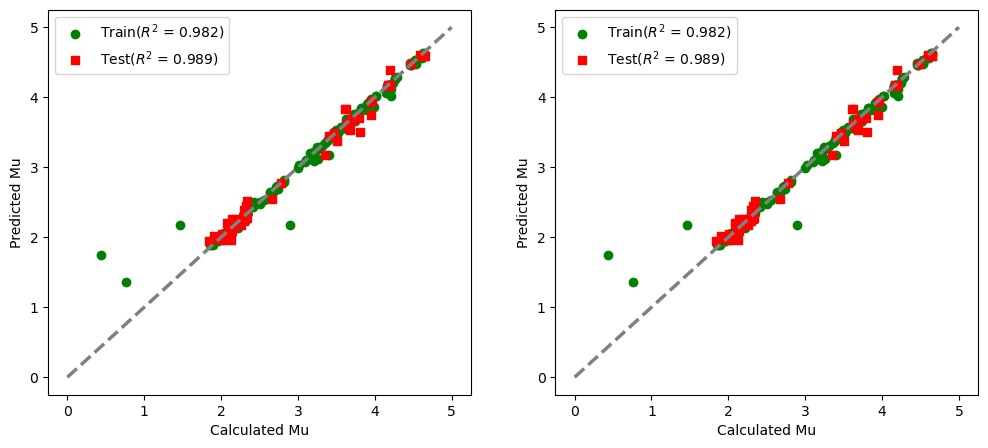

In [108]:
detailed_objective_x2(study_x2_xgb.best_trials[7])

R2 scores (train, CV, test) =  0.9769027556714801 0.8210322668038103 0.9799821018130597
MAE values (train, test) =  0.05174934432146555 0.08919889753807173


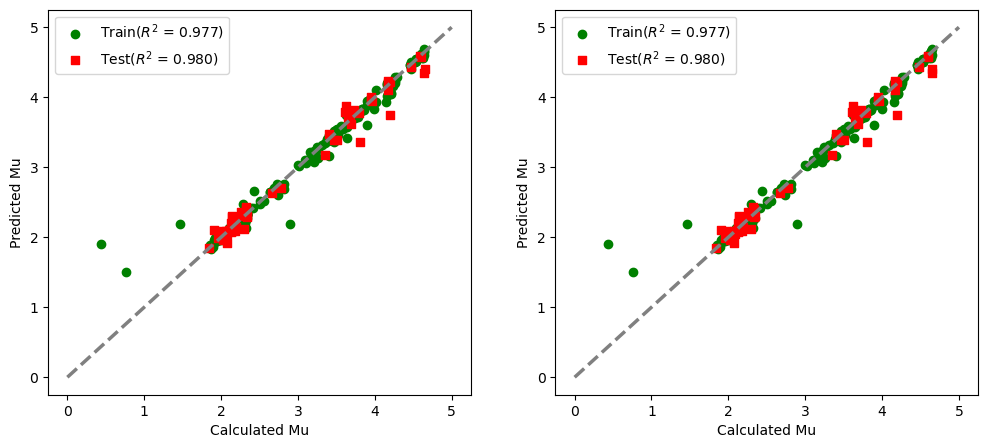

In [160]:
detailed_objective_x2(study_x2_xgb.best_trials[8])

R2 scores (train, CV, test) =  0.9678430610305497 0.8254997829401018 0.9903158599869929
MAE values (train, test) =  0.05694348064614389 0.06880214154456918


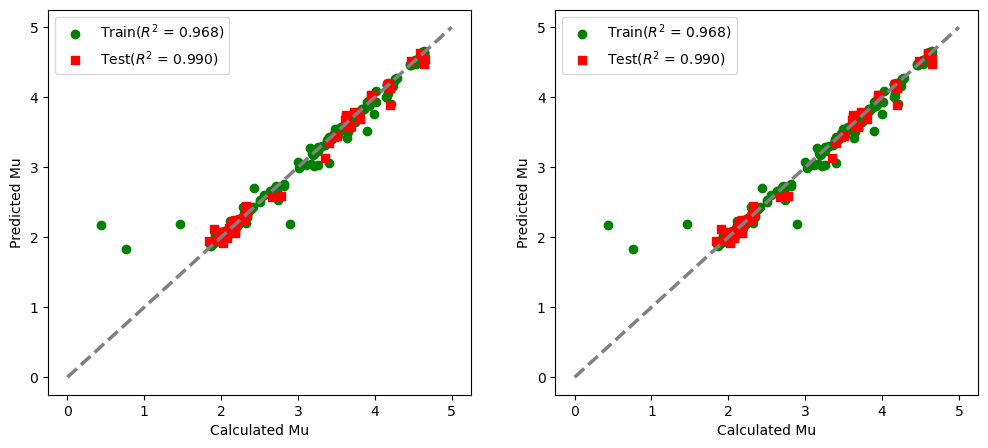

In [158]:
detailed_objective_x2(study_x2_xgb.best_trials[9])

R2 scores (train, CV, test) =  0.9206410811620993 0.838911865264596 0.990789017040981
MAE values (train, test) =  0.102486600803459 0.07083602799122925


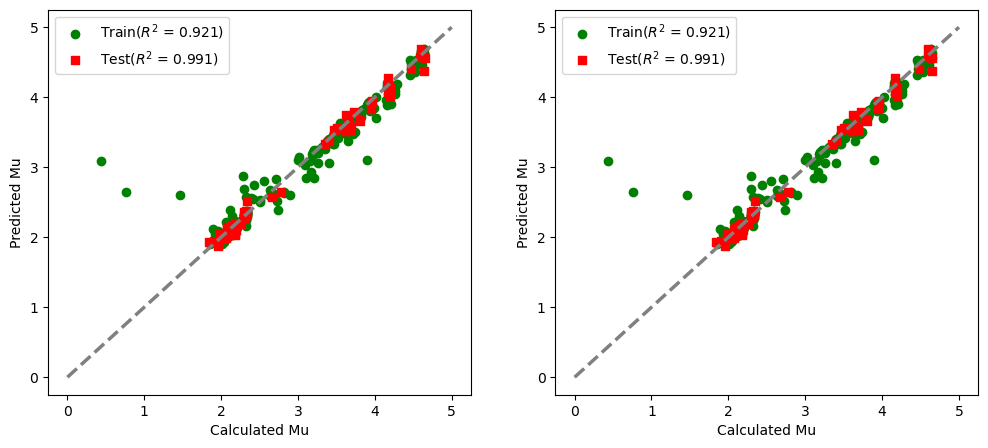

In [156]:
detailed_objective_x2(study_x2_xgb.best_trials[10])

R2 scores (train, CV, test) =  0.9815792840085347 0.8131205281496374 0.9946695742584936
MAE values (train, test) =  0.039820558474002676 0.04892266990204544


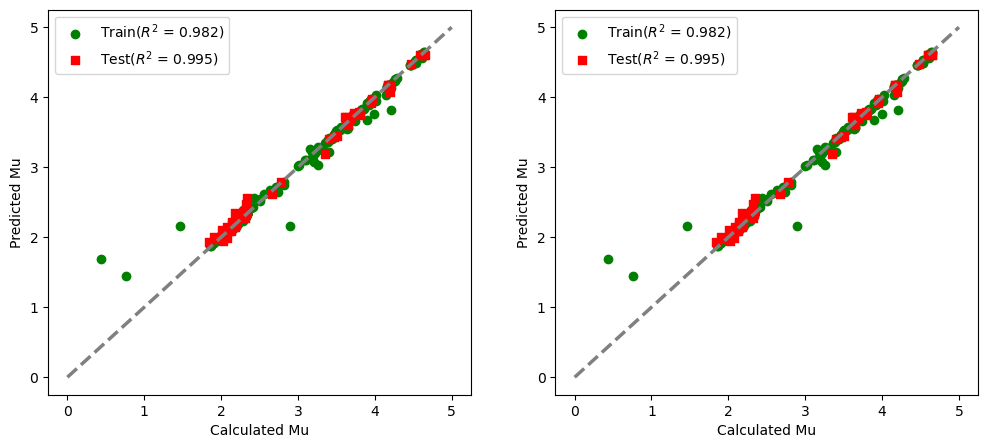

In [154]:
detailed_objective_x2(study_x2_xgb.best_trials[11])

R2 scores (train, CV, test) =  0.9936777010686698 0.7887573236960106 0.9835195201976006
MAE values (train, test) =  0.02550947222543277 0.084477766239109


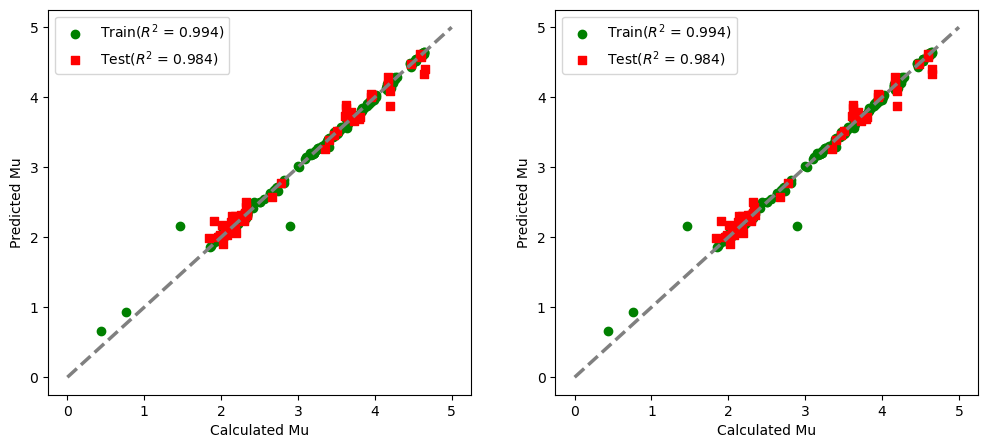

In [152]:
detailed_objective_x2(study_x2_xgb.best_trials[12])

R2 scores (train, CV, test) =  0.9859299208963382 0.8001391253904208 0.9902727999300075
MAE values (train, test) =  0.03510512665034437 0.07272490974822438


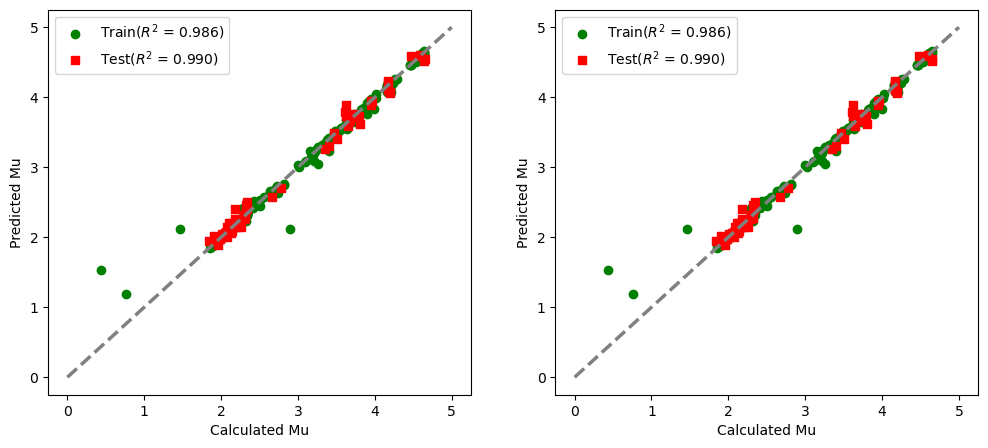

In [150]:
detailed_objective_x2(study_x2_xgb.best_trials[13])

R2 scores (train, CV, test) =  0.9719625802018523 0.8166214495743102 0.993577164478893
MAE values (train, test) =  0.06517532413882315 0.05558905094087094


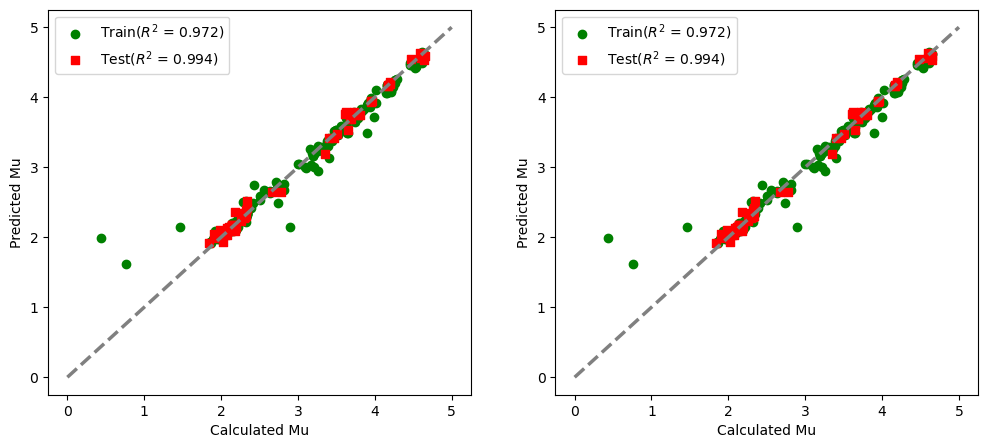

In [148]:
detailed_objective_x2(study_x2_xgb.best_trials[14])

R2 scores (train, CV, test) =  0.9838617480996817 0.8166629418740833 0.9680286020382832
MAE values (train, test) =  0.0435105941610009 0.10379798449775822


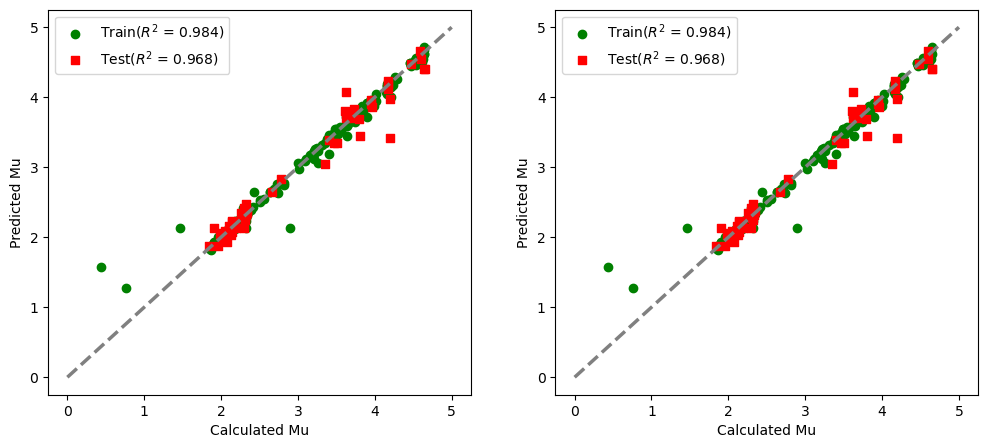

In [146]:
detailed_objective_x2(study_x2_xgb.best_trials[15])

R2 scores (train, CV, test) =  0.9916102276383016 0.792882080607449 0.9848947521396798
MAE values (train, test) =  0.029097361097239146 0.07709002081807316


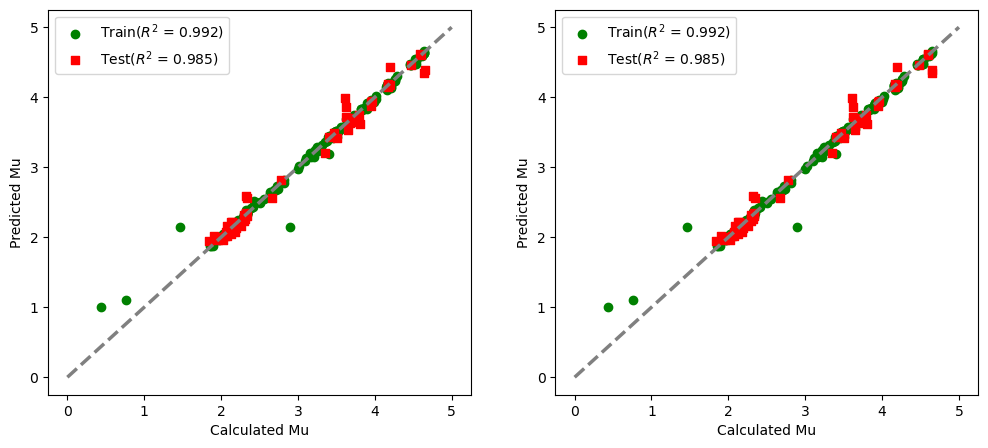

In [144]:
detailed_objective_x2(study_x2_xgb.best_trials[16])

R2 scores (train, CV, test) =  0.9499331432270158 0.829817437358163 0.9821010323736744
MAE values (train, test) =  0.09021024763860376 0.0995506809053616


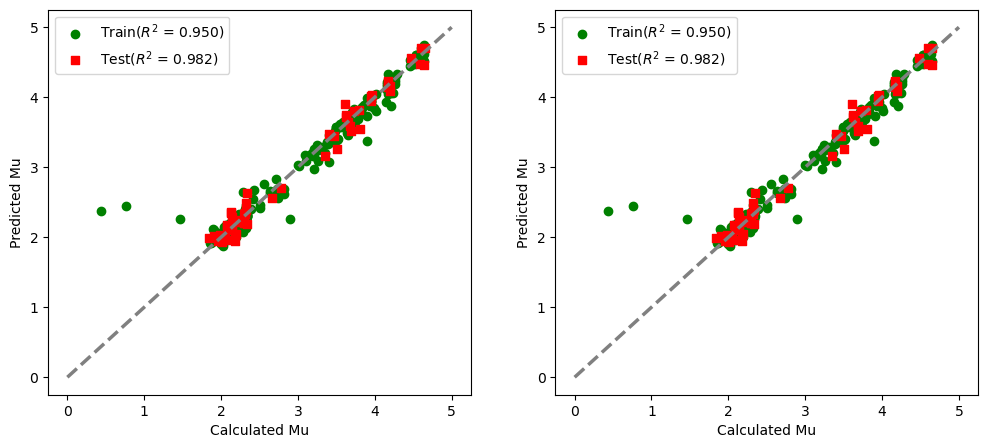

In [142]:
detailed_objective_x2(study_x2_xgb.best_trials[17])

R2 scores (train, CV, test) =  0.9742256708275563 0.8201819424249776 0.9928116610249199
MAE values (train, test) =  0.04818323585812655 0.05722780520805


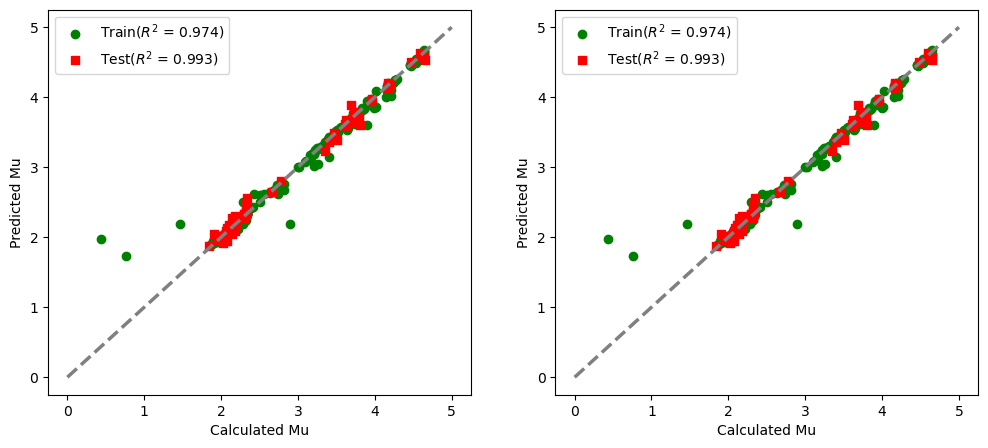

In [140]:
detailed_objective_x2(study_x2_xgb.best_trials[18])

R2 scores (train, CV, test) =  0.9868474327838315 0.807039887596774 0.9748485947835608
MAE values (train, test) =  0.038023680039183196 0.10304727960858168


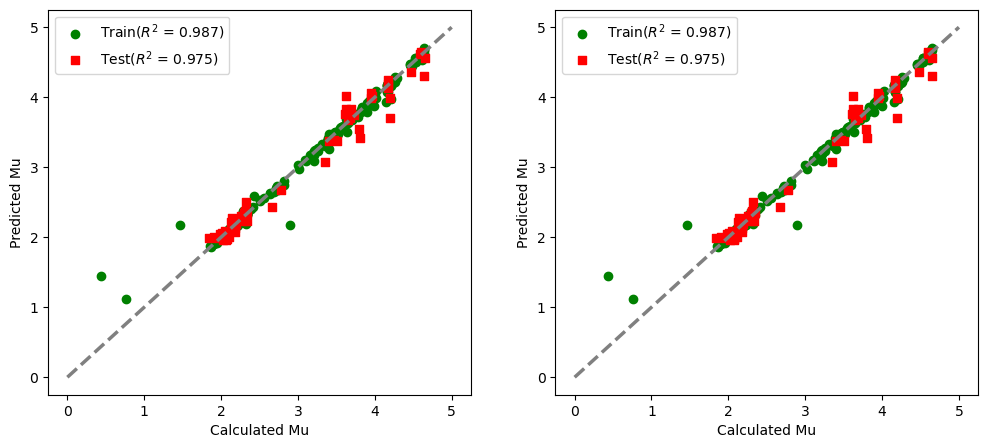

In [138]:
detailed_objective_x2(study_x2_xgb.best_trials[19])

R2 scores (train, CV, test) =  0.9646090721689969 0.8261746984521612 0.9754559445190831
MAE values (train, test) =  0.07665489685281153 0.1061189766081527


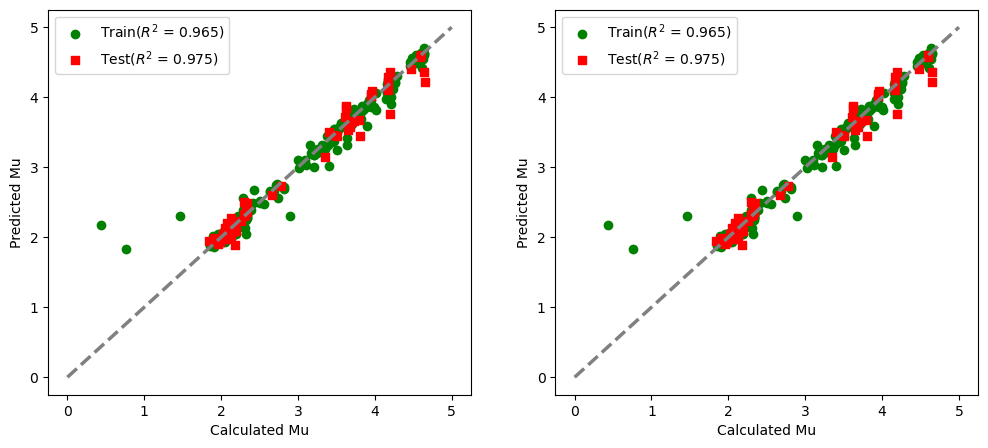

In [136]:
detailed_objective_x2(study_x2_xgb.best_trials[20])

R2 scores (train, CV, test) =  0.9910298103132416 0.798176109726739 0.9868759543620593
MAE values (train, test) =  0.028432150866863036 0.06995514704402382


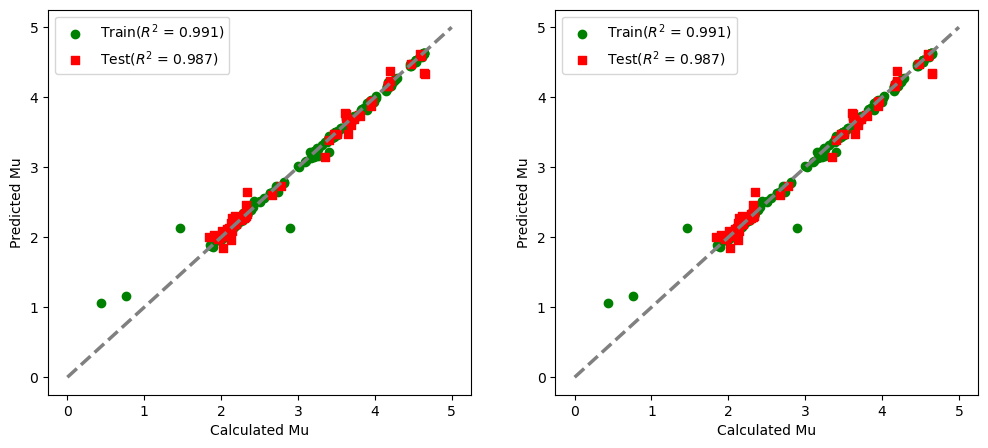

In [134]:
detailed_objective_x2(study_x2_xgb.best_trials[21])

R2 scores (train, CV, test) =  0.9586504440958405 0.819946018044071 0.9933642780236477
MAE values (train, test) =  0.07415756769436598 0.05798201863920306


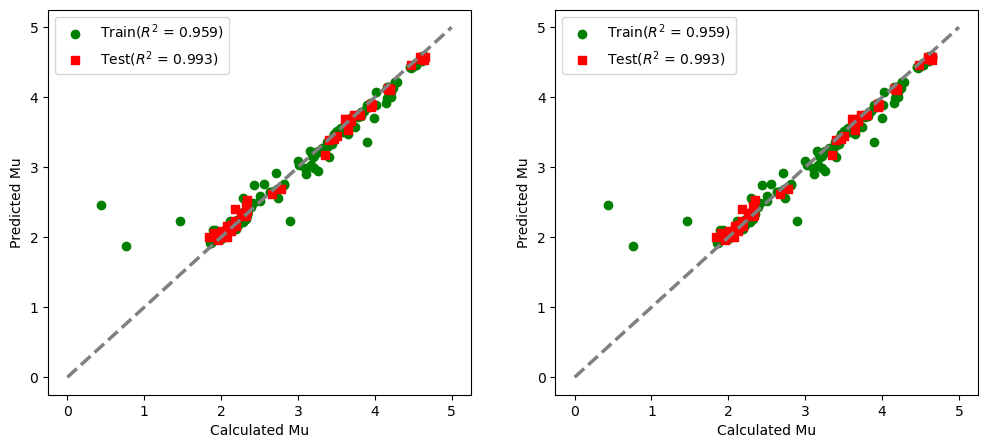

In [132]:
detailed_objective_x2(study_x2_xgb.best_trials[22])

R2 scores (train, CV, test) =  0.9941088334735899 0.7839552351043936 0.9925711565992472
MAE values (train, test) =  0.022713558614513348 0.056232659883336505


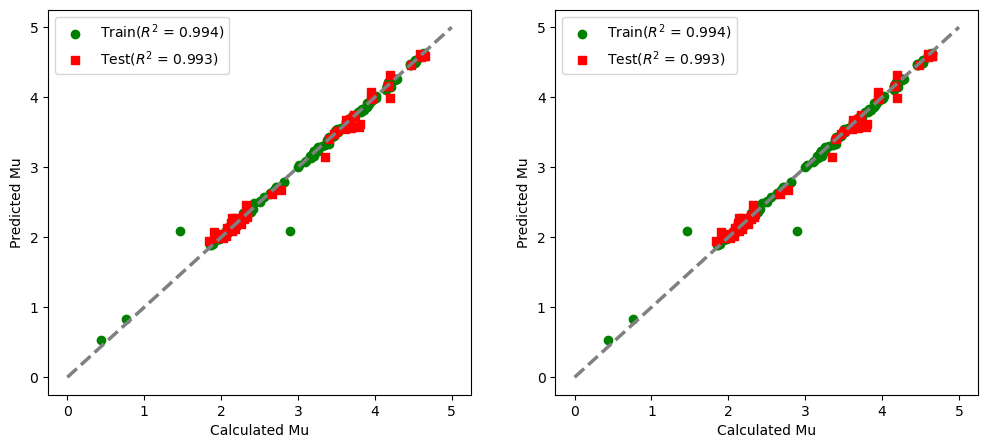

In [130]:
detailed_objective_x2(study_x2_xgb.best_trials[23])

R2 scores (train, CV, test) =  0.9746601705908137 0.8229143033144177 0.9891773253105677
MAE values (train, test) =  0.05029892333080426 0.0721293179223513


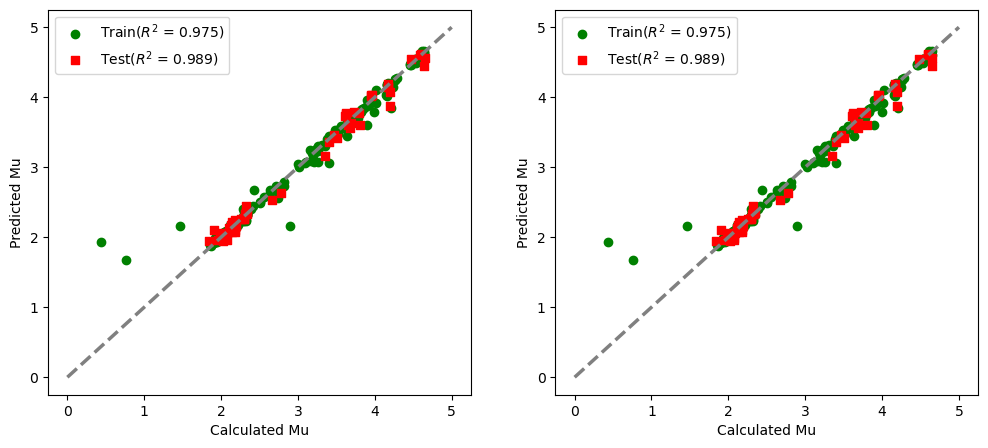

In [128]:
detailed_objective_x2(study_x2_xgb.best_trials[24])

R2 scores (train, CV, test) =  0.9449609401999721 0.8474824602816484 0.9897775629292698
MAE values (train, test) =  0.0738341153522673 0.07043730745524958


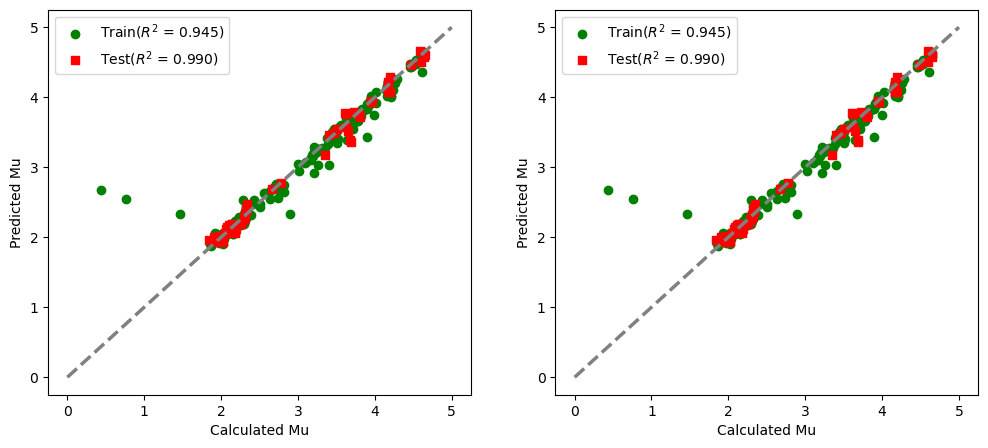

In [126]:
detailed_objective_x2(study_x2_xgb.best_trials[25])

R2 scores (train, CV, test) =  0.966581885750147 0.8187780272596946 0.9946831390339675
MAE values (train, test) =  0.06731228600206104 0.05083142983907568


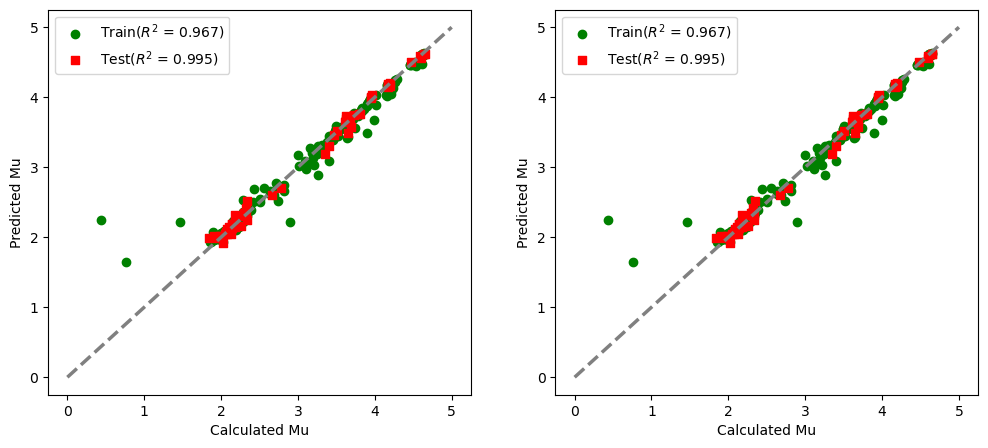

In [124]:
detailed_objective_x2(study_x2_xgb.best_trials[26])

R2 scores (train, CV, test) =  0.9924146145368163 0.7889177120219975 0.995527829136114
MAE values (train, test) =  0.02768007436656278 0.04623154232019445


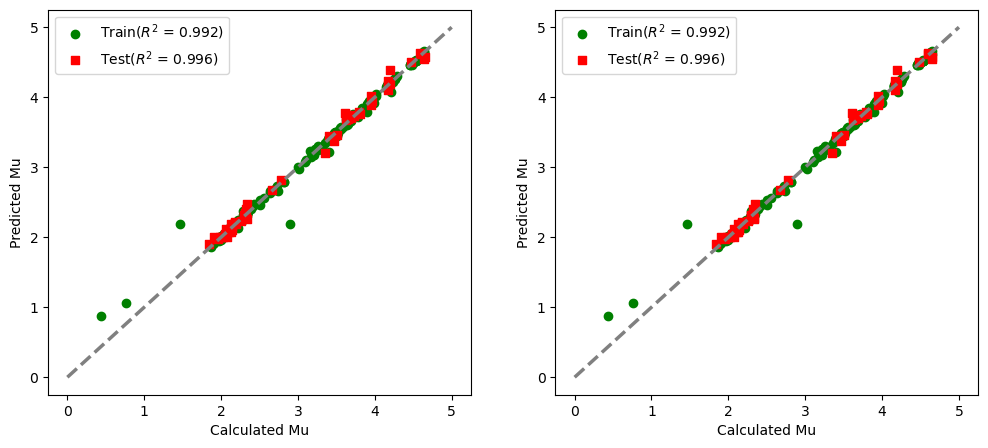

In [122]:
detailed_objective_x2(study_x2_xgb.best_trials[27])

R2 scores (train, CV, test) =  0.9939690894372264 0.7881277259677685 0.9890649079276488
MAE values (train, test) =  0.025531478197893545 0.06878824891787937


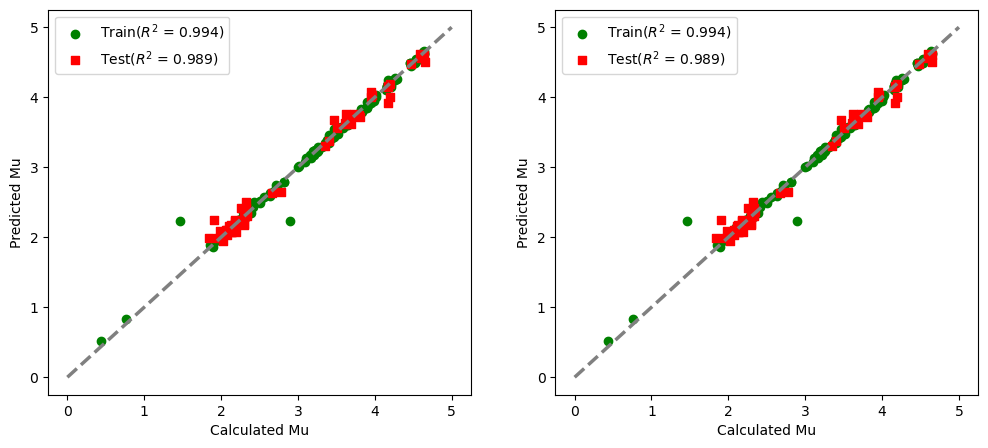

In [120]:
detailed_objective_x2(study_x2_xgb.best_trials[28])

R2 scores (train, CV, test) =  0.9932269077112478 0.7923179123441719 0.9780423384701863
MAE values (train, test) =  0.026199334010103454 0.09682786853211042


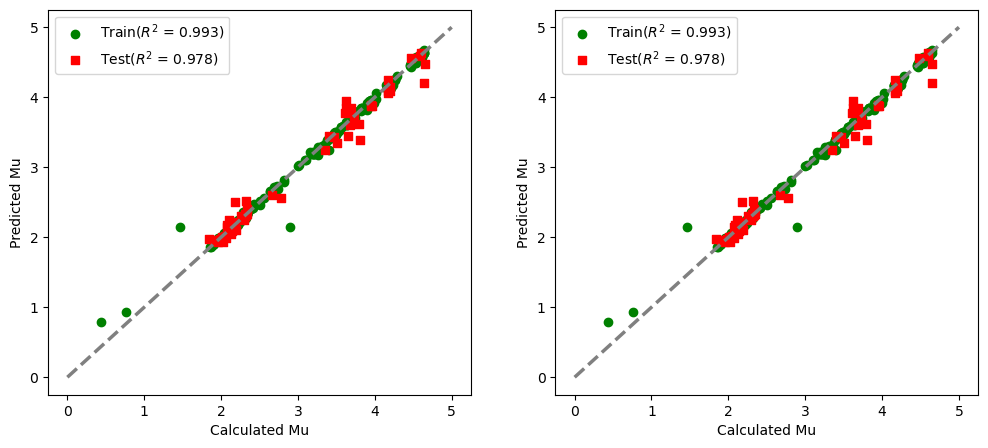

In [118]:
detailed_objective_x2(study_x2_xgb.best_trials[29])

R2 scores (train, CV, test) =  0.9294906527856523 0.8372218620601922 0.9912980384168618
MAE values (train, test) =  0.10192169416247467 0.06524225020016867


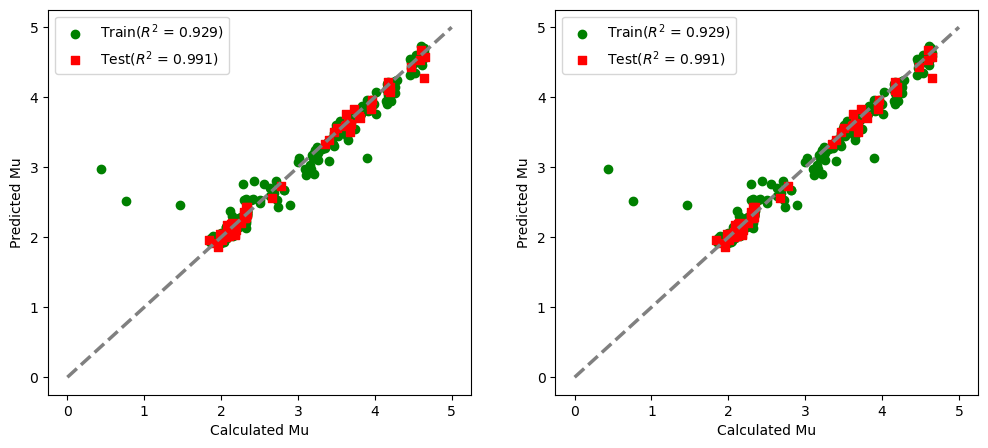

In [116]:
detailed_objective_x2(study_x2_xgb.best_trials[30])

R2 scores (train, CV, test) =  0.9839870604186396 0.8052429071872187 0.988652264552959
MAE values (train, test) =  0.03704524972372024 0.07120308364005218


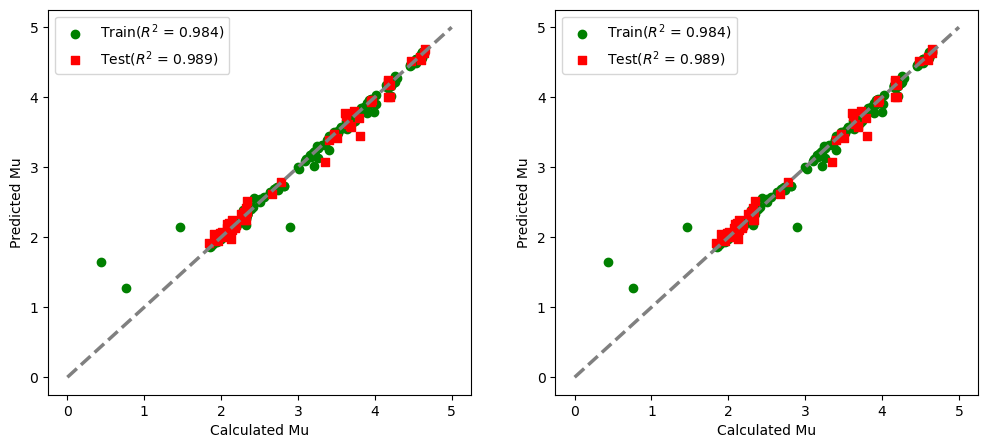

In [114]:
detailed_objective_x2(study_x2_xgb.best_trials[31])

R2 scores (train, CV, test) =  0.9624049811445934 0.8193023878580796 0.9942397363857177
MAE values (train, test) =  0.07136193382576295 0.05547821919544674


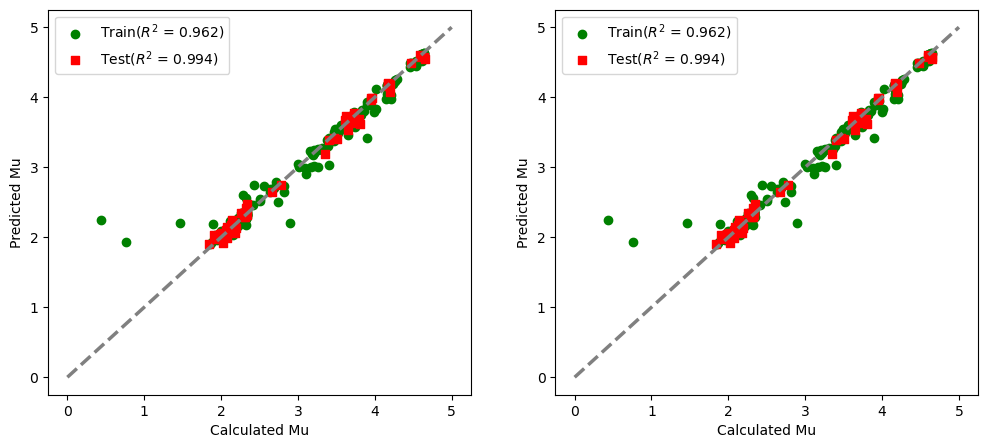

In [112]:
detailed_objective_x2(study_x2_xgb.best_trials[32])

R2 scores (train, CV, test) =  0.9863616122501163 0.8028045851918832 0.9848263667664923
MAE values (train, test) =  0.03931357787409745 0.08764000709823631


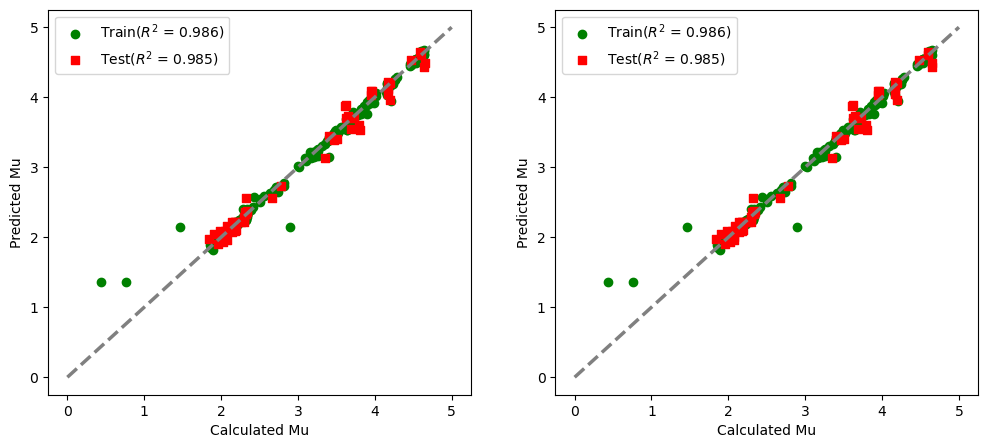

In [110]:
detailed_objective_x2(study_x2_xgb.best_trials[33])

In [176]:
## 52

In [8]:
X3_train_mu,X3_test_mu,y3_train_mu,y3_test_mu = train_test_split(X_mu,y_mu,test_size=0.20,random_state=52)

In [177]:
import optuna
import random

X3_train_mu,X3_test_mu,y3_train_mu,y3_test_mu = train_test_split(X_mu,y_mu,test_size=0.20,random_state=52)

def objective_x3(trial):
    n_estimators = trial.suggest_int('n_estimators',10,150)
    max_depth = trial.suggest_int('max_depth',5,50)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    random_state = 52

    model_x3_xgb = xgb.XGBRegressor(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate,subsample=subsample,
                                     colsample_bytree=colsample_bytree,gamma=gamma,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                                     min_child_weight=min_child_weight,scale_pos_weight=scale_pos_weight,max_delta_step=max_delta_step,
                                     random_state=random_state)

    # Train model
    xgb_mu_optuna_x3 = model_x3_xgb.fit(X3_train_mu,y3_train_mu)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_xgb_mu_optuna_x3 = cross_val_score(xgb_mu_optuna_x3,X3_train_mu,y3_train_mu,cv=cv,scoring='r2',n_jobs=-1)
    avg_r2_cv_xgb_mu_optuna_x3 = cv_scores_xgb_mu_optuna_x3.mean()

    # Return best F1 scores
    r2_train_x3 = r2_score(y3_train_mu, model_x3_xgb.predict(X3_train_mu))
    r2_test_x3 = r2_score(y3_test_mu, model_x3_xgb.predict(X3_test_mu))
#    return avg_r2_cv_xgb_mu_optuna_x3
    return r2_train_x3,avg_r2_cv_xgb_mu_optuna_x3,r2_test_x3

# Run Optuna optimization
#study = optuna.create_study(direction='minimize') # for minimizing loss
study_x3_xgb = optuna.create_study(directions = ['maximize','maximize','maximize']) #(direction='maximize')
study_x3_xgb.optimize(objective_x3, n_trials=300)

[I 2025-03-12 16:37:58,994] A new study created in memory with name: no-name-6470df57-def6-4e1a-a619-32c52de99307
[I 2025-03-12 16:37:59,266] Trial 0 finished with values: [0.7971067112191266, 0.7051231145826866, 0.8137644070410465] and parameters: {'n_estimators': 16, 'max_depth': 30, 'learning_rate': 0.19063264960482723, 'subsample': 0.6304955743850709, 'colsample_bytree': 0.5130453997038793, 'gamma': 7.783972867759087, 'reg_alpha': 0.04031613220549778, 'reg_lambda': 1.3592366790976962e-06, 'min_child_weight': 3, 'scale_pos_weight': 1, 'max_delta_step': 6.256490106647625}.
[I 2025-03-12 16:37:59,576] Trial 1 finished with values: [0.7103893032156092, 0.6577854606564819, 0.7357185000465191] and parameters: {'n_estimators': 67, 'max_depth': 39, 'learning_rate': 0.07369322621638921, 'subsample': 0.502532824151689, 'colsample_bytree': 0.7879086583698378, 'gamma': 6.132872626473934, 'reg_alpha': 0.00020219238410046925, 'reg_lambda': 1.5600622070901537e-07, 'min_child_weight': 5, 'scale_po

In [178]:
best_models_x3 = study_x3_xgb.best_trials
#PRINT('Trial number',
for i in range(len(best_models_x3)):
    print('Model No:',i,'\n=======', '\nTrial No:',best_models_x3[i].number, '\nTrain R2:',best_models_x3[i].values[0],'\nValid R2:',best_models_x3[i].values[1],
         '\nTest  R2:',best_models_x3[i].values[2],'\nParams  :',best_models_x3[i].params,'\n=======')

Model No: 0 
Trial No: 122 
Train R2: 0.9854039476614537 
Valid R2: 0.8186693069949522 
Test  R2: 0.942253013182803 
Params  : {'n_estimators': 136, 'max_depth': 14, 'learning_rate': 0.053861231137864854, 'subsample': 0.8148335432405607, 'colsample_bytree': 0.8963449814789799, 'gamma': 0.10164515933332008, 'reg_alpha': 5.5353137945162065e-06, 'reg_lambda': 2.0783489448817872e-07, 'min_child_weight': 2, 'scale_pos_weight': 1, 'max_delta_step': 9.951902860344987} 
Model No: 1 
Trial No: 128 
Train R2: 0.9228178911289677 
Valid R2: 0.8373098532117629 
Test  R2: 0.9485616879072147 
Params  : {'n_estimators': 102, 'max_depth': 47, 'learning_rate': 0.09398781832321554, 'subsample': 0.624931982701551, 'colsample_bytree': 0.49410716226889506, 'gamma': 0.3409238943810422, 'reg_alpha': 1.737026077783592e-05, 'reg_lambda': 0.0014684547463597716, 'min_child_weight': 10, 'scale_pos_weight': 6, 'max_delta_step': 0.1715565501963512} 
Model No: 2 
Trial No: 144 
Train R2: 0.9557283923601108 
Valid R2:

In [222]:
best_models_x3_pd = pd.DataFrame({'Trial number': [best_models_x3[i].number for i in range(len(best_models_x3))],
                                             'Train R2': [best_models_x3[i].values[0] for i in range(len(best_models_x3))],
                                             'Test R2': [best_models_x3[i].values[2] for i in range(len(best_models_x3))],
                                             'CV R2': [best_models_x3[i].values[1] for i in range(len(best_models_x3))],
                                             'n_estimators': [best_models_x3[i].params['n_estimators'] for i in range(len(best_models_x3))],
                                             'max_depth': [best_models_x3[i].params['max_depth'] for i in range(len(best_models_x3))],
                                             'learning_rate': [best_models_x3[i].params['learning_rate'] for i in range(len(best_models_x3))],
                                             'subsample': [best_models_x3[i].params['subsample'] for i in range(len(best_models_x3))],
                                             'colsample_bytree': [best_models_x3[i].params['colsample_bytree'] for i in range(len(best_models_x3))],
                                             'gamma': [best_models_x3[i].params['gamma'] for i in range(len(best_models_x3))],
                                             'reg_alpha': [best_models_x3[i].params['reg_alpha'] for i in range(len(best_models_x3))],
                                             'reg_lambda': [best_models_x3[i].params['reg_lambda'] for i in range(len(best_models_x3))],
                                             'min_child_weight': [best_models_x3[i].params['min_child_weight'] for i in range(len(best_models_x3))],
                                             'scale_pos_weight': [best_models_x3[i].params['scale_pos_weight'] for i in range(len(best_models_x3))],
                                             'max_delta_step': [best_models_x3[i].params['max_delta_step'] for i in range(len(best_models_x3))]
                                            })
best_models_x3_pd.to_excel('Results_Mu/XGBRegressor_X_52_HP_Optuna.xlsx')

In [219]:
import optuna
import random

#X3_train_mu,X3_test_mu,y3_train_mu,y3_test_mu = train_test_split(X_mu,y_mu,test_size=0.20,random_state=52)

def detailed_objective_x3(trial):
    n_estimators = trial.suggest_int('n_estimators',10,150)
    max_depth = trial.suggest_int('max_depth',5,50)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    random_state = 52

    model_x3_xgb = xgb.XGBRegressor(n_estimators=best_models_x3[0].params['n_estimators'],
                                    max_depth=best_models_x3[0].params['max_depth'],
                                    learning_rate=best_models_x3[0].params['learning_rate'],
                                    subsample=best_models_x3[0].params['subsample'],
                                    colsample_bytree=best_models_x3[0].params['colsample_bytree'],
                                    gamma=best_models_x3[0].params['gamma'],
                                    reg_alpha=best_models_x3[0].params['reg_alpha'],
                                    reg_lambda=best_models_x3[0].params['reg_lambda'],
                                    min_child_weight=best_models_x3[0].params['min_child_weight'],
                                    scale_pos_weight=best_models_x3[0].params['scale_pos_weight'],
                                    max_delta_step=best_models_x3[0].params['max_delta_step'],
                                    random_state=random_state)

    # Train model
    xgb_mu_optuna_x3 = model_x3_xgb.fit(X3_train_mu,y3_train_mu)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_xgb_mu_optuna_x3 = cross_val_score(xgb_mu_optuna_x3,X3_train_mu,y3_train_mu,cv=cv,scoring='r2',n_jobs=-1)
    avg_r2_cv_xgb_mu_optuna_x3 = cv_scores_xgb_mu_optuna_x3.mean()

    # Return best R2 scores and MAE
    r2_train_x3 = r2_score(y3_train_mu, model_x3_xgb.predict(X3_train_mu))
    r2_test_x3 = r2_score(y3_test_mu, model_x3_xgb.predict(X3_test_mu))

    mae_train_x3 = mean_absolute_error(y3_train_mu, model_x3_xgb.predict(X3_train_mu))
    mae_test_x3 = mean_absolute_error(y3_test_mu, model_x3_xgb.predict(X3_test_mu))
    
    print('R2 scores (train, CV, test) = ', r2_train_x3,avg_r2_cv_xgb_mu_optuna_x3,r2_test_x3)
    print('MAE values (train, test) = ', mae_train_x3,mae_test_x3)

    ## Exporting the results
    y3_pred_train_mu = model_x3_xgb.predict(X3_train_mu)
    y3_pred_test_mu = model_x3_xgb.predict(X3_test_mu)

    X3_train_mu.to_excel('Results_Mu/X_52_train_Optuna.xlsx',index=False)
    X3_test_mu.to_excel('Results_Mu/X_52_test_Optuna.xlsx',index=False)      
    
    y3_train_mu.to_excel('Results_Mu/y_52_train_Optuna.xlsx',index=False)
    y3_test_mu.to_excel('Results_Mu/y_52_test_Optuna.xlsx',index=False)      
    
    pd.DataFrame(y3_pred_train_mu).to_excel('Results_Mu/y_52_pred_train_Optuna_0.xlsx',index=False)
    pd.DataFrame(y3_pred_test_mu).to_excel('Results_Mu/y_52_pred_test_Optuna_0.xlsx',index=False)    

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    ax1.scatter(y3_train_mu, model_x3_xgb.predict(X3_train_mu).flatten(),label='Train($R^2$ = '+str(f'{r2_train_x3:.3f}')+')',marker='o',color='green')
#    ax1.scatter(y3_val, model_x3_xgb.predict(X3_val).flatten(),label='Val($R^2$ = '+str(f'{avg_r2_cv_xgb_mu_optuna_x3:.3f}')+')',marker='^',color='blue')
    ax1.scatter(y3_test_mu, model_x3_xgb.predict(X3_test_mu).flatten(),label='Test($R^2$ = '+str(f'{r2_test_x3:.3f}')+')',marker='s',color='red')
    ax1.set_xlabel('Calculated Mu')
    ax1.set_ylabel('Predicted Mu')
    ax1.plot([0,5], [0,5],linewidth=2.5, color='gray', linestyle='dashed')
    ax1.legend()
    
    ax2.scatter(y3_train_mu, model_x3_xgb.predict(X3_train_mu).flatten(),label='Train($R^2$ = '+str(f'{r2_train_x3:.3f}')+')',marker='o',color='green')
    ax2.scatter(y3_test_mu, model_x3_xgb.predict(X3_test_mu).flatten(),label='Test($R^2$ = '+str(f'{r2_test_x3:.3f}')+')',marker='s',color='red')
    ax2.set_xlabel('Calculated Mu')
    ax2.set_ylabel('Predicted Mu')
    ax2.plot([0,5], [0,5],linewidth=2.5, color='gray', linestyle='dashed')
    ax2.legend()
    
    plt.show()

R2 scores (train, CV, test) =  0.9854039476614537 0.8186693069949522 0.942253013182803
MAE values (train, test) =  0.06224113994645313 0.12925012995941465


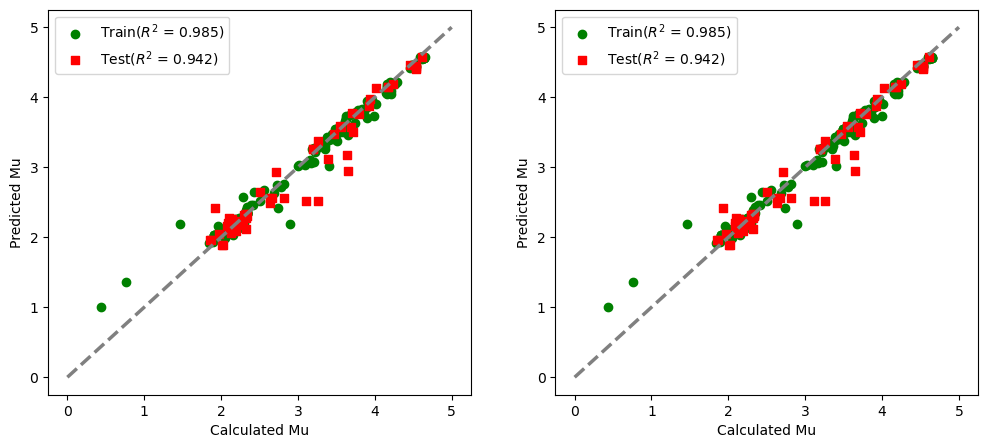

In [220]:
detailed_objective_x3(study_x3_xgb.best_trials[0])

R2 scores (train, CV, test) =  0.9228178911289677 0.8373098532117629 0.9485616879072147
MAE values (train, test) =  0.12321654641502694 0.14694845526662428


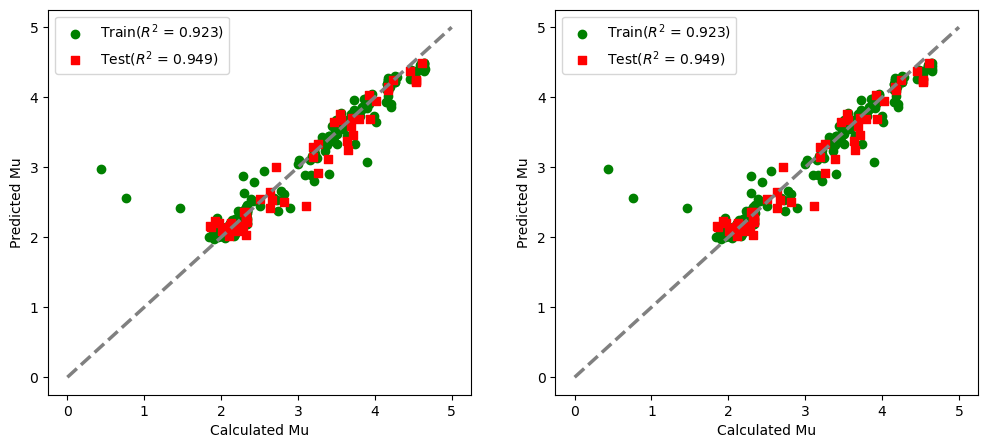

In [218]:
detailed_objective_x3(study_x3_xgb.best_trials[1])

R2 scores (train, CV, test) =  0.9557283923601108 0.8370953959323776 0.9467779709835797
MAE values (train, test) =  0.08989598730551486 0.14401285983306436


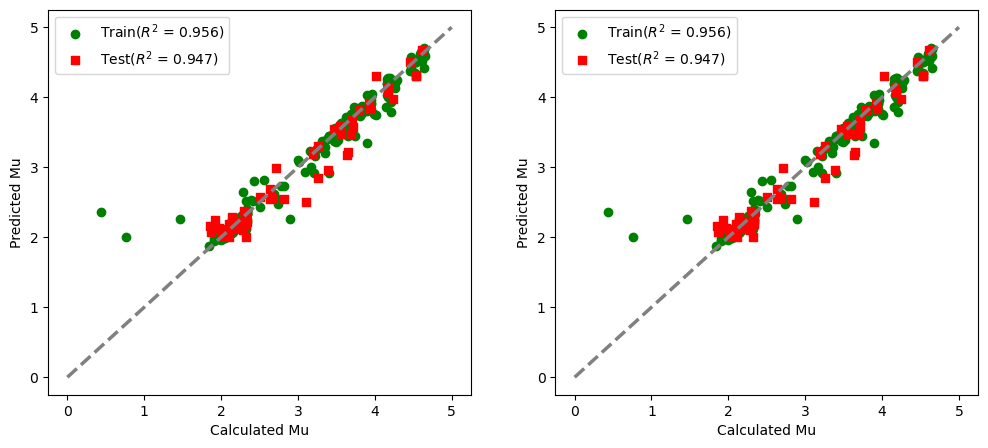

In [216]:
detailed_objective_x3(study_x3_xgb.best_trials[2])

R2 scores (train, CV, test) =  0.9844999012510889 0.8161523603447879 0.9501342614878023
MAE values (train, test) =  0.06292343433210731 0.11200452953960056


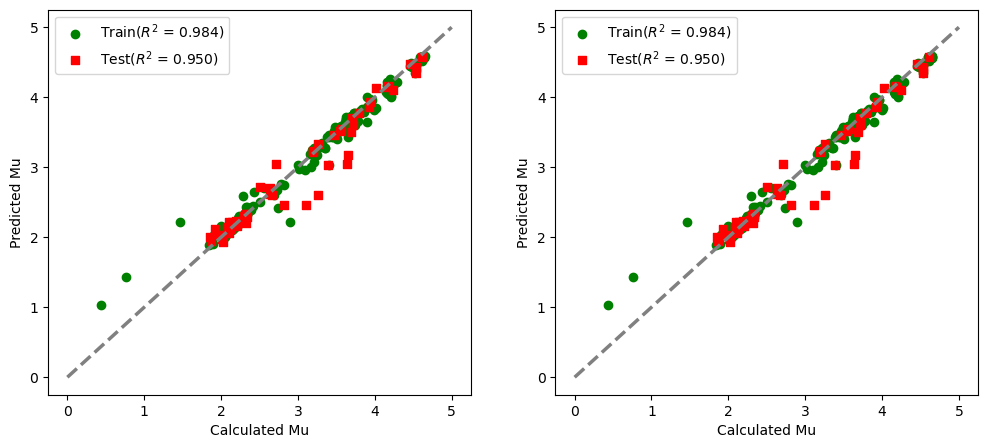

In [214]:
detailed_objective_x3(study_x3_xgb.best_trials[3])

R2 scores (train, CV, test) =  0.9844999012510889 0.8161523603447879 0.9501342614878023
MAE values (train, test) =  0.06292343433210731 0.11200452953960056


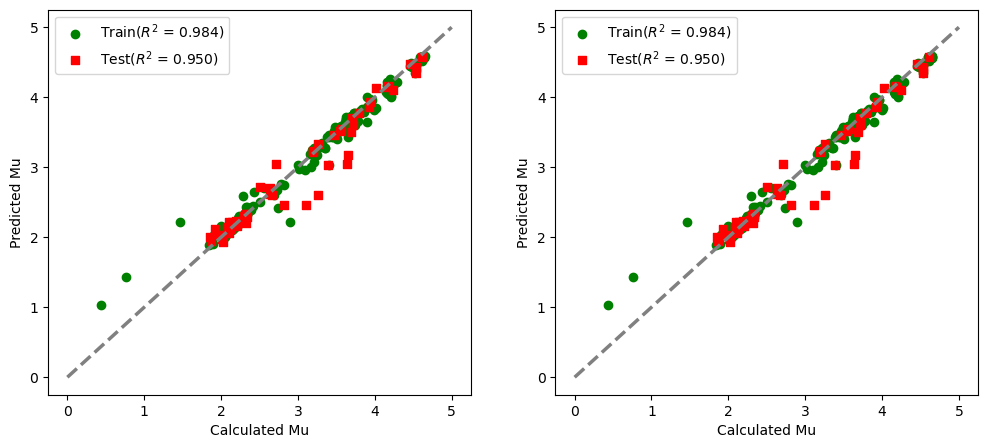

In [213]:
detailed_objective_x3(study_x3_xgb.best_trials[4])

R2 scores (train, CV, test) =  0.9284935752332819 0.8389429813392946 0.9483777657688991
MAE values (train, test) =  0.12090240452971938 0.14153106302643476


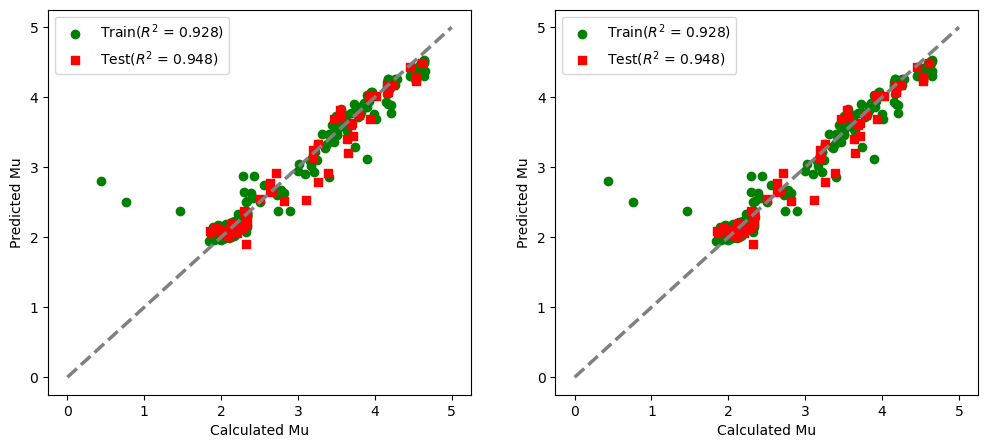

In [211]:
detailed_objective_x3(study_x3_xgb.best_trials[5])

R2 scores (train, CV, test) =  0.9854039476614537 0.8186693069949522 0.942253013182803
MAE values (train, test) =  0.06224113994645313 0.12925012995941465


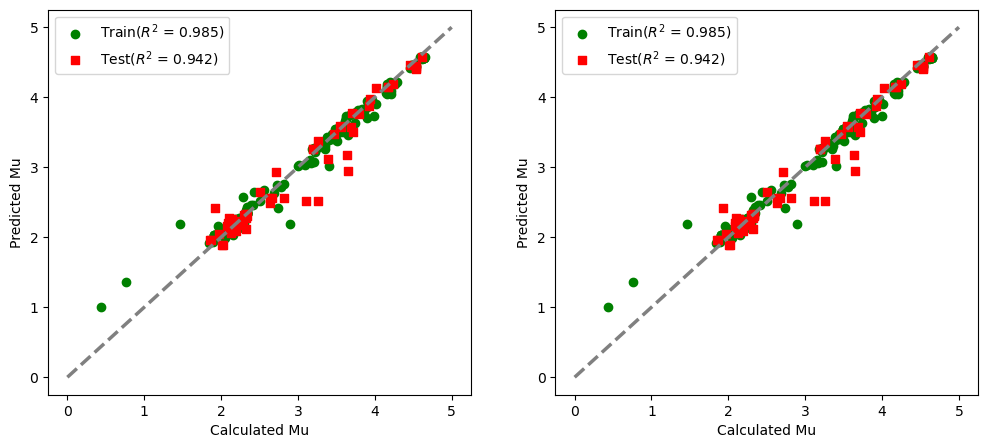

In [209]:
detailed_objective_x3(study_x3_xgb.best_trials[6])

R2 scores (train, CV, test) =  0.9835240710046089 0.8174770833784418 0.9442427760295962
MAE values (train, test) =  0.06569795293742846 0.13989833802446502


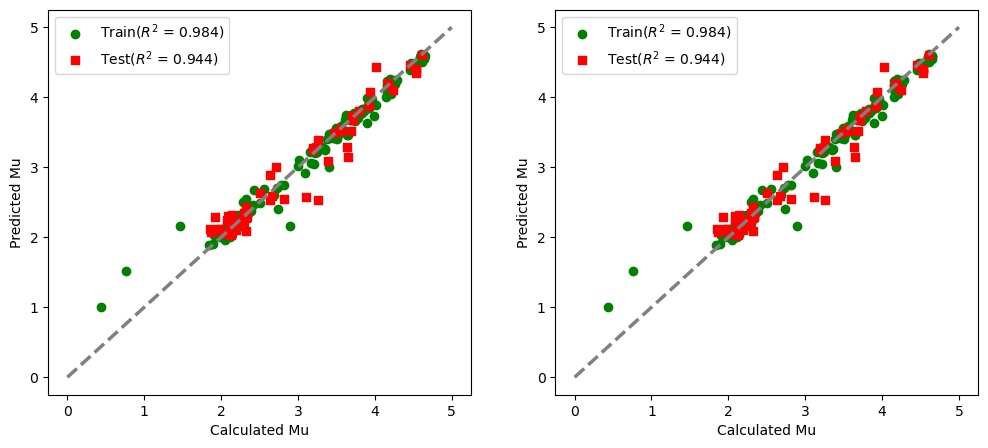

In [207]:
detailed_objective_x3(study_x3_xgb.best_trials[7])

R2 scores (train, CV, test) =  0.9407500323986541 0.8365104528939316 0.9471314290165438
MAE values (train, test) =  0.10479729486979661 0.13108224767450433


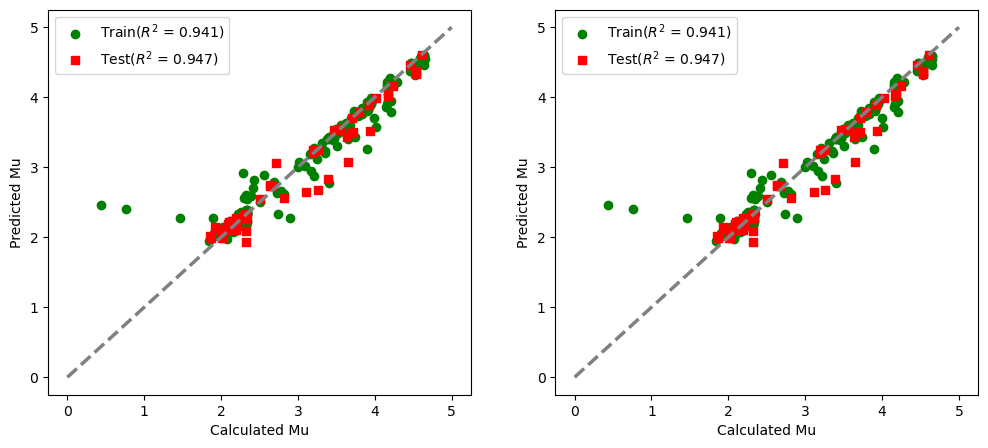

In [205]:
detailed_objective_x3(study_x3_xgb.best_trials[8])

R2 scores (train, CV, test) =  0.983011425031853 0.8211685793418788 0.9315907683426522
MAE values (train, test) =  0.07042640084871812 0.14867865556804988


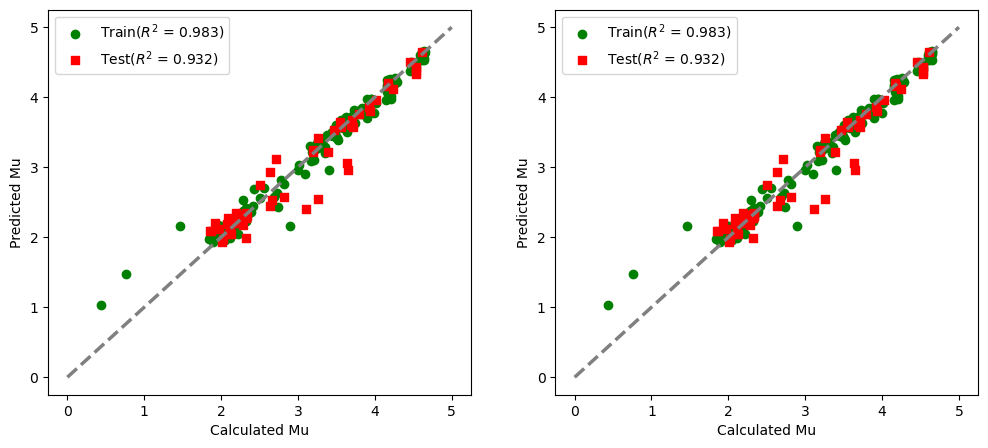

In [203]:
detailed_objective_x3(study_x3_xgb.best_trials[9])

R2 scores (train, CV, test) =  0.9655165079689818 0.8366833749140439 0.9464517061724181
MAE values (train, test) =  0.08296906766047822 0.1268357448684562


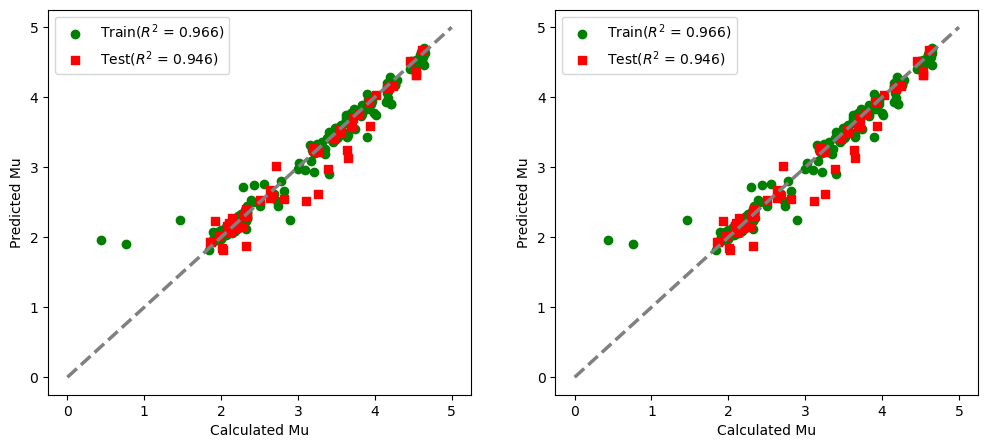

In [201]:
detailed_objective_x3(study_x3_xgb.best_trials[10])

R2 scores (train, CV, test) =  0.9819441524445874 0.8216119036806179 0.9471155972441035
MAE values (train, test) =  0.06751282447173733 0.11838067213283227


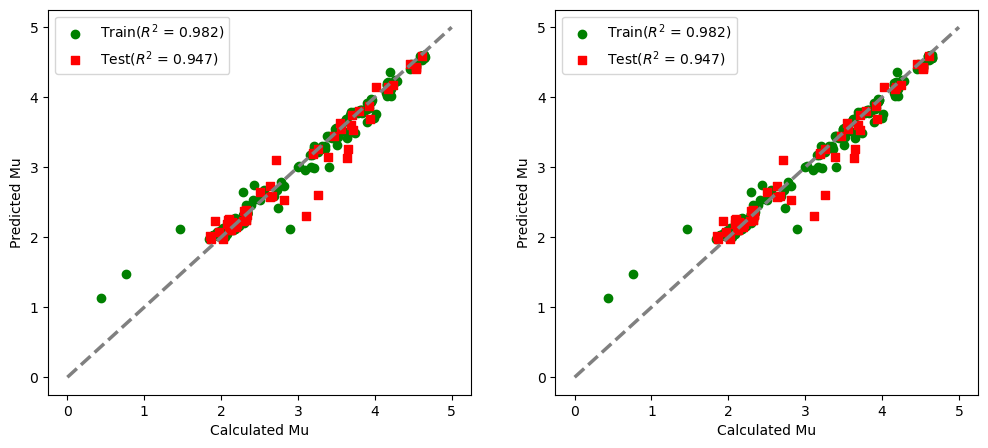

In [199]:
detailed_objective_x3(study_x3_xgb.best_trials[11])

R2 scores (train, CV, test) =  0.9839316058536804 0.8209813203713654 0.9421280528798841
MAE values (train, test) =  0.06619080854653035 0.1287354428530518


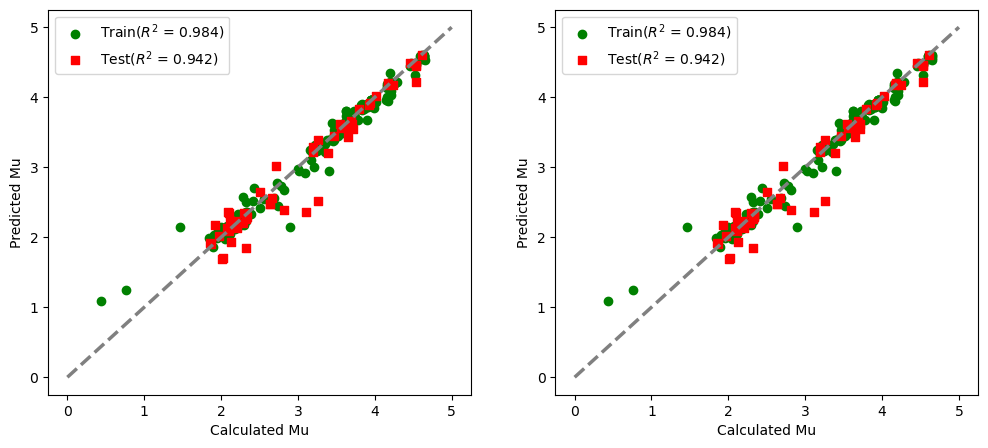

In [197]:
detailed_objective_x3(study_x3_xgb.best_trials[12])

R2 scores (train, CV, test) =  0.9577028997261815 0.8428279641243842 0.9426574581378719
MAE values (train, test) =  0.08890904080573514 0.14240491750594325


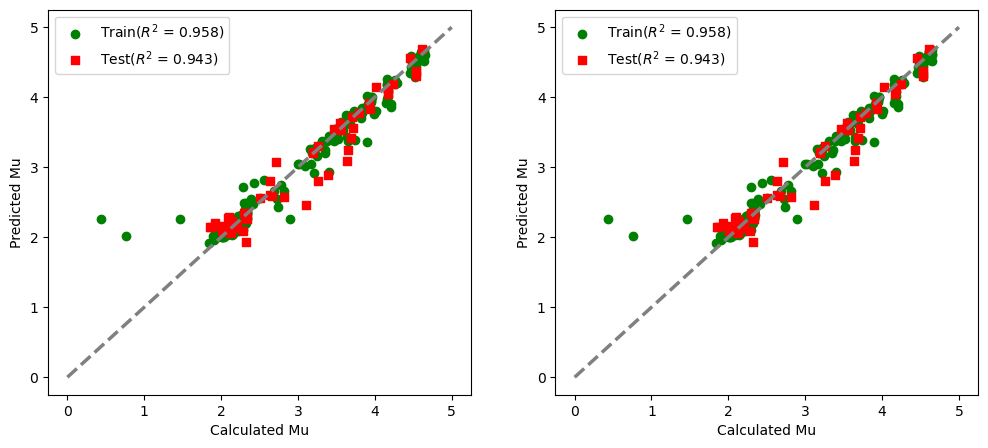

In [195]:
detailed_objective_x3(study_x3_xgb.best_trials[13])

R2 scores (train, CV, test) =  0.9657138488214051 0.8358899440880224 0.9508628623479283
MAE values (train, test) =  0.08325440832485949 0.13159795827496817


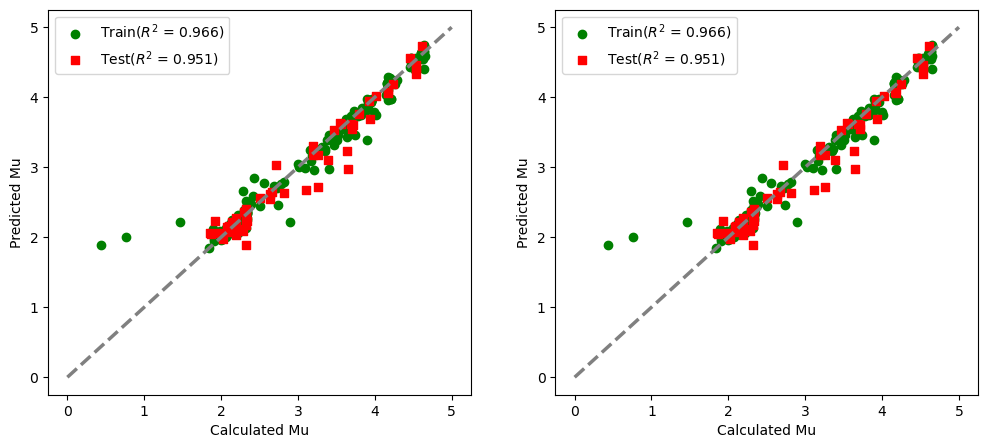

In [193]:
detailed_objective_x3(study_x3_xgb.best_trials[14])

R2 scores (train, CV, test) =  0.9653532888657762 0.8344361293063697 0.9547033927649624
MAE values (train, test) =  0.0911570563163344 0.12519329984582425


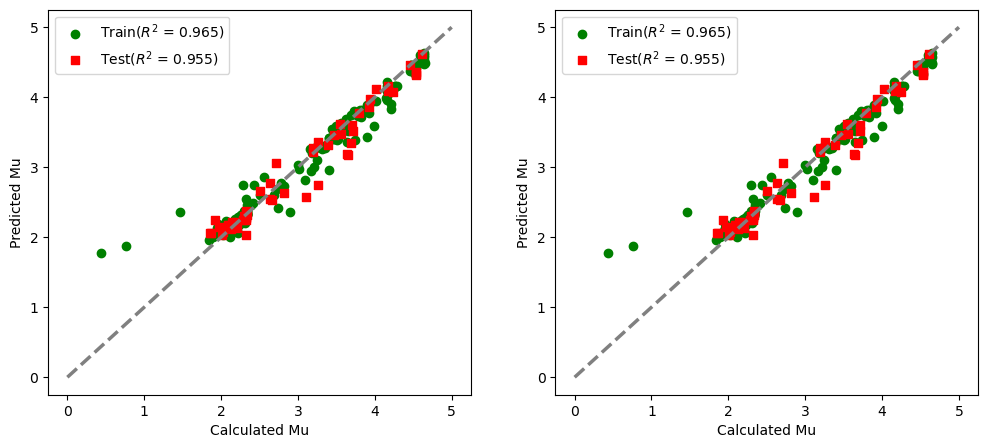

In [191]:
detailed_objective_x3(study_x3_xgb.best_trials[15])

R2 scores (train, CV, test) =  0.986483191148481 0.8027299909837684 0.9586565748921327
MAE values (train, test) =  0.06150319946390957 0.09771938117123471


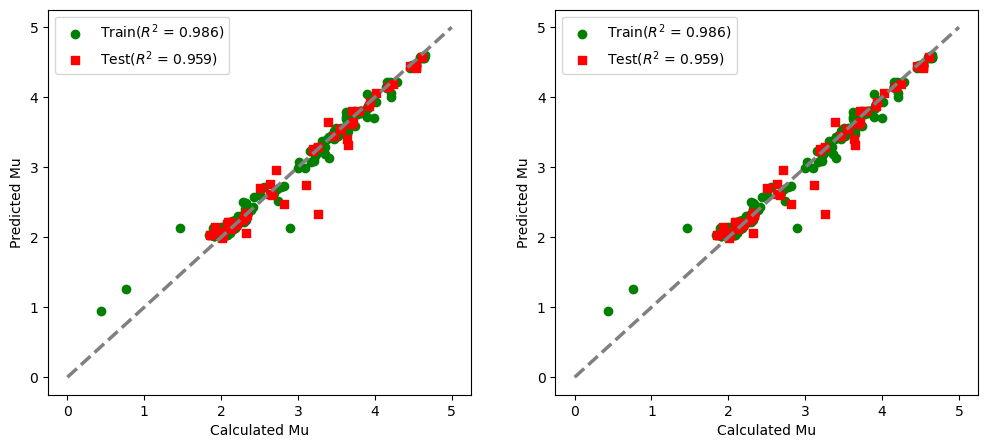

In [189]:
detailed_objective_x3(study_x3_xgb.best_trials[16])

R2 scores (train, CV, test) =  0.9844833016124517 0.8151403166418486 0.950622133952839
MAE values (train, test) =  0.06220249586770135 0.1194405191214069


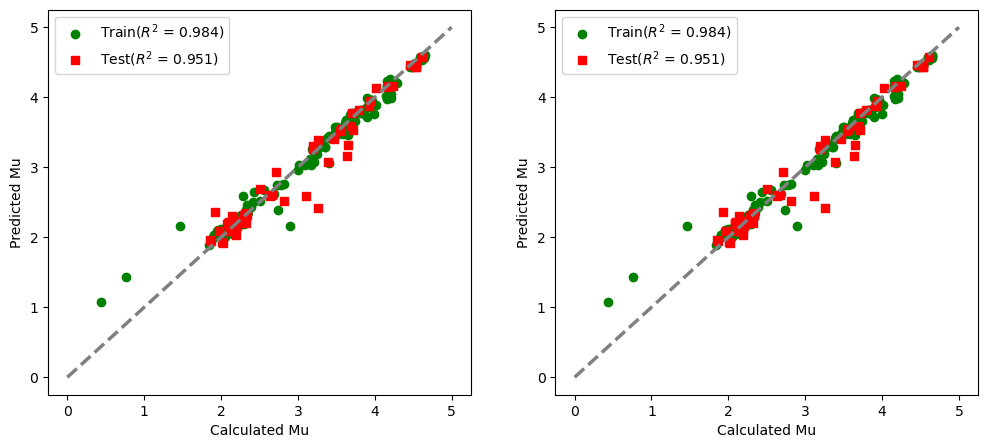

In [187]:
detailed_objective_x3(study_x3_xgb.best_trials[17])

R2 scores (train, CV, test) =  0.9829402792589375 0.8186389274856204 0.9500108550120441
MAE values (train, test) =  0.06838848134224587 0.1262966611595738


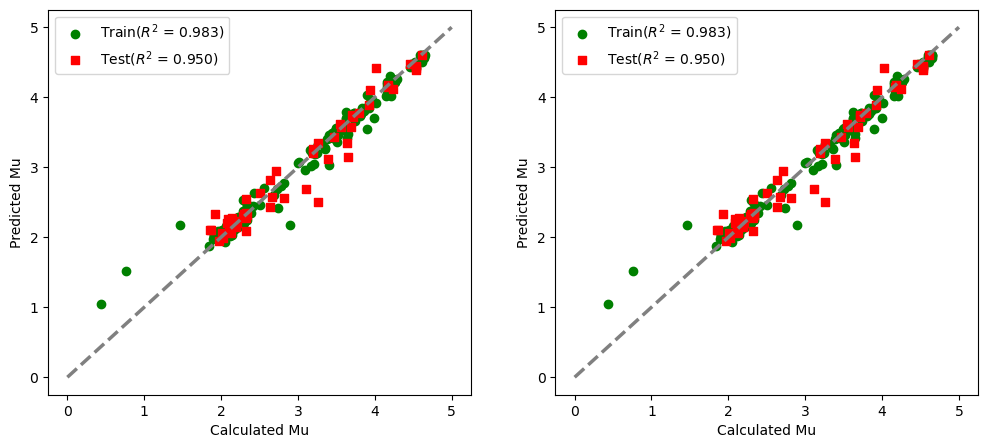

In [185]:
detailed_objective_x3(study_x3_xgb.best_trials[18])

R2 scores (train, CV, test) =  0.9643488360669906 0.8390252031458685 0.9398854905098224
MAE values (train, test) =  0.08683716662382138 0.14661209651786214


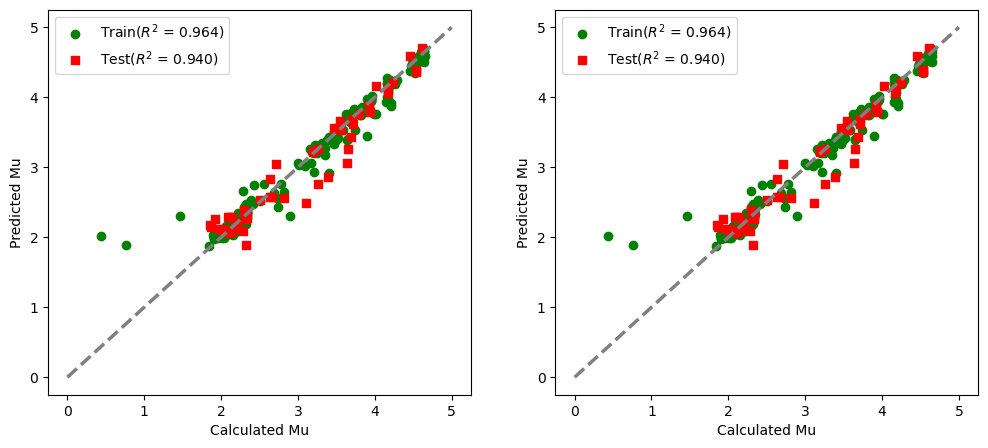

In [183]:
detailed_objective_x3(study_x3_xgb.best_trials[19])

In [221]:
## Feature importances

In [269]:
import optuna
import random

#X3_train_mu,X3_test_mu,y3_train_mu,y3_test_mu = train_test_split(X_mu,y_mu,test_size=0.20,random_state=52)

def detailed_objective_x3_best(trial):
    n_estimators = trial.suggest_int('n_estimators',10,150)
    max_depth = trial.suggest_int('max_depth',5,50)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    random_state = 52

    model_x3_xgb = xgb.XGBRegressor(n_estimators=best_models_x3[12].params['n_estimators'],
                                    max_depth=best_models_x3[12].params['max_depth'],
                                    learning_rate=best_models_x3[12].params['learning_rate'],
                                    subsample=best_models_x3[12].params['subsample'],
                                    colsample_bytree=best_models_x3[12].params['colsample_bytree'],
                                    gamma=best_models_x3[12].params['gamma'],
                                    reg_alpha=best_models_x3[12].params['reg_alpha'],
                                    reg_lambda=best_models_x3[12].params['reg_lambda'],
                                    min_child_weight=best_models_x3[12].params['min_child_weight'],
                                    scale_pos_weight=best_models_x3[12].params['scale_pos_weight'],
                                    max_delta_step=best_models_x3[12].params['max_delta_step'],
                                    random_state=random_state)

    # Train model
    xgb_mu_optuna_x3 = model_x3_xgb.fit(X3_train_mu,y3_train_mu)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_xgb_mu_optuna_x3 = cross_val_score(xgb_mu_optuna_x3,X3_train_mu,y3_train_mu,cv=cv,scoring='r2',n_jobs=-1)
    avg_r2_cv_xgb_mu_optuna_x3 = cv_scores_xgb_mu_optuna_x3.mean()

    # Return best R2 scores and MAE
    r2_train_x3 = r2_score(y3_train_mu, model_x3_xgb.predict(X3_train_mu))
    r2_test_x3 = r2_score(y3_test_mu, model_x3_xgb.predict(X3_test_mu))

    mae_train_x3 = mean_absolute_error(y3_train_mu, model_x3_xgb.predict(X3_train_mu))
    mae_test_x3 = mean_absolute_error(y3_test_mu, model_x3_xgb.predict(X3_test_mu))
    
    print('R2 scores (train, CV, test) = ', r2_train_x3,avg_r2_cv_xgb_mu_optuna_x3,r2_test_x3)
    print('MAE values (train, test) = ', mae_train_x3,mae_test_x3)

    ## Exporting the results
    y3_pred_train_mu = model_x3_xgb.predict(X3_train_mu)
    y3_pred_test_mu = model_x3_xgb.predict(X3_test_mu)

    X3_train_mu.to_excel('Results_Mu/X_52_train_Optuna.xlsx',index=False)
    X3_test_mu.to_excel('Results_Mu/X_52_test_Optuna.xlsx',index=False)      
    
    y3_train_mu.to_excel('Results_Mu/y_52_train_Optuna.xlsx',index=False)
    y3_test_mu.to_excel('Results_Mu/y_52_test_Optuna.xlsx',index=False)      
    
    pd.DataFrame(y3_pred_train_mu).to_excel('Results_Mu/y_52_pred_train_Optuna_12_best.xlsx',index=False)
    pd.DataFrame(y3_pred_test_mu).to_excel('Results_Mu/y_52_pred_test_Optuna_12_best.xlsx',index=False)    

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    ax1.scatter(y3_train_mu, model_x3_xgb.predict(X3_train_mu).flatten(),label='Train($R^2$ = '+str(f'{r2_train_x3:.3f}')+')',marker='o',color='green')
    ax1.scatter(y3_test_mu, model_x3_xgb.predict(X3_test_mu).flatten(),label='Test($R^2$ = '+str(f'{r2_test_x3:.3f}')+')',marker='s',color='red')
    ax1.set_xlabel('Calculated Mu')
    ax1.set_ylabel('Predicted Mu')
    ax1.plot([0,5], [0,5],linewidth=2.5, color='gray', linestyle='dashed')
    ax1.legend()
    
    importances_xgb_mu = model_x3_xgb.feature_importances_
    indices_xgb_mu = np.argsort(importances_xgb_mu)[::-1]
    ax2.bar(range(6), importances_xgb_mu[indices_xgb_mu][:6], align='center')
    desc_labels_mu = df_mu.columns[:]
    ax2.set_xticks(range(6), desc_labels_mu[indices_xgb_mu][:6],  rotation=90)
    ax2.set_xlim([-0.5, 5.5])
    ax2.set_ylabel('Feature Importance')
    ax2.set_xlabel('Descriptors')
    plt.show()

    fig,(ax3,ax4) = plt.subplots(1,2,figsize=(12,5))
    ax3.bar(range(8), importances_xgb_mu[indices_xgb_mu][:8], align='center')
    desc_labels_mu = df_mu.columns[:]
    ax3.set_xticks(range(8), desc_labels_mu[indices_xgb_mu][:8],  rotation=90)
    ax3.set_xlim([-0.5, 7.5])
    ax3.set_ylabel('Feature Importance')
    ax3.set_xlabel('Descriptors')

    ax4.bar(range(12), importances_xgb_mu[indices_xgb_mu][:12], align='center')
    desc_labels_mu = df_mu.columns[:]
    ax4.set_xticks(range(12), desc_labels_mu[indices_xgb_mu][:12],  rotation=90)
    ax4.set_xlim([-0.5, 11.5])
    ax4.set_ylabel('Feature Importance')
    ax4.set_xlabel('Descriptors')
    plt.show()

    plt.figure(figsize=(20,10))
    plt.bar(range(X3_train_mu.shape[1]), importances_xgb_mu[indices_xgb_mu], align='center')
    desc_labels_mu = df_mu.columns[:]
    plt.xticks(range(X3_train_mu.shape[1]), desc_labels_mu[indices_xgb_mu],  rotation=90)
    plt.xlim([-1, X3_train_mu.shape[1]])
    plt.ylabel('Feature Importance')
    plt.xlabel('Descriptors')
    plt.show()

    fig,ax = plt.subplots(nrows = 5, ncols = 3,figsize = (18,30))
    nrows = 5
    ncols = 3
    count = 0
    for i in range(nrows):
        for j in range(ncols):
            
            ax[i,j].scatter(df_mu[desc_labels_mu[indices_xgb_mu][count]],df['Mu_per_cell'])
            ax[i,j].set_xlabel(''), ax[i,j].set_ylabel('Mu_per_cell'), ax[i,j].set_title(desc_labels_mu[indices_xgb_mu][count])
            
            count = count+1
    
    plt.show()

R2 scores (train, CV, test) =  0.9839316058536804 0.8209813203713654 0.9421280528798841
MAE values (train, test) =  0.06619080854653035 0.1287354428530518


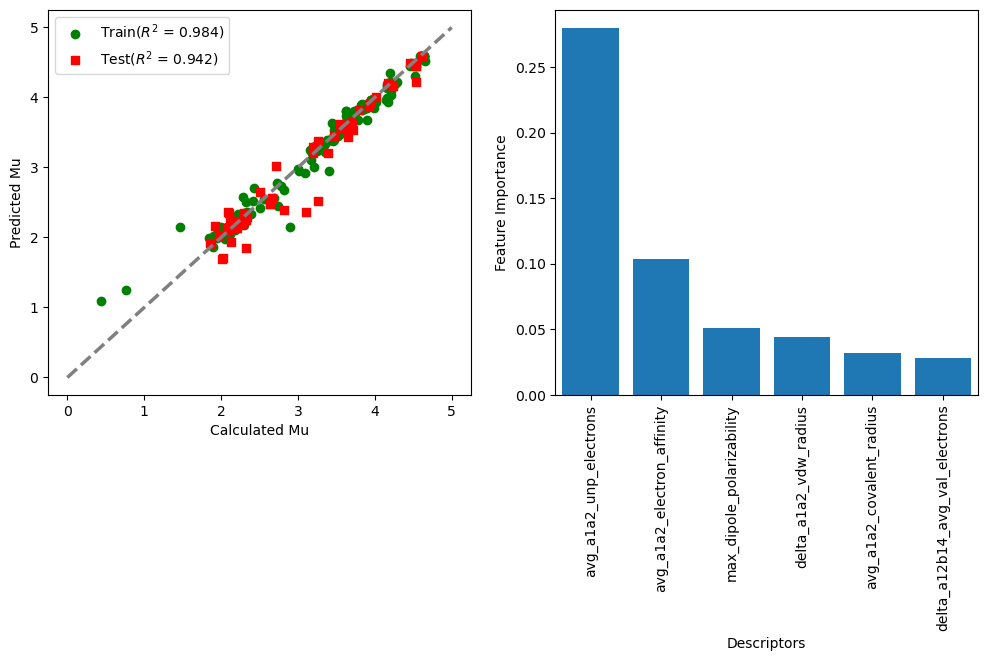

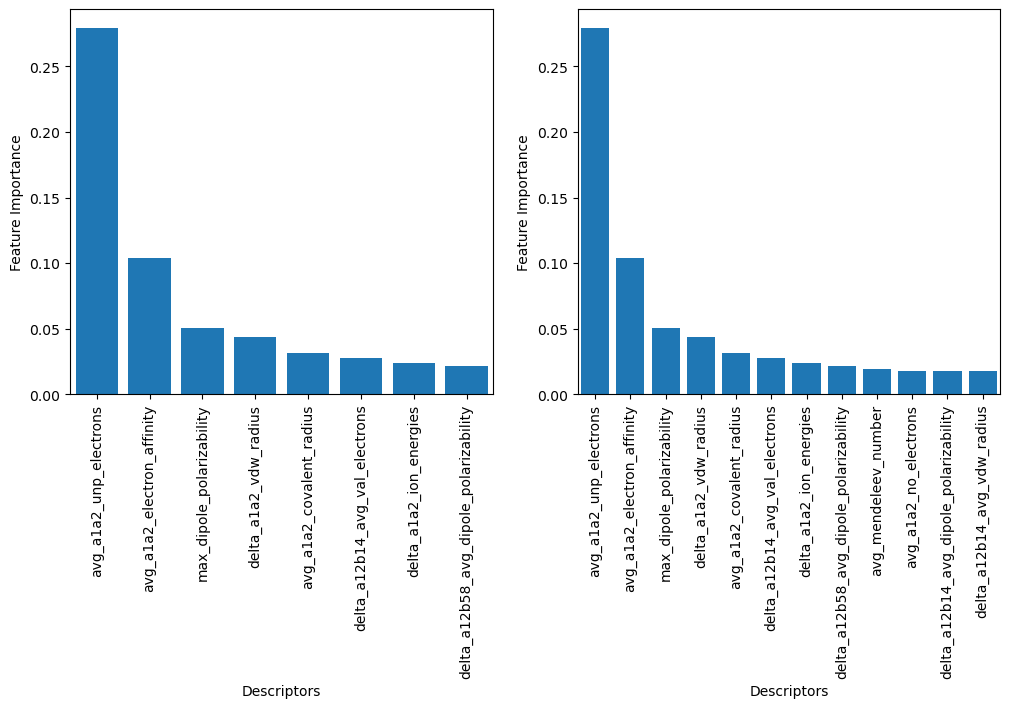

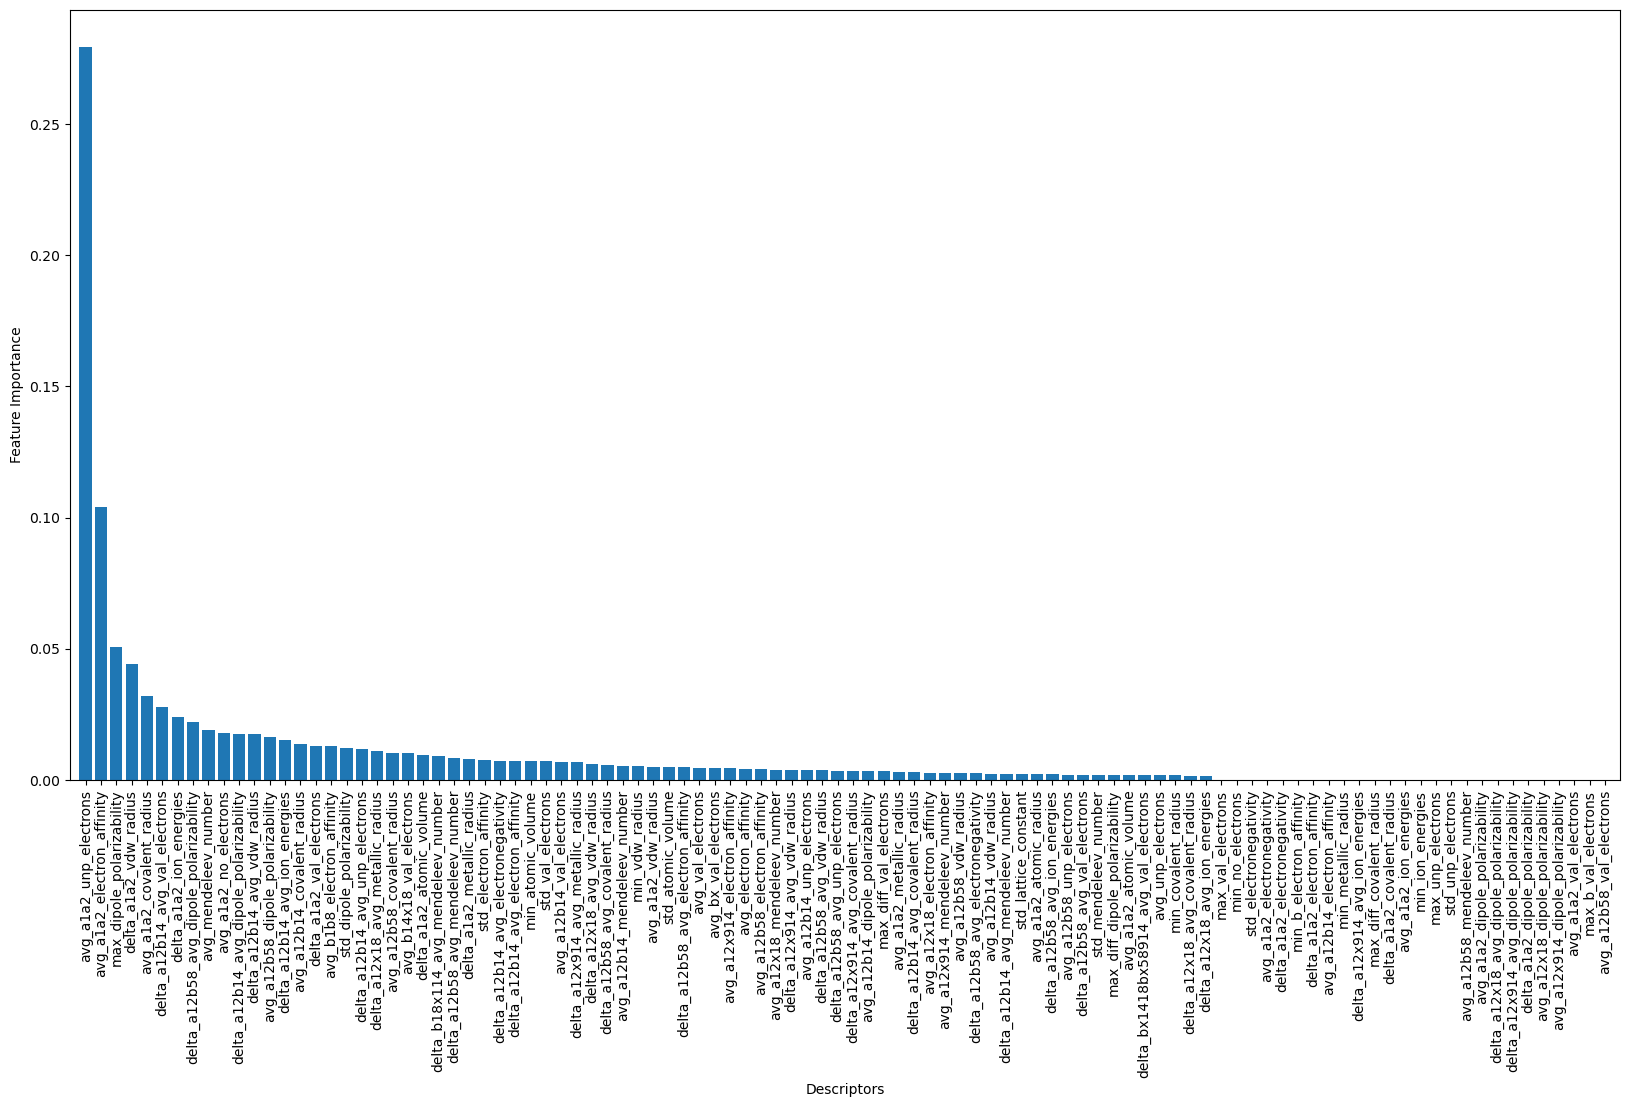

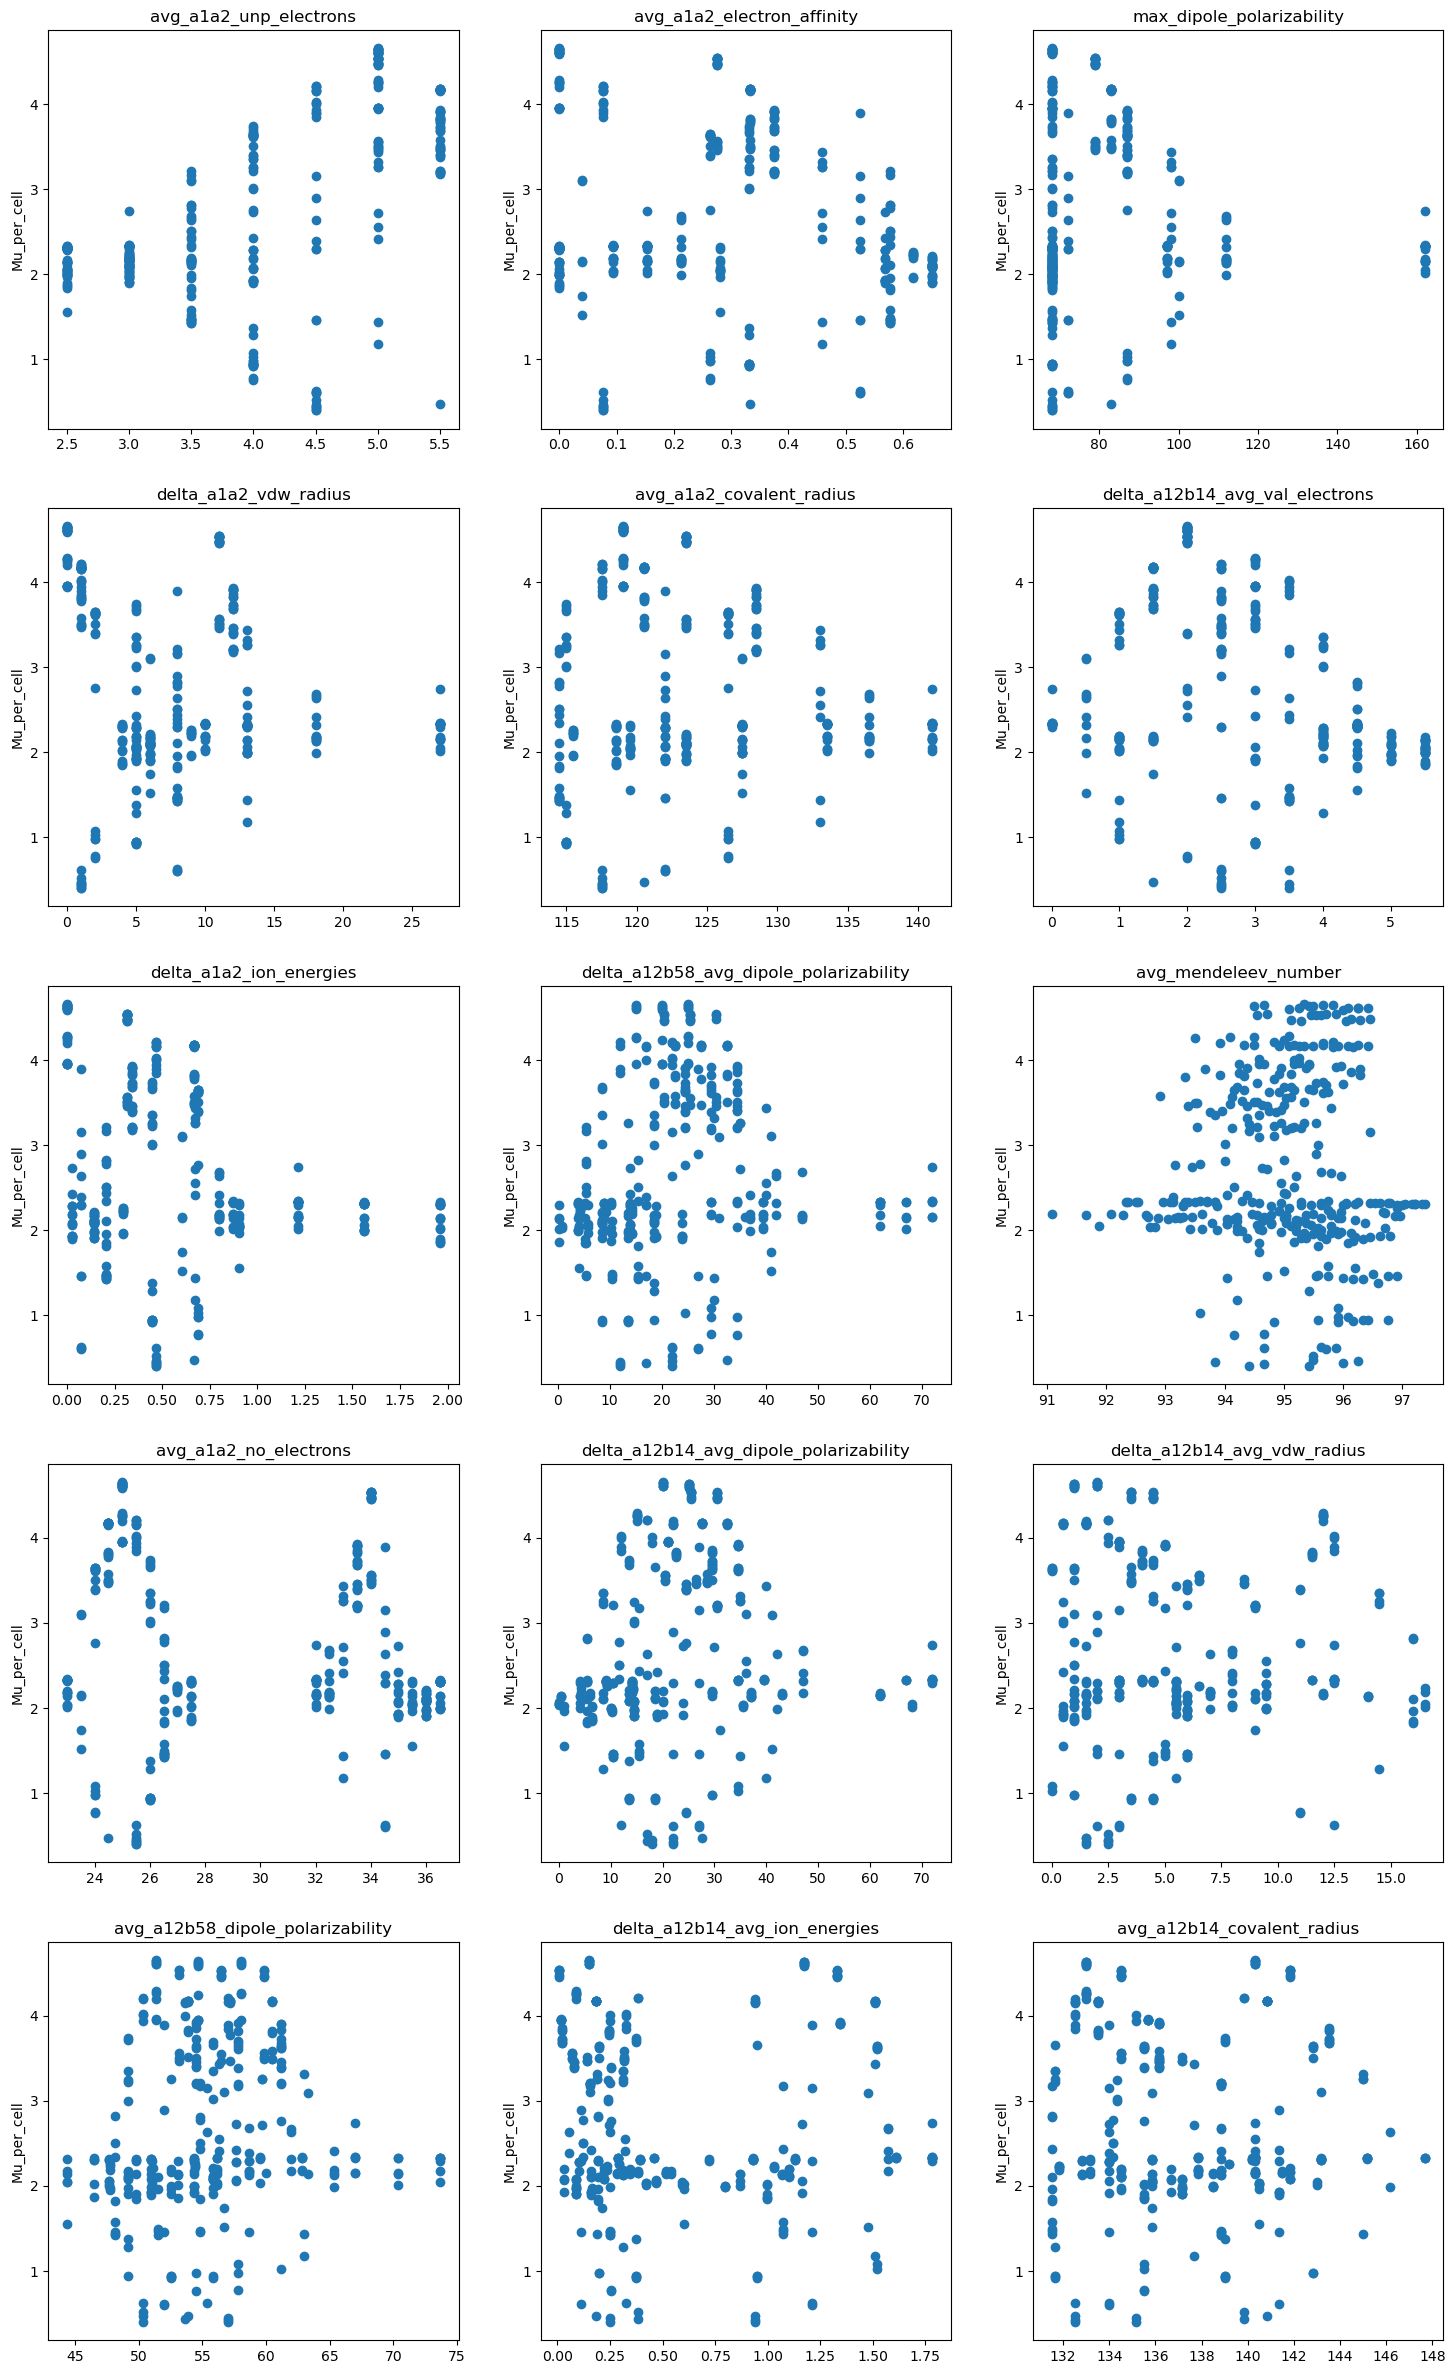

In [270]:
detailed_objective_x3_best(study_x3_xgb.best_trials[12])

In [277]:
## Backward features elimination

In [279]:
xgb_mu_be_x3 = xgb.XGBRegressor(random_state=52)
cv = KFold(n_splits=10,shuffle=True,random_state=52)
n_features = X3_train_mu.shape[1]

xgb_mu_sfs_x3 = sfs(xgb_mu_be_x3,forward=False,k_features=(1,n_features),scoring='r2',cv=cv,verbose=2,n_jobs=1)

xgb_mu_sfs_x3 = xgb_mu_sfs_x3.fit(X3_train_mu, y3_train_mu)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   43.5s

[2025-03-13 16:50:54] Features: 99/1 -- score: 0.7942271756669703[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   42.7s

[2025-03-13 16:52:38] Features: 98/1 -- score: 0.7997042985545291[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   41.1s

[2025-03-13 16:54:22] Features: 97/1 -- score: 0.8039865271839182[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   41.5s

[2025-03-13 16:56:03] Features: 96/1 -- score: 0.8076176892316607[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   41.5s

[2025-03-13 16:57:43] Features: 95/1 -- score: 0.8101591407921346[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   39.8s

[2025-03-13 16:59:20] Features: 94/1 -- score: 0.8138348326899253[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   40.3s

[2025-03-13 17:00:54] Features: 93/1 -- score: 0.8179603527280916[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   40.6s

[2025-03-13 17:02:27] Features: 92/1 -- score: 0.

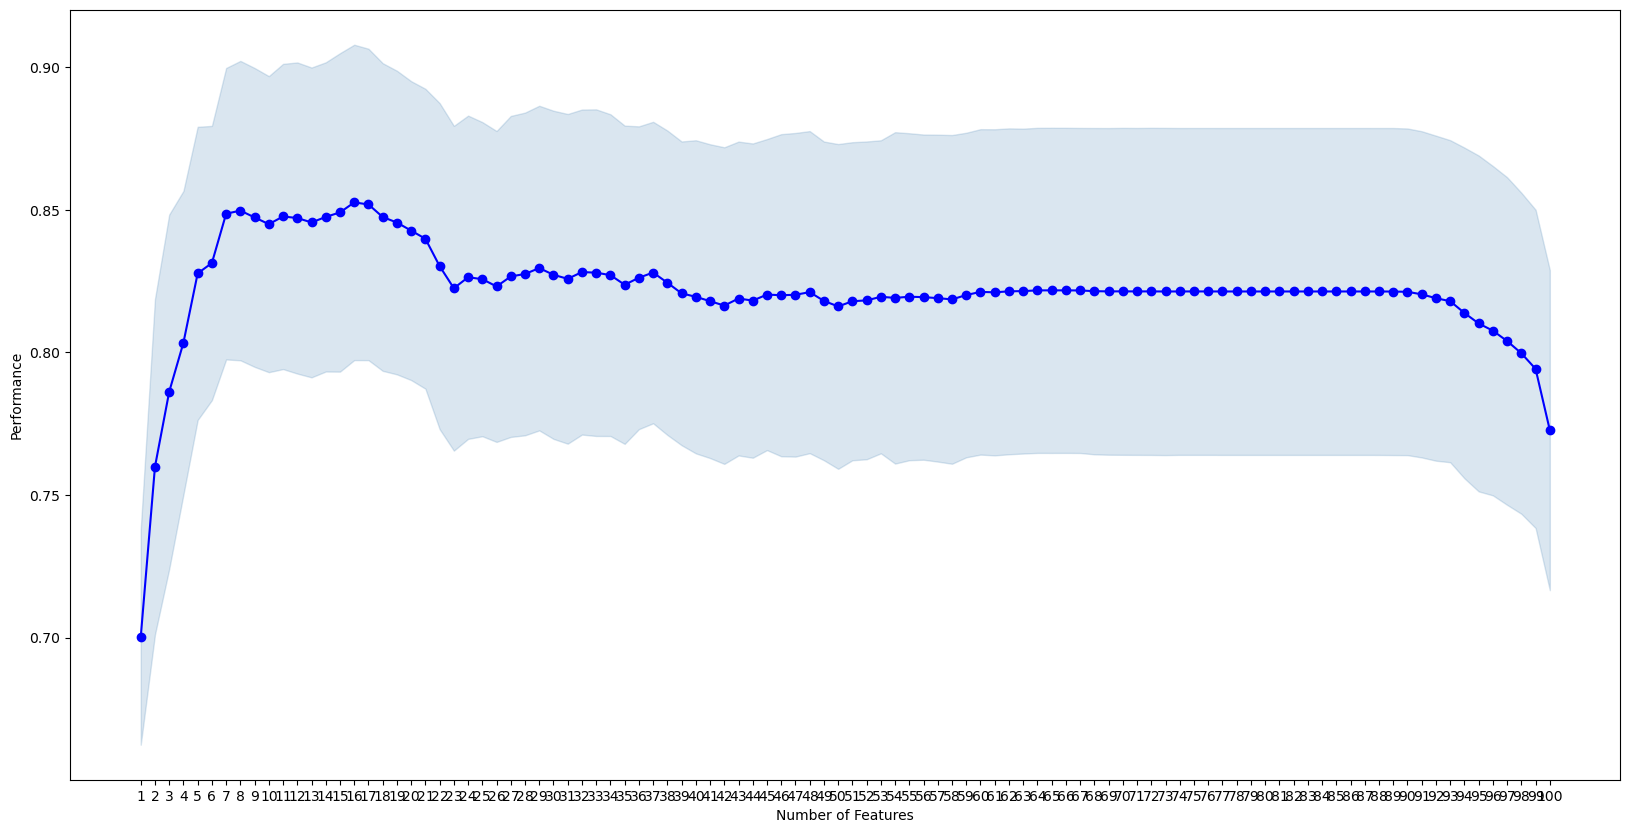

In [282]:
fig = plot_sfs(xgb_mu_sfs_x3.get_metric_dict(),kind='std_err',figsize=(20,10))
plt.show()

In [284]:
xgb_mu_sfs_x3.k_score_

0.852596960904504

In [285]:
xgb_mu_sfs_x3.k_feature_idx_

(2, 12, 14, 17, 47, 54, 55, 56, 57, 64, 67, 70, 76, 78, 91, 94)

In [286]:
xgb_mu_sfs_x3.k_feature_names_

('delta_a12x18_avg_vdw_radius',
 'delta_a12x914_avg_covalent_radius',
 'delta_a12b58_avg_covalent_radius',
 'avg_a12b58_covalent_radius',
 'delta_a1a2_val_electrons',
 'avg_a1a2_unp_electrons',
 'delta_a12b14_avg_unp_electrons',
 'delta_a12b58_avg_unp_electrons',
 'avg_a12b14_unp_electrons',
 'delta_a12b58_avg_ion_energies',
 'avg_a1a2_no_electrons',
 'delta_a12b14_avg_electronegativity',
 'avg_a1a2_electron_affinity',
 'delta_a12b14_avg_electron_affinity',
 'std_mendeleev_number',
 'delta_a12b58_avg_mendeleev_number')

In [290]:
X3_mu_be_xgb = X_mu[[i for i in xgb_mu_sfs_x3.k_feature_names_]]
X3_train_mu_be_xgb = X3_train_mu[[i for i in xgb_mu_sfs_x3.k_feature_names_]]
X3_test_mu_be_xgb = X3_test_mu[[i for i in xgb_mu_sfs_x3.k_feature_names_]]

In [291]:
def find_extra_element(tuple1,tuple2):
    set1 = set(tuple1)
    set2 = set(tuple2)
    
    extra_element = (set1 - set2).pop()
    return extra_element

for i in range(len(xgb_mu_sfs_x3.get_metric_dict())):
    j = i+1
    if j==X_mu.shape[1]:
        eliminated_feature_index = 'None'
        eliminated_feature = 'None'
    else:
        eliminated_feature_index = find_extra_element(xgb_mu_sfs_x3.get_metric_dict()[j+1]['feature_idx'],xgb_mu_sfs_x3.get_metric_dict()[j]['feature_idx'])
        eliminated_feature = X_mu.columns[eliminated_feature_index]
    print(j,eliminated_feature_index,eliminated_feature,xgb_mu_sfs_x3.get_metric_dict()[j]['avg_score'],xgb_mu_sfs_x3.get_metric_dict()[j]['ci_bound'],xgb_mu_sfs_x3.get_metric_dict()[j]['std_dev'],xgb_mu_sfs_x3.get_metric_dict()[j]['std_err'])

1 78 delta_a12b14_avg_electron_affinity 0.7001640455180802 0.08402903480495483 0.11313796902403786 0.03771265634134595
2 17 avg_a12b58_covalent_radius 0.7599198037101786 0.13103573964996415 0.1764285105496102 0.05880950351653672
3 2 delta_a12x18_avg_vdw_radius 0.7862028751400778 0.1384457035667683 0.1864053985387983 0.0621351328462661
4 64 delta_a12b58_avg_ion_energies 0.8034102527778503 0.11859470964561362 0.15967771874857978 0.05322590624952659
5 57 avg_a12b14_unp_electrons 0.8277051487810771 0.11452666494046747 0.1542004415561481 0.051400147185382696
6 47 delta_a1a2_val_electrons 0.8313530987186823 0.1071116821778209 0.1442167961166718 0.04807226537222393
7 76 avg_a1a2_electron_affinity 0.8486332497563532 0.11385552633826403 0.15329681034625525 0.05109893678208508
8 67 avg_a1a2_no_electrons 0.8497274798100094 0.11694565539545483 0.15745740705386038 0.052485802351286796
9 55 delta_a12b14_avg_unp_electrons 0.8473329842382707 0.11674586662851216 0.15718840842287318 0.05239613614095772


In [292]:
iteration_be_xgb_x3 = []
eliminated_feature_index_be_xgb_x3 = []
eliminated_feature_be_xgb_x3 = []
avg_cv_r2_score_be_xgb_x3 = []
ci_bound_be_xgb_x3 = []
std_dev_be_xgb_x3 = []
std_err_be_xgb_x3 = []

for i in range(len(xgb_mu_sfs_x3.get_metric_dict())):
    j = i+1
    iteration_be_xgb_x3.append(j)
    if j==X_mu.shape[1]:
        eliminated_feature_index_be_xgb_x3.append('None')
        eliminated_feature_be_xgb_x3.append('None')
    else:
        elim_feat_index_for_feat_be_xgb_x3 = find_extra_element(xgb_mu_sfs_x3.get_metric_dict()[j+1]['feature_idx'],xgb_mu_sfs_x3.get_metric_dict()[j]['feature_idx'])
        eliminated_feature_index_be_xgb_x3.append(elim_feat_index_for_feat_be_xgb_x3)
        eliminated_feature_be_xgb_x3.append(X_mu.columns[elim_feat_index_for_feat_be_xgb_x3])

    avg_cv_r2_score_be_xgb_x3.append(xgb_mu_sfs_x3.get_metric_dict()[j]['avg_score'])
    ci_bound_be_xgb_x3.append(xgb_mu_sfs_x3.get_metric_dict()[j]['ci_bound'])
    std_dev_be_xgb_x3.append(xgb_mu_sfs_x3.get_metric_dict()[j]['std_dev'])
    std_err_be_xgb_x3.append(xgb_mu_sfs_x3.get_metric_dict()[j]['std_err'])

In [293]:
training_history_be_xgb_x3 = pd.DataFrame({
    'iteration':iteration_be_xgb_x3,
    'eliminated_feature_index': eliminated_feature_index_be_xgb_x3,
    'eliminated_feature': eliminated_feature_be_xgb_x3,
    'avg_cv_R2_score': avg_cv_r2_score_be_xgb_x3,
    'ci_bound_be': ci_bound_be_xgb_x3,
    'std_dev_be': std_dev_be_xgb_x3,
    'std_err_be': std_err_be_xgb_x3
})

training_history_be_xgb_x3.to_csv('Results_Mu/XGB_X3_BE_training_history.csv',index=False)

In [294]:
import optuna
import random

# X3_train_mu,X3_test_mu,y3_train_mu,y3_test_mu = train_test_split(X_mu,y_mu,test_size=0.20,random_state=52)

def objective_x3_be(trial):
    n_estimators = trial.suggest_int('n_estimators',10,150)
    max_depth = trial.suggest_int('max_depth',5,50)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    random_state = 52

    model_x3_xgb_be = xgb.XGBRegressor(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate,subsample=subsample,
                                     colsample_bytree=colsample_bytree,gamma=gamma,reg_alpha=reg_alpha,reg_lambda=reg_lambda,
                                     min_child_weight=min_child_weight,scale_pos_weight=scale_pos_weight,max_delta_step=max_delta_step,
                                     random_state=random_state)

    # Train model
    xgb_mu_optuna_x3_be = model_x3_xgb_be.fit(X3_train_mu_be_xgb,y3_train_mu)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_xgb_mu_optuna_x3_be = cross_val_score(xgb_mu_optuna_x3_be,X3_train_mu_be_xgb,y3_train_mu,cv=cv,scoring='r2',n_jobs=1)
    avg_r2_cv_xgb_mu_optuna_x3_be = cv_scores_xgb_mu_optuna_x3_be.mean()

    # Return best R2 scores
    r2_train_x3_be = r2_score(y3_train_mu, model_x3_xgb_be.predict(X3_train_mu_be_xgb))
    r2_test_x3_be = r2_score(y3_test_mu, model_x3_xgb_be.predict(X3_test_mu_be_xgb))
#    return avg_r2_cv_xgb_mu_optuna_x3
    return r2_train_x3_be,avg_r2_cv_xgb_mu_optuna_x3_be,r2_test_x3_be

# Run Optuna optimization
#study = optuna.create_study(direction='minimize') # for minimizing loss
study_x3_xgb_be = optuna.create_study(directions = ['maximize','maximize','maximize']) #(direction='maximize')
study_x3_xgb_be.optimize(objective_x3_be, n_trials=300)

[I 2025-03-13 19:04:36,623] A new study created in memory with name: no-name-7ac331e7-ad5a-4d29-ab05-cd3e8f58cb74
[I 2025-03-13 19:04:37,097] Trial 0 finished with values: [0.7540046374941245, 0.699880468600819, 0.7662620484179383] and parameters: {'n_estimators': 117, 'max_depth': 5, 'learning_rate': 0.0852600043591658, 'subsample': 0.9393757536723217, 'colsample_bytree': 0.26827350350317325, 'gamma': 9.009888778117492, 'reg_alpha': 7.333634808731401e-07, 'reg_lambda': 7.596420121753042, 'min_child_weight': 10, 'scale_pos_weight': 4, 'max_delta_step': 1.7322538559277723}.
[I 2025-03-13 19:04:37,474] Trial 1 finished with values: [0.7746653426296554, 0.7488613034505447, 0.805610333956426] and parameters: {'n_estimators': 73, 'max_depth': 37, 'learning_rate': 0.16614995272281036, 'subsample': 0.5206289627592785, 'colsample_bytree': 0.6137400241606308, 'gamma': 6.700310164121274, 'reg_alpha': 0.3218350967338246, 'reg_lambda': 2.629244740243058e-07, 'min_child_weight': 10, 'scale_pos_weig

In [361]:
best_models_x3_be_xgb = study_x3_xgb_be.best_trials
for i in range(len(best_models_x3_be_xgb)):
    print('\n',i)
    print('Trial number: ', best_models_x3_be_xgb[i].number)
    print('R2 scores: ', best_models_x3_be_xgb[i].values)
    print('Parameters: ', best_models_x3_be_xgb[i].params)


 0
Trial number:  113
R2 scores:  [0.9484247590074912, 0.8330329085130981, 0.9317508848419102]
Parameters:  {'n_estimators': 88, 'max_depth': 38, 'learning_rate': 0.19352444270363117, 'subsample': 0.7977995846229994, 'colsample_bytree': 0.5104270705135282, 'gamma': 0.7609632043163128, 'reg_alpha': 0.2536661556986479, 'reg_lambda': 2.996647135411515e-08, 'min_child_weight': 1, 'scale_pos_weight': 9, 'max_delta_step': 9.913155660926643}

 1
Trial number:  129
R2 scores:  [0.9203621077271474, 0.8468109211632798, 0.9334438225607274]
Parameters:  {'n_estimators': 78, 'max_depth': 45, 'learning_rate': 0.203813098775813, 'subsample': 0.738772997888132, 'colsample_bytree': 0.75485963909243, 'gamma': 0.7609632043163128, 'reg_alpha': 0.00041955027606921494, 'reg_lambda': 2.996647135411515e-08, 'min_child_weight': 6, 'scale_pos_weight': 9, 'max_delta_step': 9.435484207836563}

 2
Trial number:  152
R2 scores:  [0.9826575855349302, 0.8315449057486678, 0.9428274063584732]
Parameters:  {'n_estimato

In [362]:
best_models_x3_be_xgb_pd = pd.DataFrame({'Trial number': [best_models_x3_be_xgb[i].number for i in range(len(best_models_x3_be_xgb))],
                                             'Train R2': [best_models_x3_be_xgb[i].values[0] for i in range(len(best_models_x3_be_xgb))],
                                             'Test R2': [best_models_x3_be_xgb[i].values[2] for i in range(len(best_models_x3_be_xgb))],
                                             'CV R2': [best_models_x3_be_xgb[i].values[1] for i in range(len(best_models_x3_be_xgb))],
                                             'n_estimators': [best_models_x3_be_xgb[i].params['n_estimators'] for i in range(len(best_models_x3_be_xgb))],
                                             'max_depth': [best_models_x3_be_xgb[i].params['max_depth'] for i in range(len(best_models_x3_be_xgb))],
                                             'learning_rate': [best_models_x3_be_xgb[i].params['learning_rate'] for i in range(len(best_models_x3_be_xgb))],
                                             'subsample': [best_models_x3_be_xgb[i].params['subsample'] for i in range(len(best_models_x3_be_xgb))],
                                             'colsample_bytree': [best_models_x3_be_xgb[i].params['colsample_bytree'] for i in range(len(best_models_x3_be_xgb))],
                                             'gamma': [best_models_x3_be_xgb[i].params['gamma'] for i in range(len(best_models_x3_be_xgb))],
                                             'reg_alpha': [best_models_x3_be_xgb[i].params['reg_alpha'] for i in range(len(best_models_x3_be_xgb))],
                                             'reg_lambda': [best_models_x3_be_xgb[i].params['reg_lambda'] for i in range(len(best_models_x3_be_xgb))],
                                             'min_child_weight': [best_models_x3_be_xgb[i].params['min_child_weight'] for i in range(len(best_models_x3_be_xgb))],
                                             'scale_pos_weight': [best_models_x3_be_xgb[i].params['scale_pos_weight'] for i in range(len(best_models_x3_be_xgb))],
                                             'max_delta_step': [best_models_x3_be_xgb[i].params['max_delta_step'] for i in range(len(best_models_x3_be_xgb))]
                                            })
best_models_x3_be_xgb_pd.to_excel('Results_Mu/XGBRegressor_X3_BE_HP_Optuna.xlsx')

In [358]:
# 0
# Trial number:  113
# R2 scores:  [0.9484247590074912, 0.8330329085130981, 0.9317508848419102]
# Parameters:  {'n_estimators': 88, 'max_depth': 38, 'learning_rate': 0.19352444270363117, 'subsample': 0.7977995846229994, 'colsample_bytree': 0.5104270705135282, 'gamma': 0.7609632043163128, 'reg_alpha': 0.2536661556986479, 'reg_lambda': 2.996647135411515e-08, 'min_child_weight': 1, 'scale_pos_weight': 9, 'max_delta_step': 9.913155660926643}

#  1
# Trial number:  129
# R2 scores:  [0.9203621077271474, 0.8468109211632798, 0.9334438225607274]
# Parameters:  {'n_estimators': 78, 'max_depth': 45, 'learning_rate': 0.203813098775813, 'subsample': 0.738772997888132, 'colsample_bytree': 0.75485963909243, 'gamma': 0.7609632043163128, 'reg_alpha': 0.00041955027606921494, 'reg_lambda': 2.996647135411515e-08, 'min_child_weight': 6, 'scale_pos_weight': 9, 'max_delta_step': 9.435484207836563}

#  2
# Trial number:  152
# R2 scores:  [0.9826575855349302, 0.8315449057486678, 0.9428274063584732]
# Parameters:  {'n_estimators': 132, 'max_depth': 34, 'learning_rate': 0.11786061109948949, 'subsample': 0.4549707076554633, 'colsample_bytree': 0.8192674120882275, 'gamma': 0.0035722448491881664, 'reg_alpha': 0.15573524705096914, 'reg_lambda': 3.2460636075206866, 'min_child_weight': 1, 'scale_pos_weight': 5, 'max_delta_step': 1.8580177831435662}

#  3
# Trial number:  155
# R2 scores:  [0.9484247590074912, 0.8330329085130981, 0.9317508848419102]
# Parameters:  {'n_estimators': 88, 'max_depth': 50, 'learning_rate': 0.19352444270363117, 'subsample': 0.7977995846229994, 'colsample_bytree': 0.5104270705135282, 'gamma': 0.7609632043163128, 'reg_alpha': 0.2536661556986479, 'reg_lambda': 2.996647135411515e-08, 'min_child_weight': 1, 'scale_pos_weight': 9, 'max_delta_step': 9.621972479502126}

#  4
# Trial number:  173
# R2 scores:  [0.9478000217396761, 0.8345771526285881, 0.9340754574369725]
# Parameters:  {'n_estimators': 78, 'max_depth': 23, 'learning_rate': 0.203813098775813, 'subsample': 0.9965095312580032, 'colsample_bytree': 0.8189805283034925, 'gamma': 0.7609632043163128, 'reg_alpha': 1.1978662151477464e-06, 'reg_lambda': 2.996647135411515e-08, 'min_child_weight': 2, 'scale_pos_weight': 9, 'max_delta_step': 8.3989798420541}

#  5
# Trial number:  233
# R2 scores:  [0.9925459470075444, 0.8096482631067683, 0.9078624667964176]
# Parameters:  {'n_estimators': 132, 'max_depth': 50, 'learning_rate': 0.20743154344662781, 'subsample': 0.4549707076554633, 'colsample_bytree': 0.8192674120882275, 'gamma': 0.0035722448491881664, 'reg_alpha': 0.2536661556986479, 'reg_lambda': 0.24539765262055038, 'min_child_weight': 1, 'scale_pos_weight': 4, 'max_delta_step': 4.920648238616193}

#  6
# Trial number:  250
# R2 scores:  [0.8953775148021343, 0.8304287474954579, 0.9498411817718998]
# Parameters:  {'n_estimators': 69, 'max_depth': 28, 'learning_rate': 0.23769701282432248, 'subsample': 0.7694425334648989, 'colsample_bytree': 0.8192674120882275, 'gamma': 1.0973440069662588, 'reg_alpha': 0.2536661556986479, 'reg_lambda': 0.8705557937590832, 'min_child_weight': 9, 'scale_pos_weight': 5, 'max_delta_step': 8.619485891031808}

#  7
# Trial number:  268
# R2 scores:  [0.9531394089248293, 0.8351956980211581, 0.9218777441921233]
# Parameters:  {'n_estimators': 88, 'max_depth': 38, 'learning_rate': 0.1222407065651972, 'subsample': 0.738772997888132, 'colsample_bytree': 0.9408369552557697, 'gamma': 0.7609632043163128, 'reg_alpha': 0.2536661556986479, 'reg_lambda': 0.0005821687676312437, 'min_child_weight': 1, 'scale_pos_weight': 9, 'max_delta_step': 9.913155660926643}

#  8
# Trial number:  275
# R2 scores:  [0.9460006016818686, 0.8367234086121741, 0.9207150043461648]
# Parameters:  {'n_estimators': 78, 'max_depth': 23, 'learning_rate': 0.203813098775813, 'subsample': 0.9965095312580032, 'colsample_bytree': 0.8189805283034925, 'gamma': 0.6289091827091076, 'reg_alpha': 1.2431104801923657e-06, 'reg_lambda': 2.996647135411515e-08, 'min_child_weight': 2, 'scale_pos_weight': 9, 'max_delta_step': 6.503254337112247}

#  9
# Trial number:  284
# R2 scores:  [0.9915719404015021, 0.8285593637758918, 0.9613337694588071]
# Parameters:  {'n_estimators': 69, 'max_depth': 50, 'learning_rate': 0.11786061109948949, 'subsample': 0.7694425334648989, 'colsample_bytree': 0.8192674120882275, 'gamma': 0.0035722448491881664, 'reg_alpha': 0.2536661556986479, 'reg_lambda': 0.8705557937590832, 'min_child_weight': 1, 'scale_pos_weight': 4, 'max_delta_step': 4.920648238616193}

#  10
# Trial number:  294
# R2 scores:  [0.9289092918248932, 0.841928965671568, 0.9454150819014804]
# Parameters:  {'n_estimators': 88, 'max_depth': 38, 'learning_rate': 0.22725564622765154, 'subsample': 0.738772997888132, 'colsample_bytree': 0.5104270705135282, 'gamma': 0.7609632043163128, 'reg_alpha': 0.00041955027606921494, 'reg_lambda': 0.0005821687676312437, 'min_child_weight': 1, 'scale_pos_weight': 9, 'max_delta_step': 0.41195392459479674}

#  11
# Trial number:  295
# R2 scores:  [0.9400635321331954, 0.8353417709633117, 0.9483680767307372]
# Parameters:  {'n_estimators': 88, 'max_depth': 26, 'learning_rate': 0.24091253118081185, 'subsample': 0.8268786278104288, 'colsample_bytree': 0.75485963909243, 'gamma': 0.7609632043163128, 'reg_alpha': 0.2536661556986479, 'reg_lambda': 0.003402777160085622, 'min_child_weight': 3, 'scale_pos_weight': 9, 'max_delta_step': 7.243380390850619}

#  12
# Trial number:  299
# R2 scores:  [0.9478000217396761, 0.8345771526285881, 0.9340754574369725]
# Parameters:  {'n_estimators': 78, 'max_depth': 23, 'learning_rate': 0.203813098775813, 'subsample': 0.9965095312580032, 'colsample_bytree': 0.8189805283034925, 'gamma': 0.7609632043163128, 'reg_alpha': 1.1978662151477464e-06, 'reg_lambda': 2.996647135411515e-08, 'min_child_weight': 2, 'scale_pos_weight': 9, 'max_delta_step': 8.3989798420541}

In [341]:
def detailed_objective_x3_be(trial):
    n_estimators = trial.suggest_int('n_estimators',10,150)
    max_depth = trial.suggest_int('max_depth',5,50)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    random_state = 52

    model_x3_xgb_be = xgb.XGBRegressor(n_estimators=best_models_x3_be_xgb[12].params['n_estimators'],
                                     max_depth=best_models_x3_be_xgb[12].params['max_depth'],
                                     learning_rate=best_models_x3_be_xgb[12].params['learning_rate'],
                                     subsample=best_models_x3_be_xgb[12].params['subsample'],
                                     colsample_bytree=best_models_x3_be_xgb[12].params['colsample_bytree'],
                                     gamma=best_models_x3_be_xgb[12].params['gamma'],
                                     reg_alpha=best_models_x3_be_xgb[12].params['reg_alpha'],
                                     reg_lambda=best_models_x3_be_xgb[12].params['reg_lambda'],
                                     min_child_weight=best_models_x3_be_xgb[12].params['min_child_weight'],
                                     scale_pos_weight=best_models_x3_be_xgb[12].params['scale_pos_weight'],
                                     max_delta_step=best_models_x3_be_xgb[12].params['max_delta_step'],
                                     random_state=random_state)
    # Train model
    xgb_mu_optuna_x3_be = model_x3_xgb_be.fit(X3_train_mu_be_xgb,y3_train_mu)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_xgb_mu_optuna_x3_be = cross_val_score(xgb_mu_optuna_x3_be,X3_train_mu_be_xgb,y3_train_mu,cv=cv,scoring='r2',n_jobs=1)
    avg_r2_cv_xgb_mu_optuna_x3_be = cv_scores_xgb_mu_optuna_x3_be.mean()

    # Return best R2 scores
    r2_train_x3_be = r2_score(y3_train_mu, model_x3_xgb_be.predict(X3_train_mu_be_xgb))
    r2_test_x3_be = r2_score(y3_test_mu, model_x3_xgb_be.predict(X3_test_mu_be_xgb))

    mae_train_x3_be = mean_absolute_error(y3_train_mu, model_x3_xgb_be.predict(X3_train_mu_be_xgb))
    mae_test_x3_be = mean_absolute_error(y3_test_mu, model_x3_xgb_be.predict(X3_test_mu_be_xgb))
    
    print('R2 scores (train, CV, test) = ', r2_train_x3_be,avg_r2_cv_xgb_mu_optuna_x3_be,r2_test_x3_be)
    print('MAE values (train, test) = ', mae_train_x3_be,mae_test_x3_be)

    ## Exporting the results
    y3_pred_train_mu_be = model_x3_xgb_be.predict(X3_train_mu_be_xgb)
    y3_pred_test_mu_be = model_x3_xgb_be.predict(X3_test_mu_be_xgb)

    X3_train_mu_be_xgb.to_excel('Results_Mu/X_52_BE_train_Optuna.xlsx',index=False)
    X3_test_mu_be_xgb.to_excel('Results_Mu/X_52_BE_test_Optuna.xlsx',index=False)      
    
    y3_train_mu.to_excel('Results_Mu/y_52_BE_train_Optuna.xlsx',index=False)
    y3_test_mu.to_excel('Results_Mu/y_52_BE_test_Optuna.xlsx',index=False)      
    
    pd.DataFrame(y3_pred_train_mu_be).to_excel('Results_Mu/y_52_BE_pred_train_Optuna_12.xlsx',index=False)
    pd.DataFrame(y3_pred_test_mu_be).to_excel('Results_Mu/y_52_BE_pred_test_Optuna_12.xlsx',index=False)    
    
    # Plot the results
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    ax1.scatter(y3_train_mu, model_x3_xgb_be.predict(X3_train_mu_be_xgb).flatten(),label='Train($R^2$ = '+str(f'{r2_train_x3_be:.3f}')+')',marker='o',color='green')
    ax1.scatter(y3_test_mu, model_x3_xgb_be.predict(X3_test_mu_be_xgb).flatten(),label='Test($R^2$ = '+str(f'{r2_test_x3_be:.3f}')+')',marker='s',color='red')
    ax1.set_xlabel('Calculated Mu')
    ax1.set_ylabel('Predicted Mu')
    ax1.plot([0,5], [0,5],linewidth=2.5, color='gray', linestyle='dashed')
    ax1.legend()
    
    importances_xgb_mu_be = model_x3_xgb_be.feature_importances_
    indices_xgb_mu_be = np.argsort(importances_xgb_mu_be)[::-1]
    ax2.bar(range(16), importances_xgb_mu_be[indices_xgb_mu_be][:16], align='center')
    desc_labels_mu_be = X3_mu_be_xgb.columns[:]
    ax2.set_xticks(range(16), desc_labels_mu_be[indices_xgb_mu_be][:16],  rotation=90)
    ax2.set_xlim([-0.5, 15.5])
    ax2.set_ylabel('Feature Importance')
    ax2.set_xlabel('Descriptors')
    plt.show()

R2 scores (train, CV, test) =  0.9478000217396761 0.8345771526285881 0.9340754574369725
MAE values (train, test) =  0.12887463592163687 0.16136284230459944


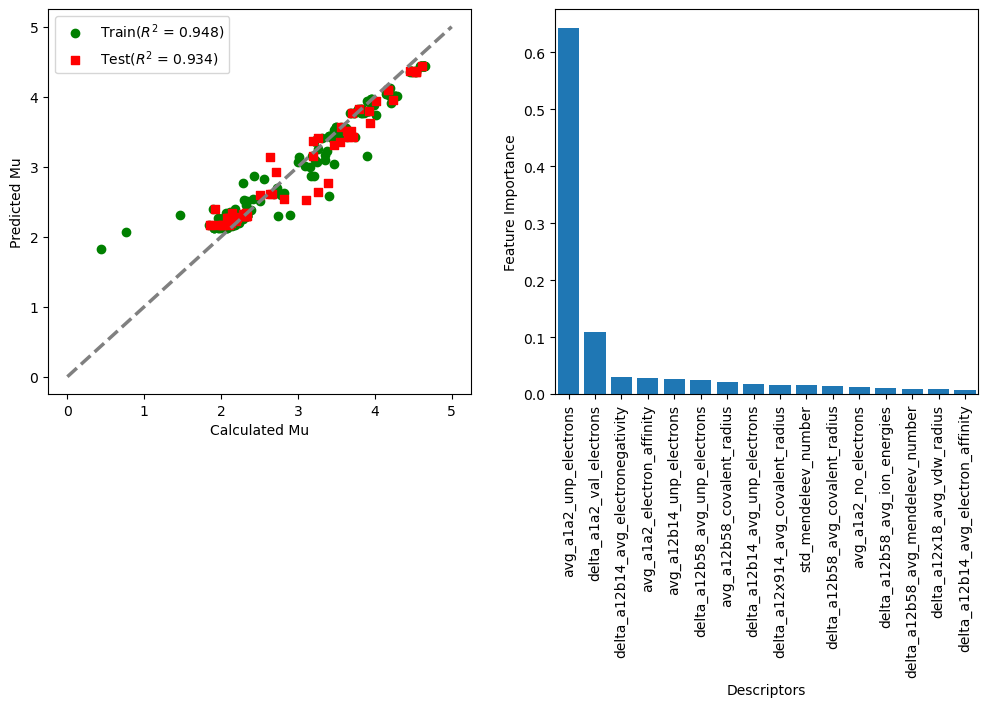

In [342]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[12])

R2 scores (train, CV, test) =  0.9400635321331954 0.8353417709633117 0.9483680767307372
MAE values (train, test) =  0.12733520519433264 0.13776326900871907


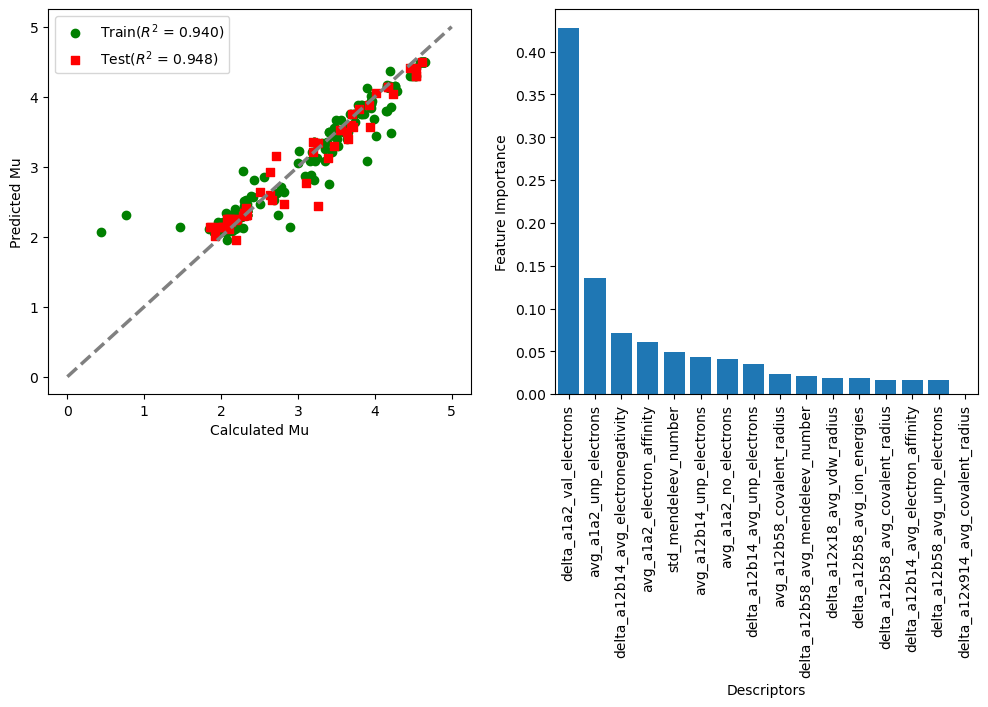

In [340]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[11])

R2 scores (train, CV, test) =  0.9289092918248932 0.841928965671568 0.9454150819014804
MAE values (train, test) =  0.13862373286013036 0.1511471573173644


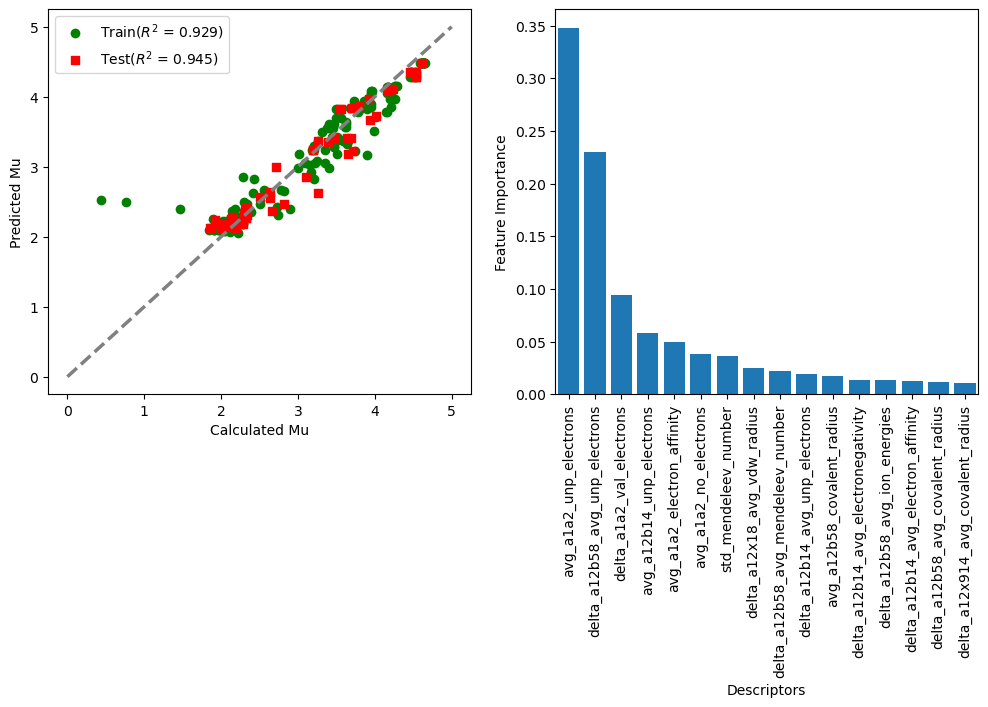

In [338]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[10])

R2 scores (train, CV, test) =  0.9915719404015021 0.8285593637758918 0.9613337694588071
MAE values (train, test) =  0.03739135712695696 0.09509735402517565


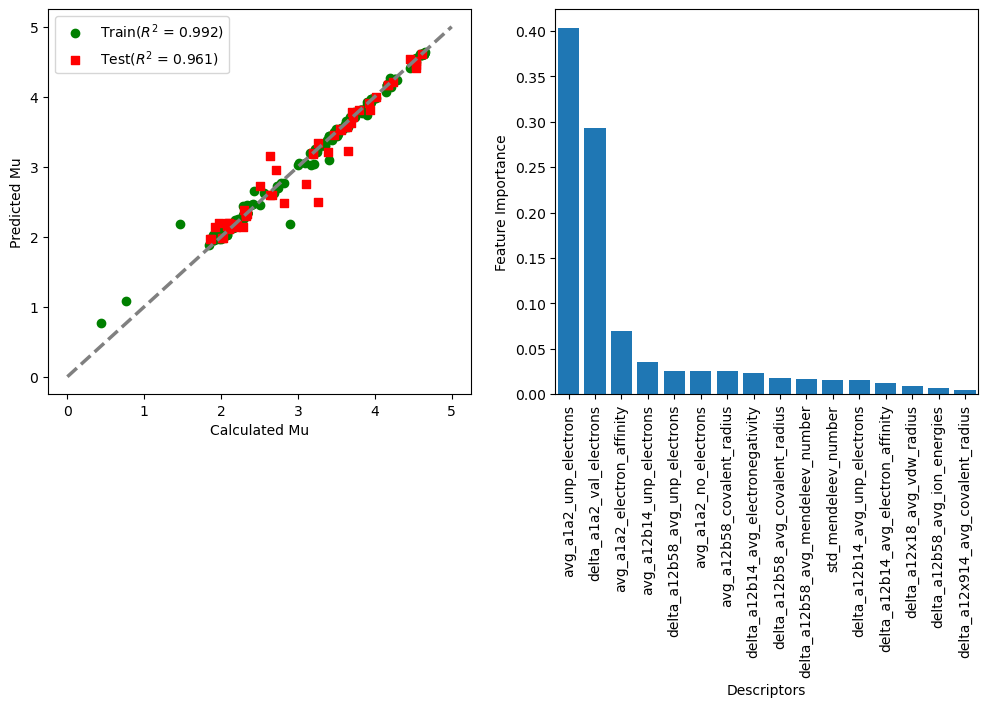

In [336]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[9])

R2 scores (train, CV, test) =  0.9460006016818686 0.8367234086121741 0.9207150043461648
MAE values (train, test) =  0.12502657627442 0.16762288166249867


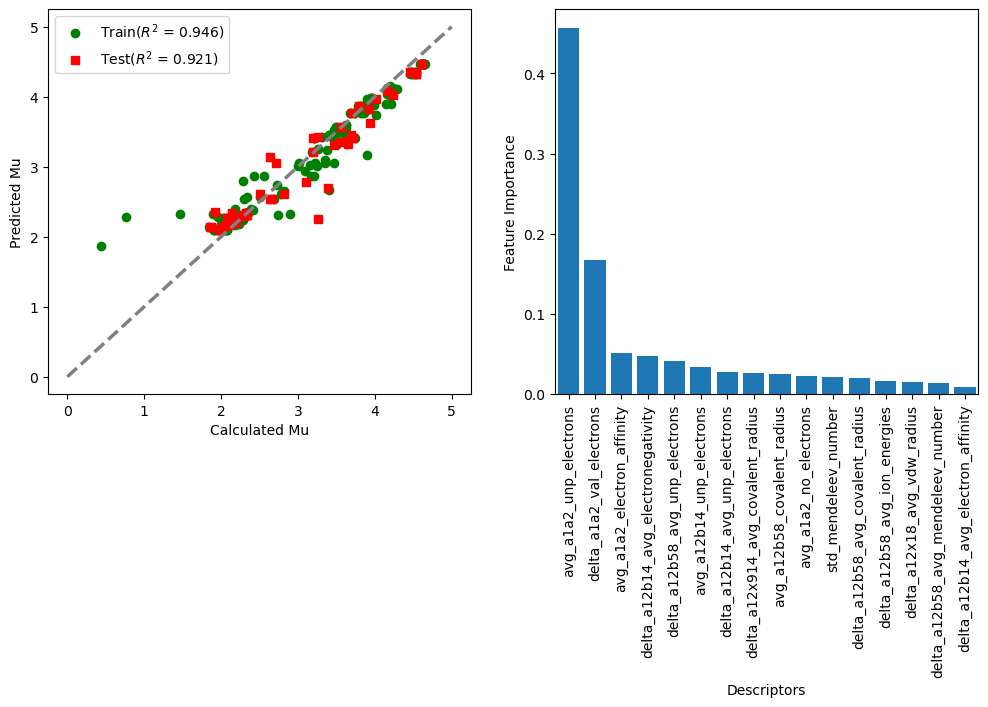

In [334]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[8])

R2 scores (train, CV, test) =  0.9531394089248293 0.8351956980211581 0.9218777441921233
MAE values (train, test) =  0.121721519657296 0.15374937176329662


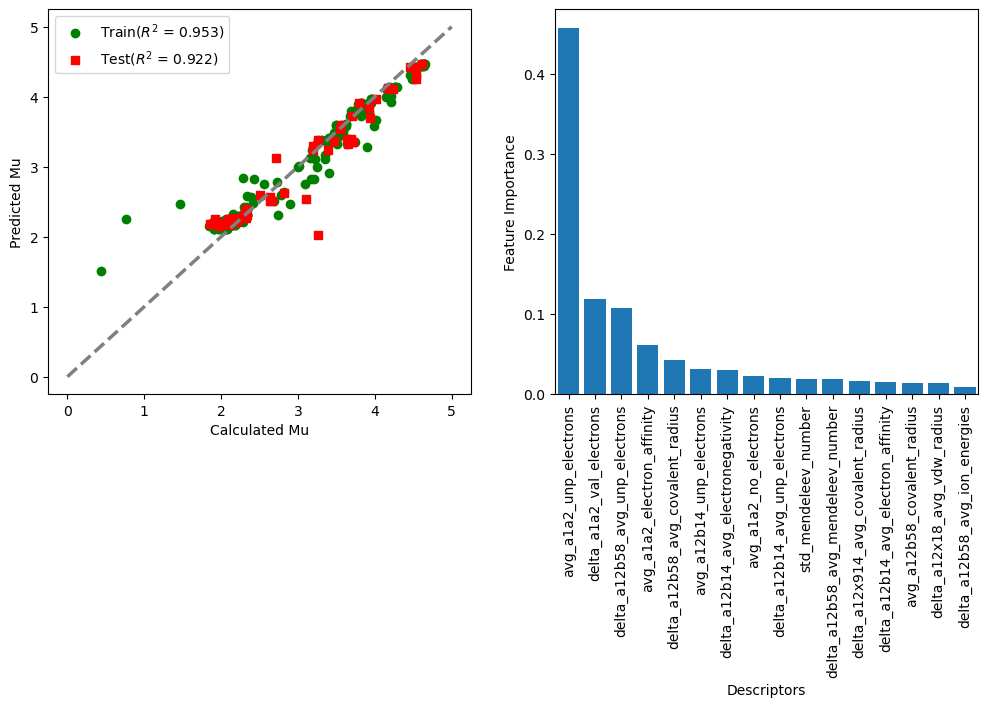

In [332]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[7])

R2 scores (train, CV, test) =  0.8953775148021343 0.8304287474954579 0.9498411817718998
MAE values (train, test) =  0.15134194770032205 0.13365352889617527


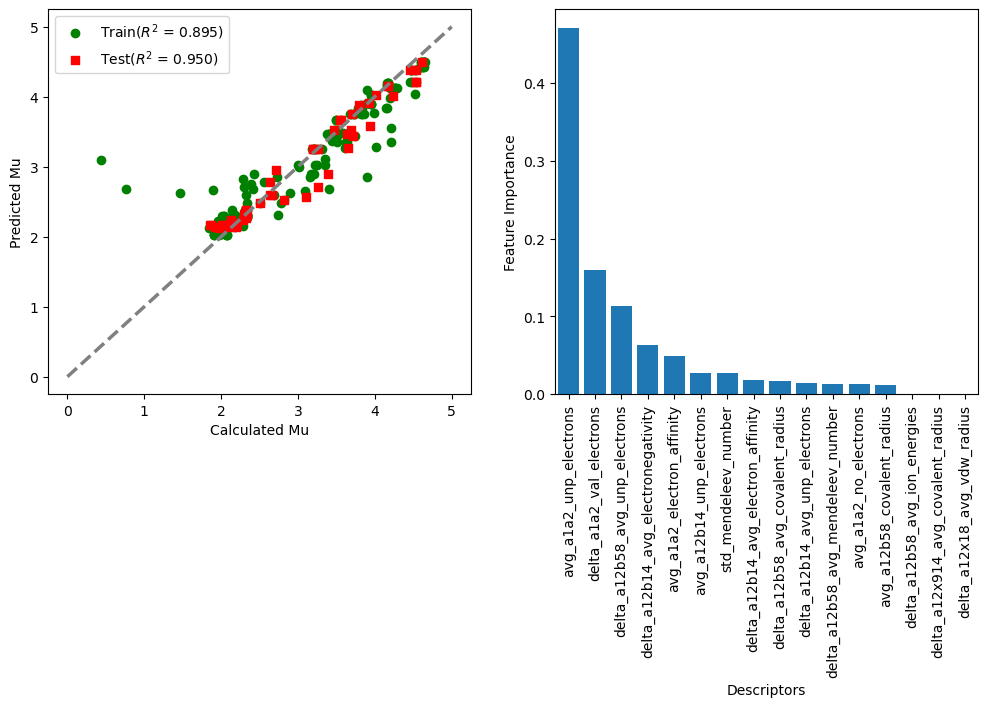

In [330]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[6])

R2 scores (train, CV, test) =  0.9925459470075444 0.8096482631067683 0.9078624667964176
MAE values (train, test) =  0.0376304192264431 0.14197143776498525


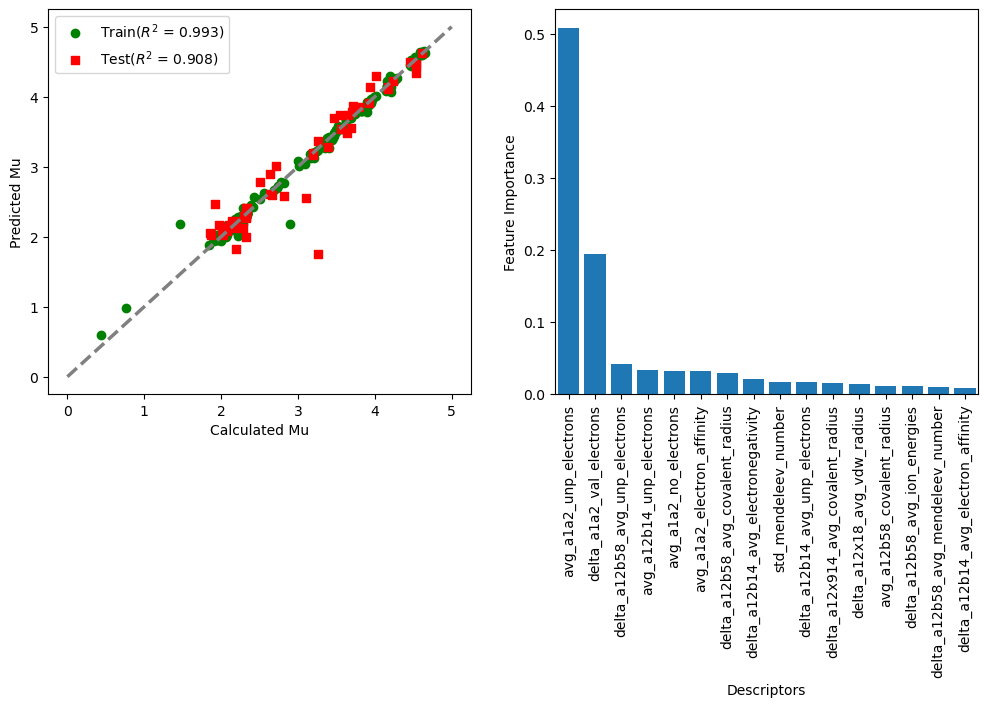

In [328]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[5])

R2 scores (train, CV, test) =  0.9478000217396761 0.8345771526285881 0.9340754574369725
MAE values (train, test) =  0.12887463592163687 0.16136284230459944


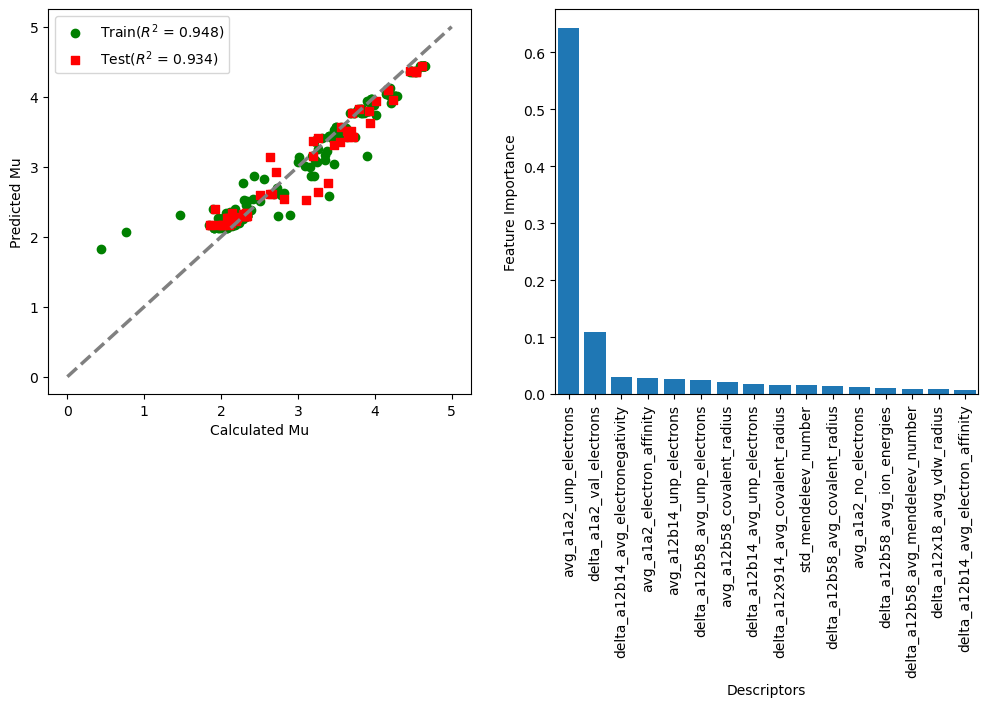

In [326]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[4])

R2 scores (train, CV, test) =  0.9484247590074912 0.8330329085130981 0.9317508848419102
MAE values (train, test) =  0.12755482820268144 0.1582770033784613


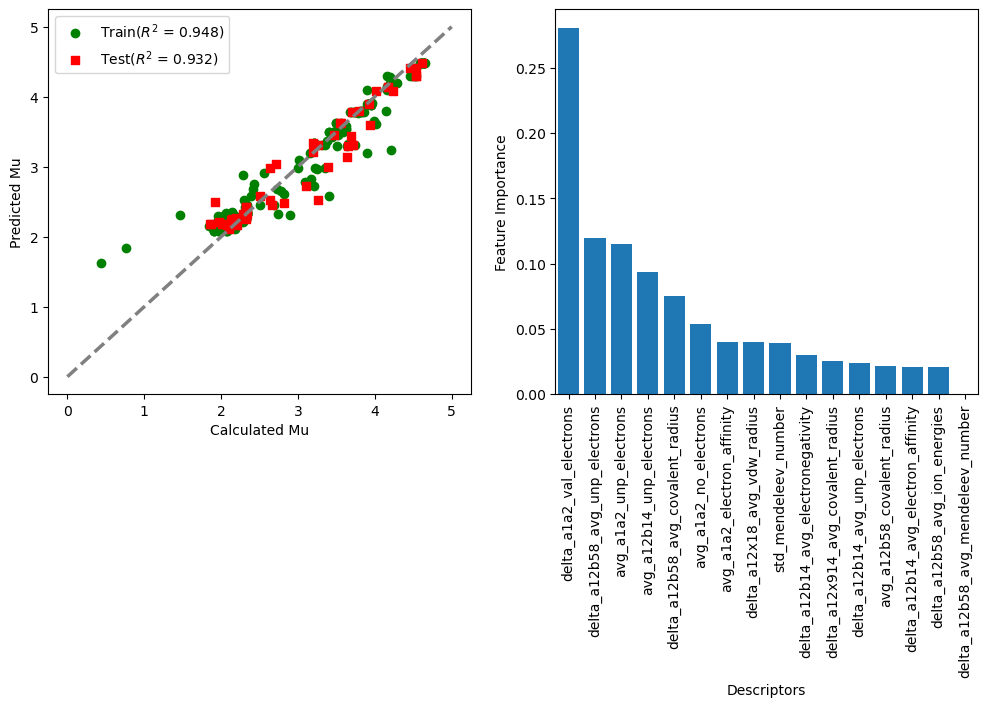

In [324]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[3])

R2 scores (train, CV, test) =  0.9826575855349302 0.8315449057486678 0.9428274063584732
MAE values (train, test) =  0.05161291438537584 0.11074767726638227


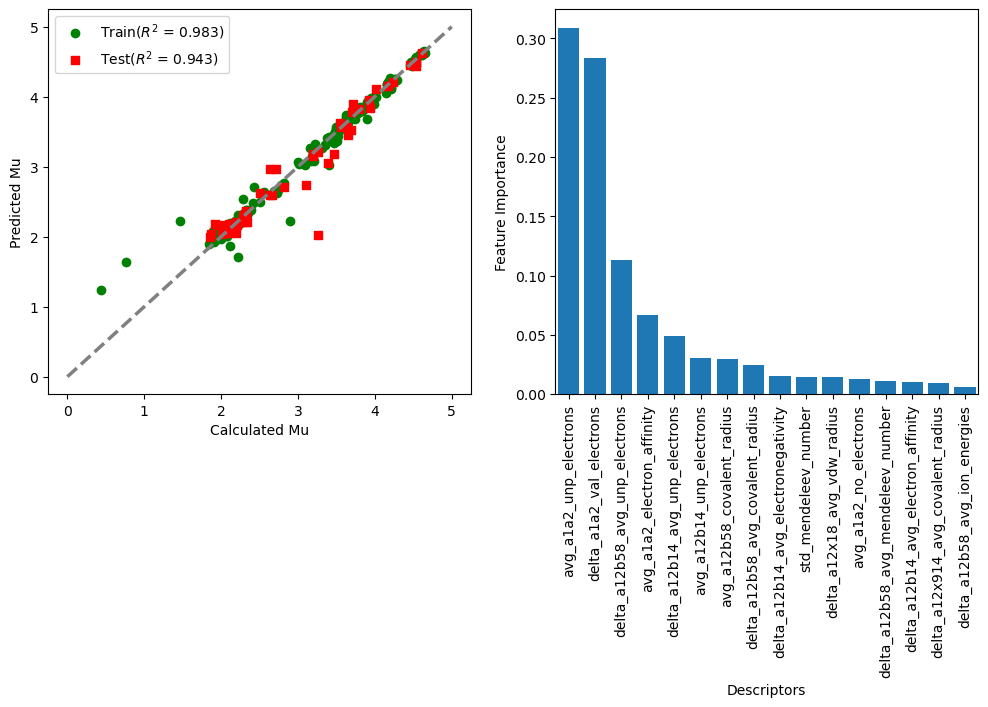

In [322]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[2])

R2 scores (train, CV, test) =  0.9203621077271474 0.8468109211632798 0.9334438225607274
MAE values (train, test) =  0.13626953757725455 0.15612142363273673


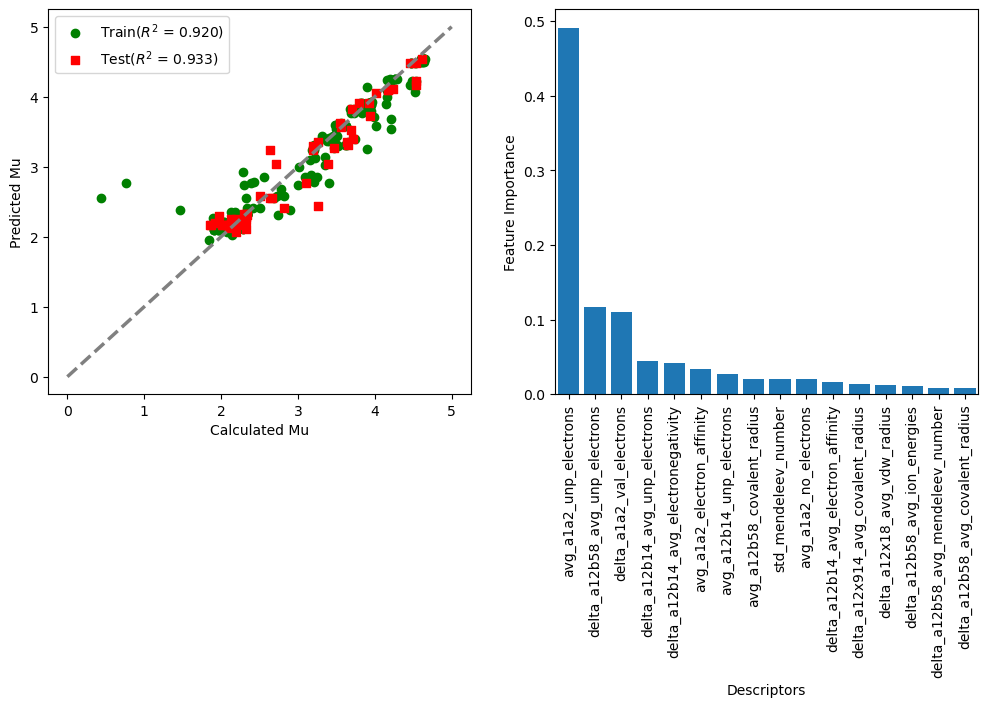

In [320]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[1])

R2 scores (train, CV, test) =  0.9484247590074912 0.8330329085130981 0.9317508848419102
MAE values (train, test) =  0.12755482820268144 0.1582770033784613


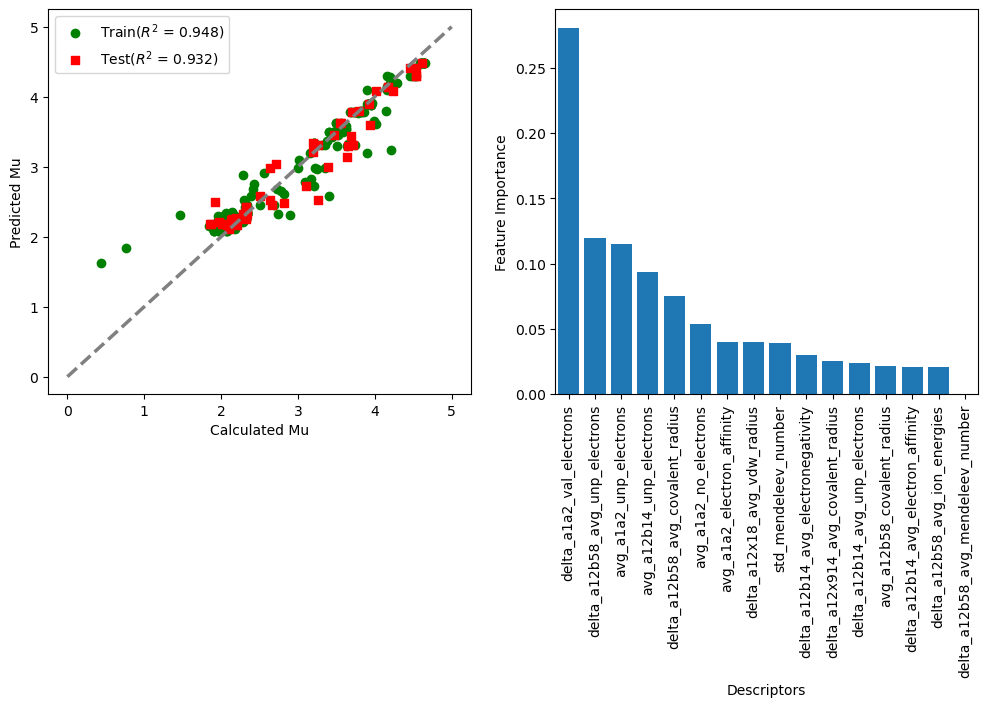

In [318]:
detailed_objective_x3_be(study_x3_xgb_be.best_trials[0])

In [1]:
## Best trial no: 9

In [355]:
def detailed_objective_x3_be_best(trial):
    n_estimators = trial.suggest_int('n_estimators',10,150)
    max_depth = trial.suggest_int('max_depth',5,50)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    gamma = trial.suggest_float('gamma', 0, 10)
    reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 10, log=True)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 10)
    max_delta_step = trial.suggest_float('max_delta_step', 0, 10)
    random_state = 52

    model_x3_xgb_be = xgb.XGBRegressor(n_estimators=best_models_x3_be_xgb[9].params['n_estimators'],
                                     max_depth=best_models_x3_be_xgb[9].params['max_depth'],
                                     learning_rate=best_models_x3_be_xgb[9].params['learning_rate'],
                                     subsample=best_models_x3_be_xgb[9].params['subsample'],
                                     colsample_bytree=best_models_x3_be_xgb[9].params['colsample_bytree'],
                                     gamma=best_models_x3_be_xgb[9].params['gamma'],
                                     reg_alpha=best_models_x3_be_xgb[9].params['reg_alpha'],
                                     reg_lambda=best_models_x3_be_xgb[9].params['reg_lambda'],
                                     min_child_weight=best_models_x3_be_xgb[9].params['min_child_weight'],
                                     scale_pos_weight=best_models_x3_be_xgb[9].params['scale_pos_weight'],
                                     max_delta_step=best_models_x3_be_xgb[9].params['max_delta_step'],
                                     random_state=random_state)
    # Train model
    xgb_mu_optuna_x3_be = model_x3_xgb_be.fit(X3_train_mu_be_xgb,y3_train_mu)

    cv = KFold(n_splits=10,shuffle=True,random_state=random_state)
    cv_scores_xgb_mu_optuna_x3_be = cross_val_score(xgb_mu_optuna_x3_be,X3_train_mu_be_xgb,y3_train_mu,cv=cv,scoring='r2',n_jobs=1)
    avg_r2_cv_xgb_mu_optuna_x3_be = cv_scores_xgb_mu_optuna_x3_be.mean()

    # Return best R2 scores
    r2_train_x3_be = r2_score(y3_train_mu, model_x3_xgb_be.predict(X3_train_mu_be_xgb))
    r2_test_x3_be = r2_score(y3_test_mu, model_x3_xgb_be.predict(X3_test_mu_be_xgb))

    mae_train_x3_be = mean_absolute_error(y3_train_mu, model_x3_xgb_be.predict(X3_train_mu_be_xgb))
    mae_test_x3_be = mean_absolute_error(y3_test_mu, model_x3_xgb_be.predict(X3_test_mu_be_xgb))
    
    print('R2 scores (train, CV, test) = ', r2_train_x3_be,avg_r2_cv_xgb_mu_optuna_x3_be,r2_test_x3_be)
    print('MAE values (train, test) = ', mae_train_x3_be,mae_test_x3_be)

    ## Exporting the results
    y3_pred_train_mu_be = model_x3_xgb_be.predict(X3_train_mu_be_xgb)
    y3_pred_test_mu_be = model_x3_xgb_be.predict(X3_test_mu_be_xgb)

    X3_train_mu_be_xgb.to_excel('Results_Mu/X_52_BE_train_Optuna.xlsx',index=False)
    X3_test_mu_be_xgb.to_excel('Results_Mu/X_52_BE_test_Optuna.xlsx',index=False)      
    
    y3_train_mu.to_excel('Results_Mu/y_52_BE_train_Optuna.xlsx',index=False)
    y3_test_mu.to_excel('Results_Mu/y_52_BE_test_Optuna.xlsx',index=False)      
    
    pd.DataFrame(y3_pred_train_mu_be).to_excel('Results_Mu/y_52_BE_pred_train_Optuna_9_BEST.xlsx',index=False)
    pd.DataFrame(y3_pred_test_mu_be).to_excel('Results_Mu/y_52_BE_pred_test_Optuna_9_BEST.xlsx',index=False)    
    
    # Plot the results
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    ax1.scatter(y3_train_mu, model_x3_xgb_be.predict(X3_train_mu_be_xgb).flatten(),label='Train($R^2$ = '+str(f'{r2_train_x3_be:.3f}')+')',marker='o',color='green')
    ax1.scatter(y3_test_mu, model_x3_xgb_be.predict(X3_test_mu_be_xgb).flatten(),label='Test($R^2$ = '+str(f'{r2_test_x3_be:.3f}')+')',marker='s',color='red')
    ax1.set_xlabel('Calculated Mu')
    ax1.set_ylabel('Predicted Mu')
    ax1.plot([0,5], [0,5],linewidth=2.5, color='gray', linestyle='dashed')
    ax1.legend()
    
    importances_xgb_mu_be = model_x3_xgb_be.feature_importances_
    indices_xgb_mu_be = np.argsort(importances_xgb_mu_be)[::-1]
    ax2.bar(range(16), importances_xgb_mu_be[indices_xgb_mu_be][:16], align='center')
    desc_labels_mu_be = X3_mu_be_xgb.columns[:]
    ax2.set_xticks(range(16), desc_labels_mu_be[indices_xgb_mu_be][:16],  rotation=90)
    ax2.set_xlim([-0.5, 15.5])
    ax2.set_ylabel('Feature Importance')
    ax2.set_xlabel('Descriptors')
    plt.show()

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    importances_xgb_mu_be = model_x3_xgb_be.feature_importances_
    indices_xgb_mu_be = np.argsort(importances_xgb_mu_be)[::-1]
    ax1.bar(range(6), importances_xgb_mu_be[indices_xgb_mu_be][:6], align='center')
    desc_labels_mu_be = X3_mu_be_xgb.columns[:]
    ax1.set_xticks(range(6), desc_labels_mu_be[indices_xgb_mu_be][:6],  rotation=90)
    ax1.set_xlim([-0.5, 5.5])
    ax1.set_ylabel('Feature Importance')
    ax1.set_xlabel('Descriptors')

    ax2.bar(range(8), importances_xgb_mu_be[indices_xgb_mu_be][:8], align='center')
    desc_labels_mu_be = X3_mu_be_xgb.columns[:]
    ax2.set_xticks(range(8), desc_labels_mu_be[indices_xgb_mu_be][:8],  rotation=90)
    ax2.set_xlim([-0.5, 7.5])
    ax2.set_ylabel('Feature Importance')
    ax2.set_xlabel('Descriptors')
    plt.show()

    fig,ax = plt.subplots(nrows = 4, ncols = 4,figsize = (30,30))
    nrows = 4
    ncols = 4
    count = 0
    for i in range(nrows):
        for j in range(ncols):
            
            ax[i,j].scatter(X3_mu_be_xgb[desc_labels_mu_be[indices_xgb_mu_be][count]],df['Mu_per_cell'][df['XGB_7_BE'] == 'FM'])
            ax[i,j].set_xlabel(''), ax[i,j].set_ylabel('Mu_per_cell'), ax[i,j].set_title(desc_labels_mu_be[indices_xgb_mu_be][count])
            
            count = count+1
    
    plt.show()

R2 scores (train, CV, test) =  0.9915719404015021 0.8285593637758918 0.9613337694588071
MAE values (train, test) =  0.03739135712695696 0.09509735402517565


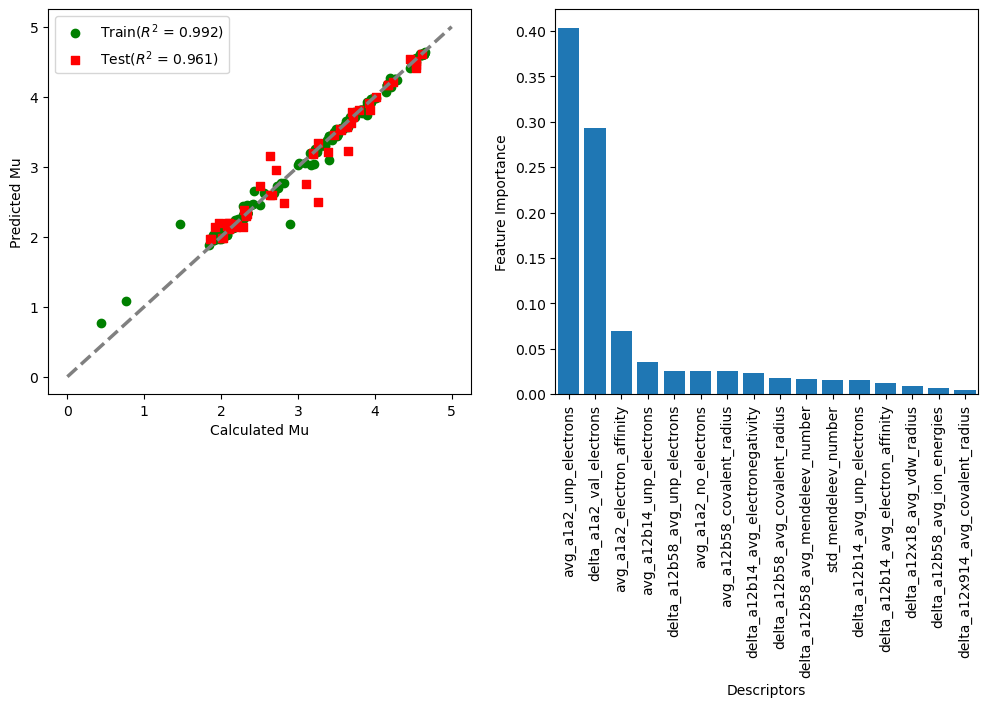

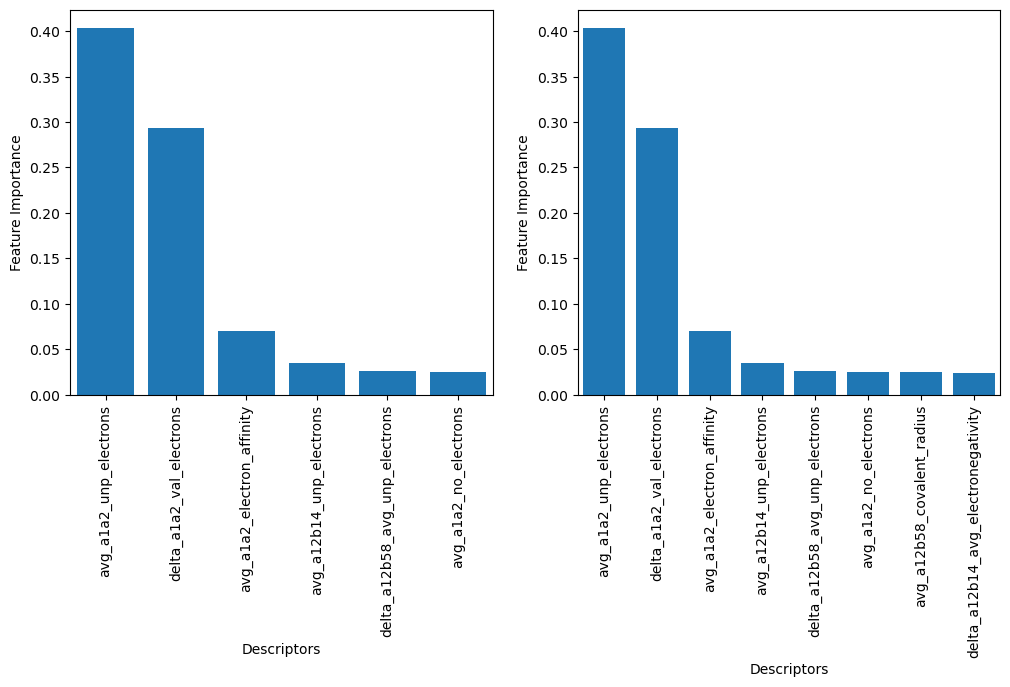

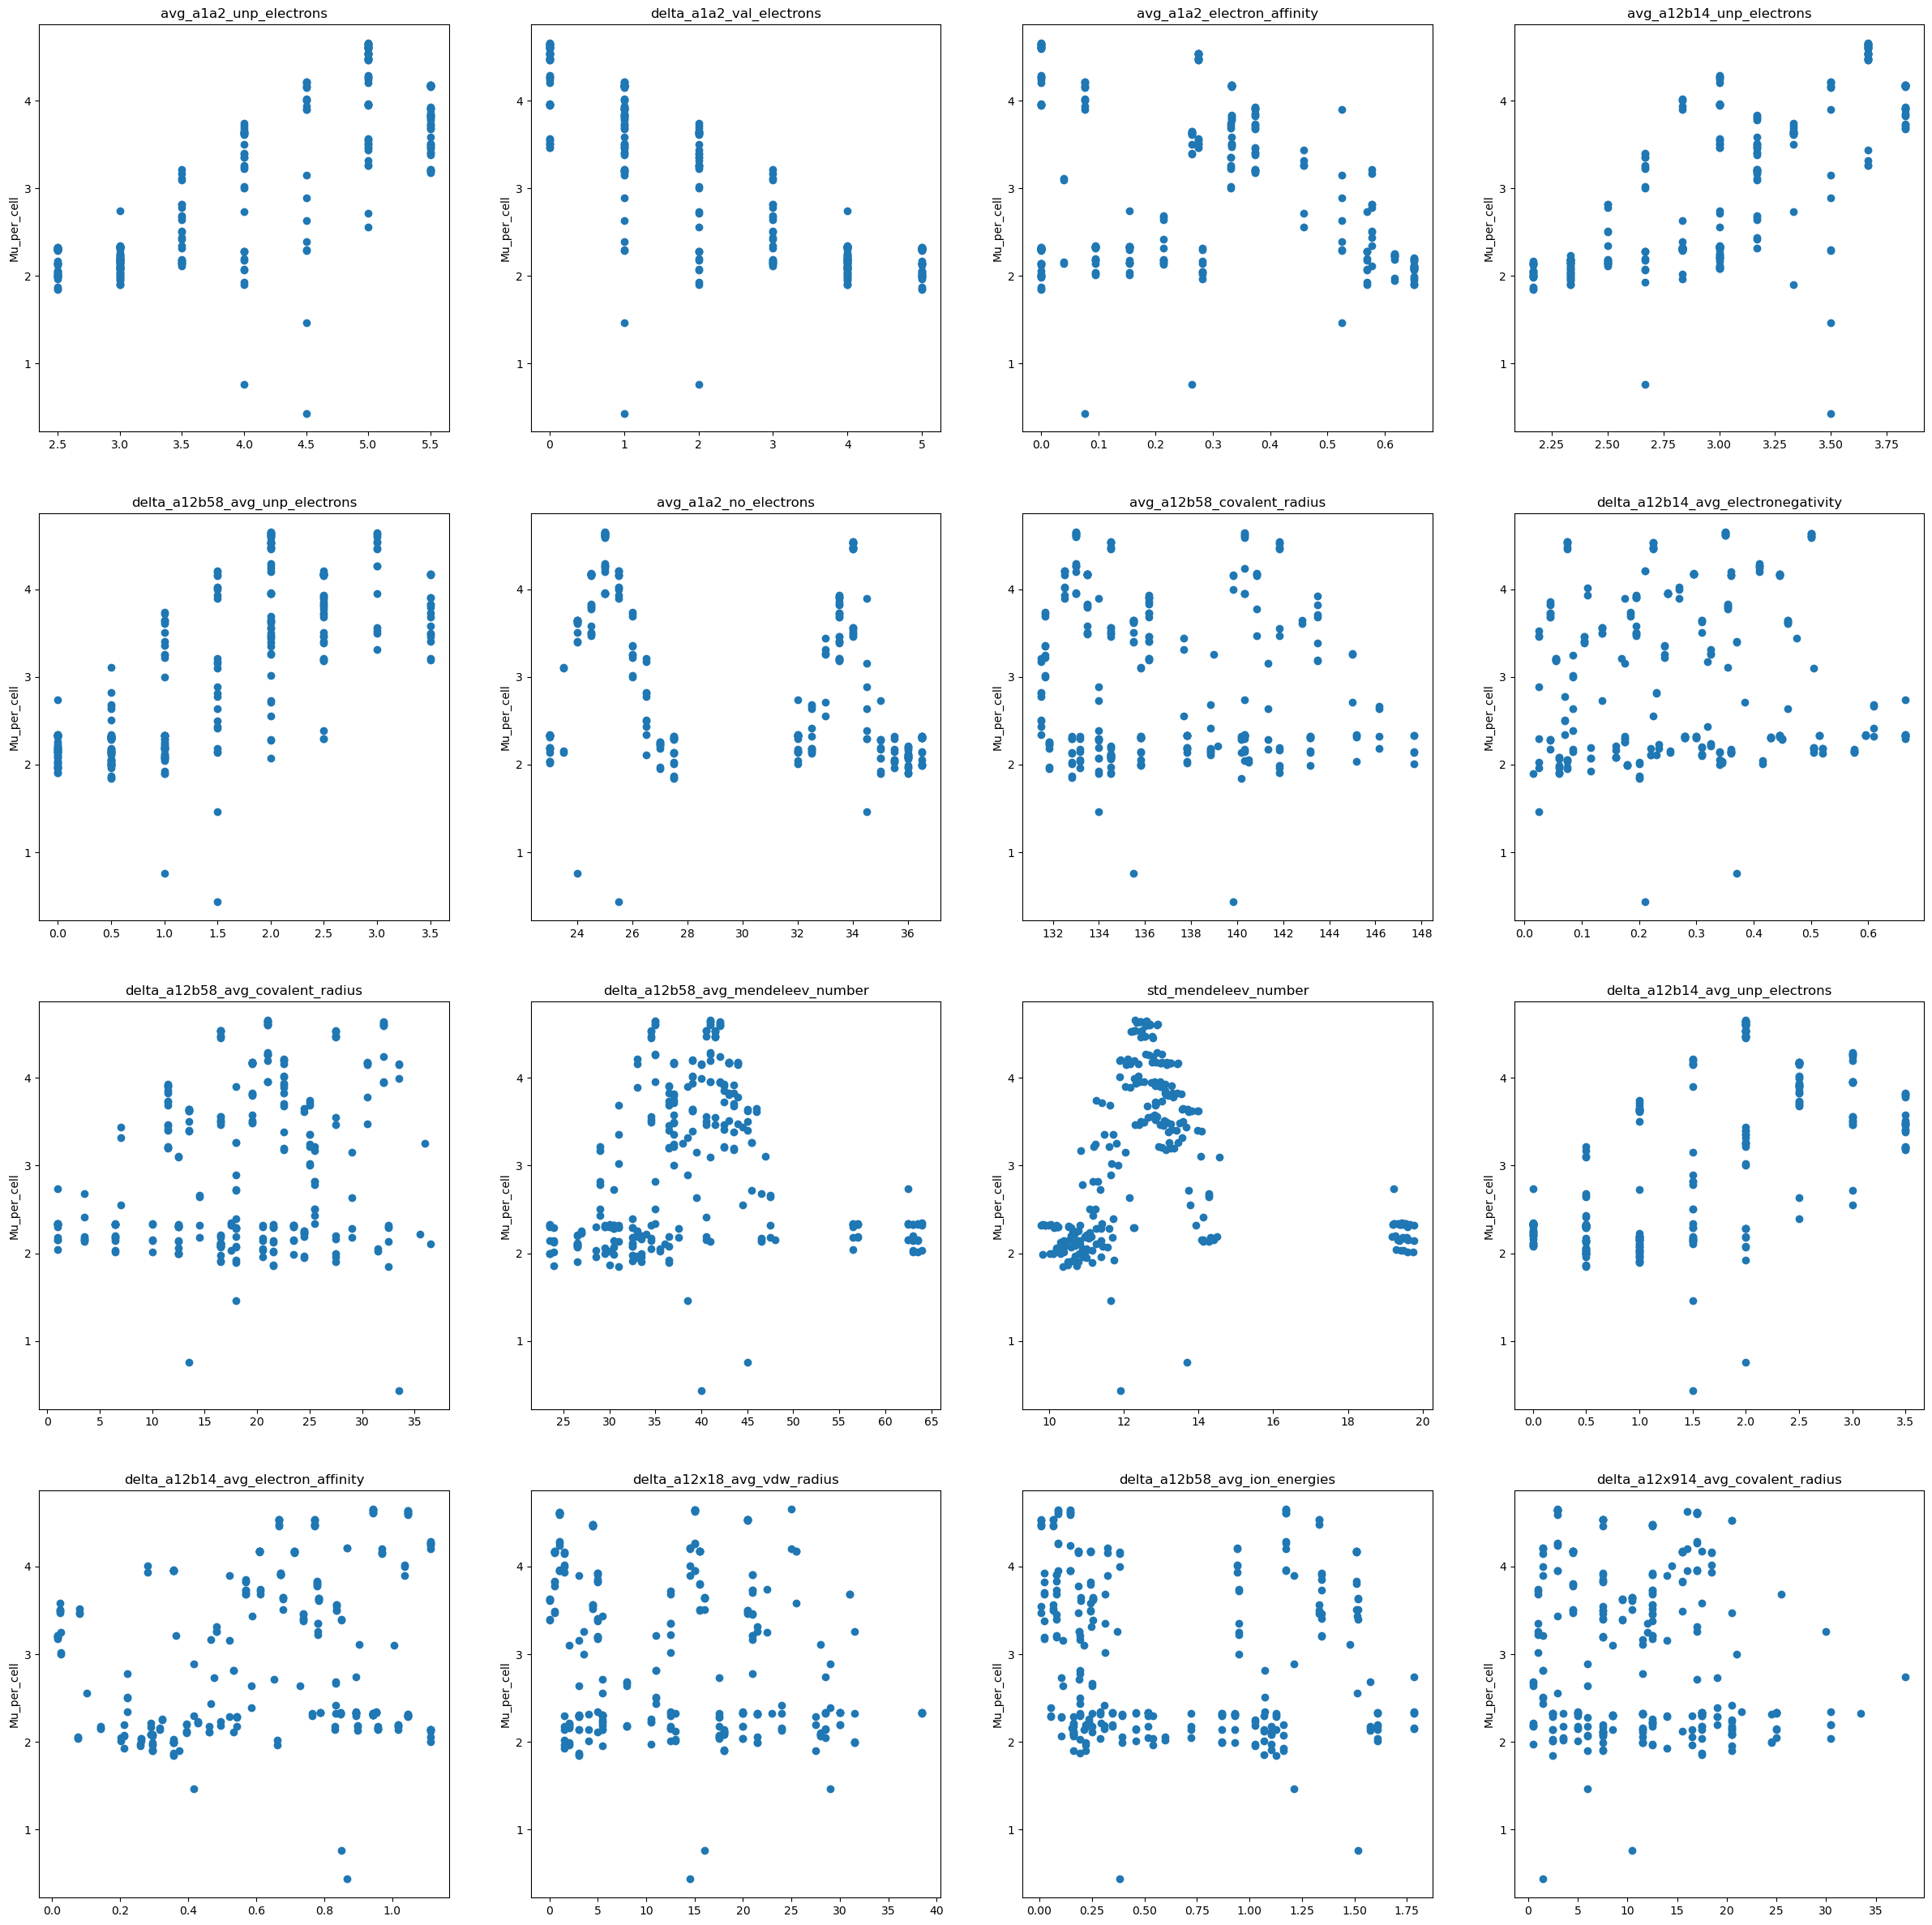

In [356]:
detailed_objective_x3_be_best(study_x3_xgb_be.best_trials[9])

In [2]:
## Using best model (9) to predict 785 candidates

In [9]:
features_BE = ['delta_a12x18_avg_vdw_radius','delta_a12x914_avg_covalent_radius','delta_a12b58_avg_covalent_radius','avg_a12b58_covalent_radius',
               'delta_a1a2_val_electrons','avg_a1a2_unp_electrons','delta_a12b14_avg_unp_electrons','delta_a12b58_avg_unp_electrons',
               'avg_a12b14_unp_electrons','delta_a12b58_avg_ion_energies','avg_a1a2_no_electrons','delta_a12b14_avg_electronegativity',
               'avg_a1a2_electron_affinity','delta_a12b14_avg_electron_affinity','std_mendeleev_number','delta_a12b58_avg_mendeleev_number']

In [14]:
X3_mu_be_xgb = X_mu[features_BE]
X3_train_mu_be_xgb = X3_train_mu[features_BE]
X3_test_mu_be_xgb = X3_test_mu[features_BE]

R2 scores (train, CV, test) =  0.9915719404015021 0.8285593637758918 0.9613337694588071
MAE values (train, test) =  0.03739135712695696 0.09509735402517565


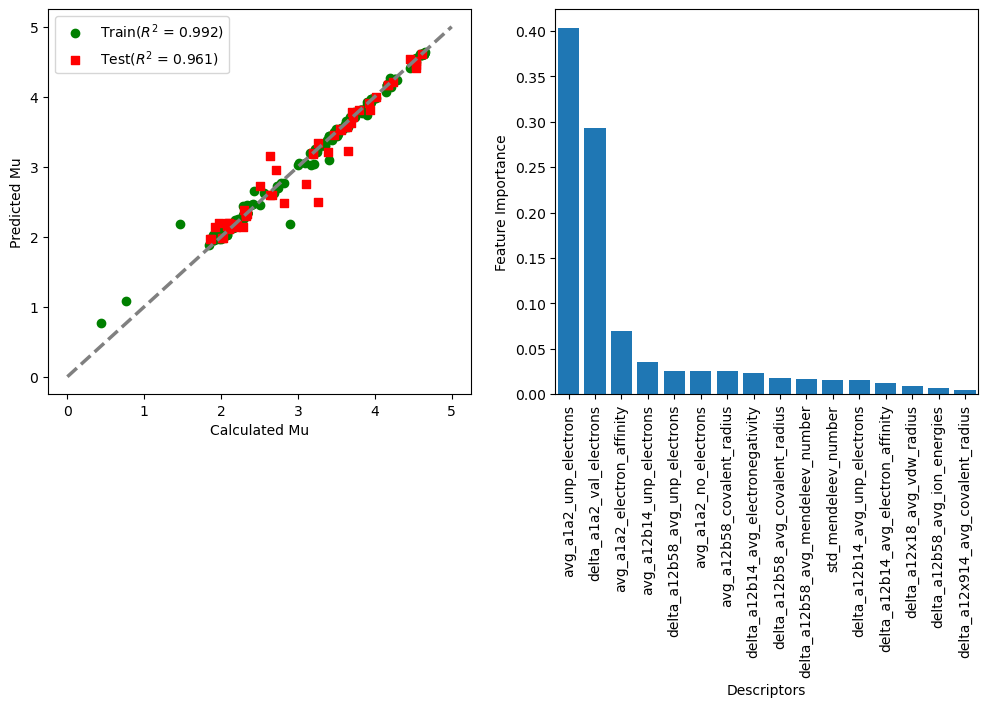

In [16]:
# Parameters:  {'n_estimators': 69, 'max_depth': 50, 'learning_rate': 0.11786061109948949, 'subsample': 0.7694425334648989, 
# 'colsample_bytree': 0.8192674120882275, 'gamma': 0.0035722448491881664, 'reg_alpha': 0.2536661556986479, 'reg_lambda': 0.8705557937590832,
# 'min_child_weight': 1, 'scale_pos_weight': 4, 'max_delta_step': 4.920648238616193}

best_9 = xgb.XGBRegressor(n_estimators=69,
                                 max_depth=50,
                                 learning_rate=0.11786061109948949,
                                 subsample=0.7694425334648989,
                                 colsample_bytree=0.8192674120882275,
                                 gamma=0.0035722448491881664,
                                 reg_alpha=0.2536661556986479,
                                 reg_lambda=0.8705557937590832,
                                 min_child_weight=1,
                                 scale_pos_weight=4,
                                 max_delta_step=4.920648238616193,
                                 random_state=52)
# Train model
xgb_mu_optuna_x3_be = best_9.fit(X3_train_mu_be_xgb,y3_train_mu)
cv = KFold(n_splits=10,shuffle=True,random_state=52)
cv_scores_xgb_mu_optuna_x3_be = cross_val_score(xgb_mu_optuna_x3_be,X3_train_mu_be_xgb,y3_train_mu,cv=cv,scoring='r2',n_jobs=1)
avg_r2_cv_xgb_mu_optuna_x3_be = cv_scores_xgb_mu_optuna_x3_be.mean()
# Return best R2 scores
r2_train_x3_be = r2_score(y3_train_mu, best_9.predict(X3_train_mu_be_xgb))
r2_test_x3_be = r2_score(y3_test_mu, best_9.predict(X3_test_mu_be_xgb))
mae_train_x3_be = mean_absolute_error(y3_train_mu, best_9.predict(X3_train_mu_be_xgb))
mae_test_x3_be = mean_absolute_error(y3_test_mu, best_9.predict(X3_test_mu_be_xgb))

print('R2 scores (train, CV, test) = ', r2_train_x3_be,avg_r2_cv_xgb_mu_optuna_x3_be,r2_test_x3_be)
print('MAE values (train, test) = ', mae_train_x3_be,mae_test_x3_be)

# Plot the results
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
ax1.scatter(y3_train_mu, best_9.predict(X3_train_mu_be_xgb).flatten(),label='Train($R^2$ = '+str(f'{r2_train_x3_be:.3f}')+')',marker='o',color='green')
ax1.scatter(y3_test_mu, best_9.predict(X3_test_mu_be_xgb).flatten(),label='Test($R^2$ = '+str(f'{r2_test_x3_be:.3f}')+')',marker='s',color='red')
ax1.set_xlabel('Calculated Mu')
ax1.set_ylabel('Predicted Mu')
ax1.plot([0,5], [0,5],linewidth=2.5, color='gray', linestyle='dashed')
ax1.legend()

importances_xgb_mu_be = best_9.feature_importances_
indices_xgb_mu_be = np.argsort(importances_xgb_mu_be)[::-1]
ax2.bar(range(16), importances_xgb_mu_be[indices_xgb_mu_be][:16], align='center')
desc_labels_mu_be = X3_mu_be_xgb.columns[:]
ax2.set_xticks(range(16), desc_labels_mu_be[indices_xgb_mu_be][:16],  rotation=90)
ax2.set_xlim([-0.5, 15.5])
ax2.set_ylabel('Feature Importance')
ax2.set_xlabel('Descriptors')
plt.show()

In [17]:
candidates_785 = pd.read_excel('Results_Mu/descriptors_for_891_candidates.xlsx','without_Si')

In [19]:
X_785 = candidates_785[features_BE]

In [22]:
pred_y_785 = best_9.predict(X_785)

In [24]:
pd.DataFrame(pred_y_785).to_csv('Results_Mu/XGB_Mu_pred_785.csv',index=False)

C:\Users\Romakanta\AppData\Local\Temp\ipykernel_7784\3862708586.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  rf_mu.fit(X_train_mu, y_train_mu.ravel())
C:\Users\Romakanta\AppData\Local\Temp\ipykernel_7784\3862708586.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  rf_mu.fit(X_train_mu, y_train_mu.ravel())
C:\Users\Romakanta\AppData\Local\Temp\ipykernel_7784\3862708586.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  rf_mu.fit(X_train_mu, y_train_mu.ravel())
C:\Users\Romakanta\AppData\Local\Temp\ipykernel_7784\3862708586.py:17: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel i

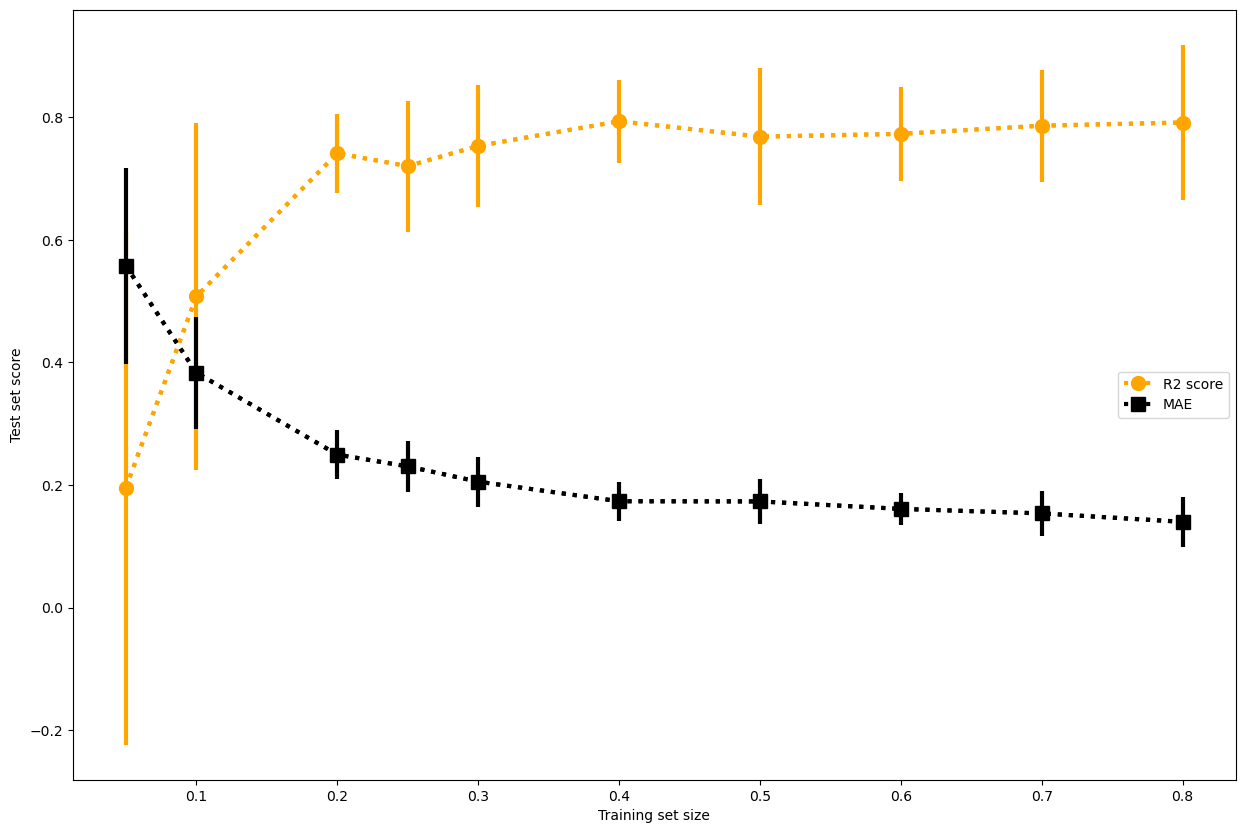

In [19]:
final_training_R2_scores = []
final_test_R2_scores = []
final_training_MAE_scores = []
final_test_MAE_scores = []

split_ratio = [0.05,0.1,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.8]
for i in range(len(split_ratio)):
    intermediate_training_R2_scores =[]
    intermediate_test_R2_scores = []
    intermediate_training_MAE_scores = []
    intermediate_test_MAE_scores = []
    
    for j in range(30):
        X_train_mu,X_test_mu,y_train_mu,y_test_mu= train_test_split(X_mu, y_mu, test_size=1-split_ratio[i])
        
        rf_mu= xgb.XGBRegressor(random_state=42)
        rf_mu.fit(X_train_mu, y_train_mu.ravel())
        
        prediction_mu_train= rf_mu.predict(X_train_mu)
        prediction_mu_test= rf_mu.predict(X_test_mu)
        
        r_sq_mu_train= metrics.r2_score(y_train_mu,prediction_mu_train)
        r_sq_mu_test= metrics.r2_score(y_test_mu,prediction_mu_test)
        
        mae_mu_train= metrics.mean_absolute_error(y_train_mu,prediction_mu_train)
        mae_mu_test= metrics.mean_absolute_error(y_test_mu,prediction_mu_test)
        
        intermediate_training_R2_scores.append(r_sq_mu_train)
        intermediate_test_R2_scores.append(r_sq_mu_test)
        
        intermediate_training_MAE_scores.append(mae_mu_train)
        intermediate_test_MAE_scores.append(mae_mu_test)
    
    final_training_R2_scores.append(intermediate_training_R2_scores)
    final_test_R2_scores.append(intermediate_test_R2_scores)  
    
    final_training_MAE_scores.append(intermediate_training_MAE_scores)
    final_test_MAE_scores.append(intermediate_test_MAE_scores)
    
# final_train_scores, final_test_scores
avg_training_R2_score = []
std_training_R2_score = []
avg_training_MAE_score = []
std_training_MAE_score = []

avg_test_R2_score = []
std_test_R2_score = []
avg_test_MAE_score = []
std_test_MAE_score = []

for i in range(len(final_training_R2_scores)):
    avg_training_R2_score.append(np.mean(final_training_R2_scores[i]))
    avg_test_R2_score.append(np.mean(final_test_R2_scores[i]))
    
    std_training_R2_score.append(np.std(final_training_R2_scores[i]))
    std_test_R2_score.append(np.std(final_test_R2_scores[i]))
    
    avg_training_MAE_score.append(np.mean(final_training_MAE_scores[i]))
    avg_test_MAE_score.append(np.mean(final_test_MAE_scores[i]))
    
    std_training_MAE_score.append(np.std(final_training_MAE_scores[i]))
    std_test_MAE_score.append(np.std(final_test_MAE_scores[i]))
    
# Plot
plt.figure(figsize=(15,10))
plt.plot(split_ratio, avg_test_R2_score, linewidth= 3, color='orange', marker = 'o', linestyle='dotted', label = 'R2 score', markersize=10)
plt.errorbar(split_ratio, avg_test_R2_score, linewidth= 3, color='orange', yerr = std_test_R2_score, linestyle='dotted')
plt.plot(split_ratio, avg_test_MAE_score, linewidth= 3, color='black', marker='s', linestyle='dotted', label = 'MAE', markersize=10)
plt.errorbar(split_ratio, avg_test_MAE_score, linewidth= 3, color='black', yerr = std_test_MAE_score, linestyle='dotted')

plt.xlabel('Training set size')
plt.ylabel('Test set score')
plt.legend(loc='center right')
plt.show()

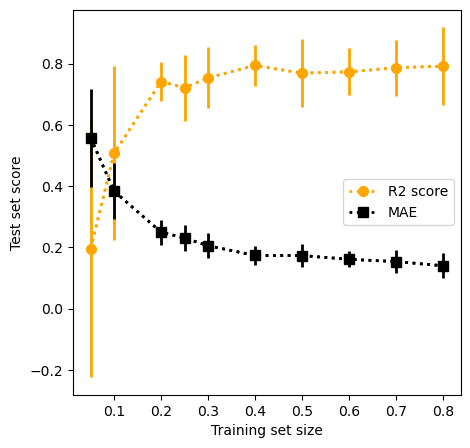

In [23]:
# Plot

plt.figure(figsize=(5,5))
plt.plot(split_ratio, avg_test_R2_score, linewidth= 2, color='orange', marker = 'o', linestyle='dotted', label = 'R2 score', markersize=7)
plt.errorbar(split_ratio, avg_test_R2_score, linewidth= 2, color='orange', yerr = std_test_R2_score, linestyle='dotted')
plt.plot(split_ratio, avg_test_MAE_score, linewidth= 2, color='black', marker='s', linestyle='dotted', label = 'MAE', markersize=7)
plt.errorbar(split_ratio, avg_test_MAE_score, linewidth= 2, color='black', yerr = std_test_MAE_score, linestyle='dotted')

plt.xlabel('Training set size')
plt.ylabel('Test set score')
plt.legend(loc='center right')
plt.show()